<a href="https://colab.research.google.com/github/Aruna-Jayarajan/Satelite_Network/blob/main/GNN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.models import load_model
from torch_geometric.loader import DataLoader as PyGDataLoader
import torch.nn.functional as F


# Add src/ to path
sys.path.append(os.path.join(os.getcwd(), 'src'))

# Project modules
from dataloader import SatelliteDataset, NUM_GATEWAYS
from model import Stage2GNN
from train import train_model_with_mse
from utils import plot_metrics


✅ Loaded 8 training files and 2 validation files.


Epoch 2, Train Loss: 3.8455, Val Loss: 3.8493
Epoch 4, Train Loss: 3.5140, Val Loss: 3.4209
Epoch 6, Train Loss: 3.1723, Val Loss: 3.0752
Epoch 8, Train Loss: 2.8236, Val Loss: 2.7720
Epoch 10, Train Loss: 2.5170, Val Loss: 2.5556
Epoch 12, Train Loss: 2.2892, Val Loss: 2.4200
Epoch 14, Train Loss: 2.1472, Val Loss: 2.3742
Epoch 16, Train Loss: 2.0624, Val Loss: 2.3808
Epoch 18, Train Loss: 2.0129, Val Loss: 2.4191
Epoch 20, Train Loss: 1.9631, Val Loss: 2.4614
Epoch 22, Train Loss: 1.8987, Val Loss: 2.4830
Epoch 24, Train Loss: 1.8473, Val Loss: 2.4806
Epoch 26, Train Loss: 1.7863, Val Loss: 2.4673
Epoch 28, Train Loss: 1.7428, Val Loss: 2.4525
Epoch 30, Train Loss: 1.7068, Val Loss: 2.4505
Epoch 32, Train Loss: 1.6683, Val Loss: 2.4661
Epoch 34, Train Loss: 1.6273, Val Loss: 2.4989
Epoch 36, Train Loss: 1.5880, Val Loss: 2.5435
Epoch 38, Train Loss: 1.5570, Val Loss: 2.5884
Epoch 40, Train Loss: 1.5222, Val Loss: 2.6299
Epoch 42, Train Loss: 1.4927, Val Loss: 2.6710
Epoch 44, Train L

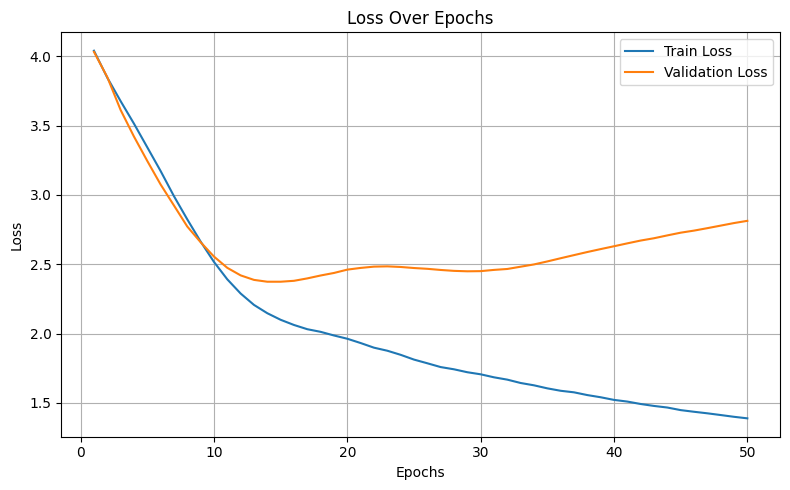

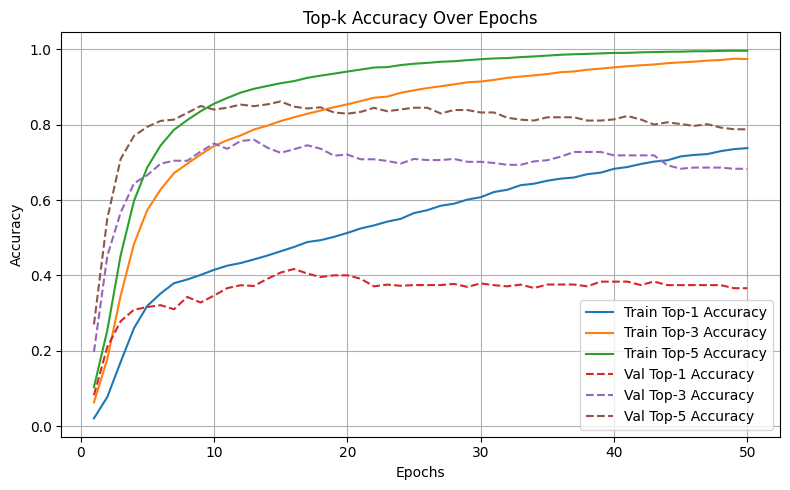

✅ GNN model saved.


In [6]:

# ========== Load Dataset ==========
DATA_FOLDER = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
file_list = sorted([
    os.path.join(DATA_FOLDER, f)
    for f in os.listdir(DATA_FOLDER)
    if f.endswith('.csv')
])[:10]

train_size = int(0.8 * len(file_list))
train_files, val_files = file_list[:train_size], file_list[train_size:]

train_dataset = SatelliteDataset(train_files)
val_dataset = SatelliteDataset(val_files)

train_loader = PyGDataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = PyGDataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"✅ Loaded {len(train_files)} training files and {len(val_files)} validation files.")

# ========== Load Stage 1 Model ==========
STAGE1_MODEL_PATH = 'stage_1_model.h5'
stage1_model = load_model(STAGE1_MODEL_PATH)

# ========== Build GNN Model ==========
input_dim = 3 + NUM_GATEWAYS * 3  # pos + visible + top3 + neighbor
gnn_model = Stage2GNN(
    input_dim=input_dim,
    sat_feature_dim=111,
    neighbor_feature_dim=NUM_GATEWAYS,
    hidden_dim=256,
    output_dim=NUM_GATEWAYS,
    dropout=0.3,
    use_residual=True
)

optimizer_gnn = optim.Adam(gnn_model.parameters(), lr=0.001)

# ========== Train ==========
results = train_model_with_mse(
    gnn_model=gnn_model,
    stage1_model=stage1_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer_gnn=optimizer_gnn,
    num_epochs=50,
    rounds=15
)


(train_losses, val_losses,
 train_top1_acc, train_top3_acc, train_top5_acc,
 val_top1_acc, val_top3_acc, val_top5_acc) = results

# ========== Plot ==========
plot_metrics(train_losses, val_losses,
             train_top1_acc, train_top3_acc, train_top5_acc,
             val_top1_acc, val_top3_acc, val_top5_acc)

# ========== Save ==========
torch.save(gnn_model.state_dict(), 'stage2_loop_gnn_model.pth')
print("✅ GNN model saved.")


Testing

evaluates 4 different test sets 

In [2]:
import os
import torch
import numpy as np
import pandas as pd
from torch_geometric.data import DataLoader
from tensorflow.keras.models import load_model

from dataloader import prepare_input_for_gnn, build_graph_from_file
from utils import top_k_accuracy
from model import Stage2GNN

# Constants
NUM_GATEWAYS = 54  # Define this according to your setup

# Paths
DATA_FOLDER = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
STAGE1_MODEL_PATH = 'stage_1_visible_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model.pth'

# Load models
stage1_model = load_model(STAGE1_MODEL_PATH)

input_dim = 3 + NUM_GATEWAYS * 3
gnn_model = Stage2GNN(input_dim=input_dim, sat_feature_dim=111,
                      neighbor_feature_dim=NUM_GATEWAYS, hidden_dim=256, output_dim=NUM_GATEWAYS)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# All files
file_list = sorted([os.path.join(DATA_FOLDER, f) for f in os.listdir(DATA_FOLDER) if f.endswith('.csv')])

# Define test ranges
test_ranges = {
    "Train Range 0-5": (0, 5),
    "Train Range 5-10": (5, 10),
    "Test Range 100-105": (100, 105),
    "Test Range 200-205": (200, 205)
}

# Function to evaluate one test set
def evaluate_test_set(name, start, end):
    print(f"\n===== Evaluating {name} (Files {start} to {end}) =====")
    test_files = file_list[start:end]
    test_graphs = [build_graph_from_file(f) for f in test_files if build_graph_from_file(f) is not None]
    test_loader = DataLoader(test_graphs, batch_size=1, shuffle=False)

    total_top1, total_top3, total_top5, total_samples = 0, 0, 0, 0
    predictions = []

    with torch.no_grad():
        for data in test_loader:
            input_features = data.x[:, :57].cpu().numpy()
            stage1_preds = stage1_model.predict(input_features, verbose=0)
            top3_model1 = np.argsort(stage1_preds, axis=1)[:, -3:]

            binary_preds_model1 = np.zeros_like(stage1_preds)
            for i, idx in enumerate(top3_model1):
                binary_preds_model1[i, idx] = 1

            gnn_input = prepare_input_for_gnn(data, torch.tensor(binary_preds_model1, dtype=torch.float))
            preds = gnn_model(gnn_input.x, gnn_input.edge_index)

            total_top1 += top_k_accuracy(preds, data.y, k=1)
            total_top3 += top_k_accuracy(preds, data.y, k=3)
            total_top5 += top_k_accuracy(preds, data.y, k=5)
            total_samples += 1

            top1_pred = torch.topk(preds, k=1, dim=1).indices.squeeze().tolist()
            for i in range(len(data.y)):
                predictions.append([data.y[i].item(), top1_pred[i]])

    print(f"Top-1 Accuracy: {total_top1 / total_samples:.4f}")
    print(f"Top-3 Accuracy: {total_top3 / total_samples:.4f}")
    print(f"Top-5 Accuracy: {total_top5 / total_samples:.4f}")

    # Save predictions
    results_df = pd.DataFrame(predictions, columns=["Ground Truth", "Top-1 Prediction"])
    filename = f"test_results_{name.replace(' ', '_').replace('-', '_')}.csv"
    results_df.to_csv(filename, index=False)
    print(f"Saved predictions to {filename}")


# Run all 4 test sets
for name, (start, end) in test_ranges.items():
    evaluate_test_set(name, start, end)



===== Evaluating Train Range 0-5 (Files 0 to 5) =====


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Top-1 Accuracy: 0.8031
Top-3 Accuracy: 0.9877
Top-5 Accuracy: 0.9986
Saved predictions to test_results_Train_Range_0_5.csv

===== Evaluating Train Range 5-10 (Files 5 to 10) =====


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Top-1 Accuracy: 0.6060
Top-3 Accuracy: 0.8640
Top-5 Accuracy: 0.9141
Saved predictions to test_results_Train_Range_5_10.csv

===== Evaluating Test Range 100-105 (Files 100 to 105) =====


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Top-1 Accuracy: 0.4002
Top-3 Accuracy: 0.7258
Top-5 Accuracy: 0.8294
Saved predictions to test_results_Test_Range_100_105.csv

===== Evaluating Test Range 200-205 (Files 200 to 205) =====


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Top-1 Accuracy: 0.3567
Top-3 Accuracy: 0.6482
Top-5 Accuracy: 0.7670
Saved predictions to test_results_Test_Range_200_205.csv


In [3]:
import os
import torch
import numpy as np
import pandas as pd
from torch_geometric.data import DataLoader
from tensorflow.keras.models import load_model

from dataloader import prepare_input_for_gnn, build_graph_from_file
from utils import top_k_accuracy
from model import Stage2GNN

# Paths
DATA_FOLDER = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
STAGE1_MODEL_PATH = 'stage_1_visible_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model.pth'  # Trained with MSE

# Load models
stage1_model = load_model(STAGE1_MODEL_PATH)

# Define GNN model (match architecture from training)
input_dim = 3 + NUM_GATEWAYS * 3
gnn_model = Stage2GNN(input_dim=input_dim, sat_feature_dim=111,
                      neighbor_feature_dim=NUM_GATEWAYS, hidden_dim=256, output_dim=NUM_GATEWAYS)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# Prepare test files (files 100 to 105)
file_list = sorted([os.path.join(DATA_FOLDER, f) for f in os.listdir(DATA_FOLDER) if f.endswith('.csv')])
test_files = file_list[100:105]

# Build PyG Data objects
test_graphs = [build_graph_from_file(f) for f in test_files if build_graph_from_file(f) is not None]
test_loader = DataLoader(test_graphs, batch_size=1, shuffle=False)

# Evaluate
total_top1, total_top3, total_top5, total_samples = 0, 0, 0, 0
predictions = []

with torch.no_grad():
    for data in test_loader:
        input_features = data.x[:, :57].cpu().numpy()
        stage1_preds = stage1_model.predict(input_features, verbose=0)
        top3_model1 = np.argsort(stage1_preds, axis=1)[:, -3:]

        # Convert to binary
        binary_preds_model1 = np.zeros_like(stage1_preds)
        for i, idx in enumerate(top3_model1):
            binary_preds_model1[i, idx] = 1

        gnn_input = prepare_input_for_gnn(data, torch.tensor(binary_preds_model1, dtype=torch.float))
        preds = gnn_model(gnn_input.x, gnn_input.edge_index)

        # Accuracy calculation
        total_top1 += top_k_accuracy(preds, data.y, k=1)
        total_top3 += top_k_accuracy(preds, data.y, k=3)
        total_top5 += top_k_accuracy(preds, data.y, k=5)
        total_samples += 1

        # Optional: store for inspection
        top1_pred = torch.topk(preds, k=1, dim=1).indices.squeeze().tolist()
        for i in range(len(data.y)):
            predictions.append([data.y[i].item(), top1_pred[i]])

# Print final accuracy
print("\n===== FINAL TEST ACCURACY (5 FILES) =====")
print(f"Top-1 Accuracy: {total_top1 / total_samples:.4f}")
print(f"Top-3 Accuracy: {total_top3 / total_samples:.4f}")
print(f"Top-5 Accuracy: {total_top5 / total_samples:.4f}")

# Optional: Save predictions
results_df = pd.DataFrame(predictions, columns=["Ground Truth", "Top-1 Prediction"])
results_df.to_csv("test_results_mse.csv", index=False)
print("\nSaved predictions to test_results_mse.csv")


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



===== FINAL TEST ACCURACY (5 FILES) =====
Top-1 Accuracy: 0.4002
Top-3 Accuracy: 0.7258
Top-5 Accuracy: 0.8294

Saved predictions to test_results_mse.csv


In [8]:
import os
import torch
import numpy as np
import pandas as pd
from torch_geometric.data import DataLoader
from tensorflow.keras.models import load_model

from dataloader import prepare_input_for_gnn, build_graph_from_file
from utils import top_k_accuracy
from model import Stage2GNN

# Paths
DATA_FOLDER = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
STAGE1_MODEL_PATH = 'stage_1_visible_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model.pth'  # Trained with MSE

# Load models
stage1_model = load_model(STAGE1_MODEL_PATH)

# Define GNN model (match architecture from training)
input_dim = 3 + NUM_GATEWAYS * 3
gnn_model = Stage2GNN(input_dim=input_dim, sat_feature_dim=111,
                      neighbor_feature_dim=NUM_GATEWAYS, hidden_dim=256, output_dim=NUM_GATEWAYS)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# Prepare test files (files 100 to 105)
file_list = sorted([os.path.join(DATA_FOLDER, f) for f in os.listdir(DATA_FOLDER) if f.endswith('.csv')])
test_files = file_list[200:205]

# Build PyG Data objects
test_graphs = [build_graph_from_file(f) for f in test_files if build_graph_from_file(f) is not None]
test_loader = DataLoader(test_graphs, batch_size=1, shuffle=False)

# Evaluate
total_top1, total_top3, total_top5, total_samples = 0, 0, 0, 0
predictions = []

with torch.no_grad():
    for data in test_loader:
        input_features = data.x[:, :57].cpu().numpy()
        stage1_preds = stage1_model.predict(input_features, verbose=0)
        top3_model1 = np.argsort(stage1_preds, axis=1)[:, -3:]

        # Convert to binary
        binary_preds_model1 = np.zeros_like(stage1_preds)
        for i, idx in enumerate(top3_model1):
            binary_preds_model1[i, idx] = 1

        gnn_input = prepare_input_for_gnn(data, torch.tensor(binary_preds_model1, dtype=torch.float))
        preds = gnn_model(gnn_input.x, gnn_input.edge_index)

        # Accuracy calculation
        total_top1 += top_k_accuracy(preds, data.y, k=1)
        total_top3 += top_k_accuracy(preds, data.y, k=3)
        total_top5 += top_k_accuracy(preds, data.y, k=5)
        total_samples += 1

        # Optional: store for inspection
        top1_pred = torch.topk(preds, k=1, dim=1).indices.squeeze().tolist()
        for i in range(len(data.y)):
            predictions.append([data.y[i].item(), top1_pred[i]])

# Print final accuracy
print("\n===== FINAL TEST ACCURACY (5 FILES) =====")
print(f"Top-1 Accuracy: {total_top1 / total_samples:.4f}")
print(f"Top-3 Accuracy: {total_top3 / total_samples:.4f}")
print(f"Top-5 Accuracy: {total_top5 / total_samples:.4f}")

# Optional: Save predictions
results_df = pd.DataFrame(predictions, columns=["Ground Truth", "Top-1 Prediction"])
results_df.to_csv("test_results_mse_separate.csv", index=False)
print("\nSaved predictions to test_results_mse.csv")


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



===== FINAL TEST ACCURACY (5 FILES) =====
Top-1 Accuracy: 0.3567
Top-3 Accuracy: 0.6482
Top-5 Accuracy: 0.7670

Saved predictions to test_results_mse.csv


In [10]:
import pandas as pd
df = pd.read_csv("test_results_mse.csv")
df.head()


,Ground Truth,Top-1 Prediction
0,20,10
1,53,0
2,5,8
3,30,50
4,36,36


Lets try including cells now shall we?

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import defaultdict, Counter
from tensorflow.keras.models import load_model
from torch_geometric.data import DataLoader
from dataloader import build_graph_from_file, prepare_input_for_gnn, NUM_GATEWAYS
from model import Stage2GNN

# === Setup Paths ===
DATA_FOLDER = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
CELLS_PATH = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv"
GW_PATH = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\df_gw.csv"
STAGE1_MODEL_PATH = 'stage_1_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model.pth'

# === Load Models ===
stage1_model = load_model(STAGE1_MODEL_PATH)
gnn_model = Stage2GNN(
    input_dim=3 + NUM_GATEWAYS * 3,
    sat_feature_dim=111,
    neighbor_feature_dim=NUM_GATEWAYS,
    hidden_dim=256,
    output_dim=NUM_GATEWAYS
)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# === Prepare Output Directory ===
os.makedirs("results_with_cells", exist_ok=True)

# === Select Files: 1st, 5th, 100th ===
file_list = sorted([f for f in os.listdir(DATA_FOLDER) if f.endswith('.csv')])
selected_indices = [0, 4, 99]
selected_files = [os.path.join(DATA_FOLDER, file_list[i]) for i in selected_indices if i < len(file_list)]

summary_stats = []
cells_df = pd.read_csv(CELLS_PATH)
gw_df = pd.read_csv(GW_PATH)

# === Colors for plotting ===
base_colors = list(mcolors.TABLEAU_COLORS.values())
np.random.seed(42)
np.random.shuffle(base_colors)
gateway_color_map = {i: base_colors[i % len(base_colors)] for i in range(NUM_GATEWAYS)}

def lighten_color(color, amount=0.5):
    import colorsys
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    r, g, b = mcolors.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    r, g, b = colorsys.hls_to_rgb(h, min(1, l + amount * (1 - l)), s)
    return r, g, b

def parse_cells(cell_str):
    if isinstance(cell_str, str):
        return list(map(int, eval(cell_str)))
    return []

# === Main Loop for Each File ===
for file_path in selected_files:
    file_name = os.path.basename(file_path)
    original_df = pd.read_csv(file_path)
    graph = build_graph_from_file(file_path)
    data_loader = DataLoader([graph], batch_size=1)

    unique_sats = original_df['feed_sat'].drop_duplicates().reset_index(drop=True)
    feed_sat_to_id = {sat: idx for idx, sat in enumerate(unique_sats)}
    sat_to_indices = defaultdict(list)
    for row_idx, feed_sat in enumerate(original_df["feed_sat"]):
        sat_to_indices[feed_sat].append(row_idx)

    satellite_to_gateway = {}
    gateway_to_sats = defaultdict(list)
    cell_to_gateways = {idx: [row["closest_gw_id"], row["second_closest_gw_id"]] for idx, row in cells_df.iterrows()}

    # === Inference ===
    top1_preds = []
    with torch.no_grad():
        for data in data_loader:
            input_features = data.x[:, :57].cpu().numpy()
            stage1_preds = stage1_model.predict(input_features, verbose=0)
            top3_indices = np.argsort(stage1_preds, axis=1)[:, -3:]
            binary_preds = np.zeros_like(stage1_preds)
            for i, idx in enumerate(top3_indices):
                binary_preds[i, idx] = 1

            gnn_input = prepare_input_for_gnn(data, torch.from_numpy(binary_preds).float())
            gnn_output = gnn_model(gnn_input.x, gnn_input.edge_index)
            top1_preds = torch.argmax(gnn_output, dim=1).cpu().numpy()

            for row_idx, gateway in enumerate(top1_preds):
                feed_sat = original_df.iloc[row_idx]["feed_sat"]
                satellite_to_gateway[feed_sat] = gateway
                gateway_to_sats[gateway].append(feed_sat)

    # === Cell Assignment ===
    satellite_to_cells = defaultdict(list)
    assigned_cells = set()
    used_gateways = set()

    for gw, sats in gateway_to_sats.items():
        nearby_cells = cells_df[(cells_df["closest_gw_id"] == gw) | (cells_df["second_closest_gw_id"] == gw)].index.tolist()
        if not sats or not nearby_cells:
            continue
        used_gateways.add(gw)
        sats = list(set(sats))
        cell_chunks = np.array_split(nearby_cells, len(sats))
        for sat, chunk in zip(sats, cell_chunks):
            for cell in chunk:
                if cell not in assigned_cells:
                    satellite_to_cells[sat].append(cell)
                    assigned_cells.add(cell)

    # === Save Mapping ===
    output_rows = []
    all_sat_ids = sorted(feed_sat_to_id.keys())
    for sat_feed_val in all_sat_ids:
        row_indices = sat_to_indices.get(sat_feed_val, [])
        predicted_gateways = [top1_preds[i] for i in row_indices if i < len(top1_preds)]
        most_common_gateway = Counter(predicted_gateways).most_common(1)[0][0] if predicted_gateways else None
        assigned = satellite_to_cells.get(sat_feed_val, [])
        assigned_clean = [int(cell) for cell in assigned]
        actual_gateway = original_df.loc[original_df["feed_sat"] == sat_feed_val, "gw"].iloc[0]
        actual_cell_ids = original_df.loc[original_df["feed_sat"] == sat_feed_val, "cell_id"].tolist()
        output_rows.append({
            "unique_satellite_id": sat_feed_val,
            "predicted_gateway": most_common_gateway,
            "actual_gateway_id": actual_gateway,
            "assigned_cells": assigned_clean,
            "actual_cell_ids": actual_cell_ids
        })

    mapping_df = pd.DataFrame(output_rows)
    mapping_path = f"results_with_cells/mapping_{file_name.replace('.csv', '')}.csv"
    mapping_df.to_csv(mapping_path, index=False)

    # === Summary Stats ===
    summary_stats.append({
        "File Name": file_name,
        "Rows": len(original_df),
        "Columns": original_df.shape[1],
        "Unique Satellites": original_df["feed_sat"].nunique(),
        "Unique Gateways": original_df["gw"].nunique(),
        "Unique Cells": original_df["cell_id"].nunique(),
        "Assigned Cells": len(assigned_cells),
        "Unassigned Cells": len(cells_df) - len(assigned_cells),
        "Used Gateways": len(used_gateways),
        "Unused Gateways": NUM_GATEWAYS - len(used_gateways)
    })

    # === Visualization ===
    def plot_map(title, save_name, include_sats=True, show_lines=False):
        plt.figure(figsize=(12, 10))
        for _, row in gw_df.iterrows():
            plt.scatter(row['longitude'], row['latitude'], marker='^',
                        color=gateway_color_map.get(row['gw_id'], 'gray'), edgecolor='black', s=150)

        for _, row in mapping_df.iterrows():
            pred_gw = row['predicted_gateway']
            color = lighten_color(gateway_color_map.get(pred_gw, 'gray'), amount=0.4)
            if include_sats:
                sat_row = original_df[original_df['feed_sat'] == row['unique_satellite_id']].drop_duplicates('feed_sat')
                if not sat_row.empty:
                    lng, lat = sat_row.iloc[0][['Longitude', 'Latitude']]
                    plt.scatter(lng, lat, marker='s', c=[color], edgecolor='black', s=80)

            for cell_idx in row['assigned_cells']:
                lng, lat = cells_df.loc[cell_idx, ['lng', 'lat']]
                plt.scatter(lng, lat, c=[color], s=10, alpha=0.7)

            if show_lines:
                pred_row = gw_df[gw_df['gw_id'] == row['predicted_gateway']]
                act_row = gw_df[gw_df['gw_id'] == row['actual_gateway_id']]
                if not pred_row.empty and not act_row.empty:
                    pred_lng, pred_lat = pred_row.iloc[0][['longitude', 'latitude']]
                    act_lng, act_lat = act_row.iloc[0][['longitude', 'latitude']]
                    plt.plot([pred_lng, act_lng], [pred_lat, act_lat], linestyle='--', color='gray')

        plt.title(title)
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"results_with_cells/{save_name}.png", dpi=300)
        plt.close()

    plot_map("Predicted Satellites and Gateways", f"map1_{file_name.replace('.csv', '')}")
    plot_map("Predicted Gateways and Assigned Cells", f"map2_{file_name.replace('.csv', '')}", include_sats=False)
    plot_map("Predicted vs Actual Gateways", f"map3_{file_name.replace('.csv', '')}", include_sats=False, show_lines=True)

# === Save All Summary ===
summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv("results_with_cells/summary_stats.csv", index=False)
print("✅ Completed inference, visualization, and saved outputs for selected files.")


In [5]:
import os
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import DataLoader
from tensorflow.keras.models import load_model
from collections import defaultdict, Counter

from dataloader import build_graph_from_file, prepare_input_for_gnn, NUM_GATEWAYS
from model import Stage2GNN

# === Paths ===
cells_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv"
data_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data\file_data_00_00_00.csv"
STAGE1_MODEL_PATH = 'stage_1_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model.pth'

# === Load Data ===
cells_df = pd.read_csv(cells_path)
original_df = pd.read_csv(data_file)

stage1_model = load_model(STAGE1_MODEL_PATH)

gnn_model = Stage2GNN(
    input_dim=3 + NUM_GATEWAYS * 3,
    sat_feature_dim=111,
    neighbor_feature_dim=NUM_GATEWAYS,
    hidden_dim=256,
    output_dim=NUM_GATEWAYS
)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# === Prepare Graph ===
graph = build_graph_from_file(data_file)
data_loader = DataLoader([graph], batch_size=1)

# === Setup ===
unique_sats = original_df['feed_sat'].drop_duplicates().reset_index(drop=True)
feed_sat_to_id = {sat: idx for idx, sat in enumerate(unique_sats)}
sat_to_indices = defaultdict(list)
for row_idx, feed_sat in enumerate(original_df["feed_sat"]):
    sat_to_indices[feed_sat].append(row_idx)

satellite_to_gateway = {}
gateway_to_sats = defaultdict(list)
cell_to_gateways = {}  # index → [closest, second]
for idx, row in cells_df.iterrows():
    cell_to_gateways[idx] = [row["closest_gw_id"], row["second_closest_gw_id"]]

# === Model Inference ===
top1_preds = []
with torch.no_grad():
    for data in data_loader:
        input_features = data.x[:, :57].cpu().numpy()
        stage1_preds = stage1_model.predict(input_features, verbose=0)
        top3_indices = np.argsort(stage1_preds, axis=1)[:, -3:]

        binary_preds = np.zeros_like(stage1_preds)
        for i, idx in enumerate(top3_indices):
            binary_preds[i, idx] = 1

        gnn_input = prepare_input_for_gnn(data, torch.from_numpy(binary_preds).float())
        gnn_output = gnn_model(gnn_input.x, gnn_input.edge_index)
        top1_preds = torch.argmax(gnn_output, dim=1).cpu().numpy()

        for row_idx, gateway in enumerate(top1_preds):
            feed_sat = original_df.iloc[row_idx]["feed_sat"]
            satellite_to_gateway[feed_sat] = gateway
            gateway_to_sats[gateway].append(feed_sat)

# === Fair Cell Assignment (Greedy) ===
satellite_to_cells = defaultdict(list)
assigned_cells = set()
used_gateways = set()

for gw, sats in gateway_to_sats.items():
    nearby_cells = cells_df[
        (cells_df["closest_gw_id"] == gw) | (cells_df["second_closest_gw_id"] == gw)
    ].index.tolist()

    if not sats or not nearby_cells:
        continue

    used_gateways.add(gw)
    sats = list(set(sats))  # Remove dups
    n_sats = len(sats)
    cell_chunks = np.array_split(nearby_cells, n_sats)

    for sat, chunk in zip(sats, cell_chunks):
        for cell in chunk:
            if cell not in assigned_cells:
                satellite_to_cells[sat].append(cell)
                assigned_cells.add(cell)

# === Summary ===
total_unique_sats = len(unique_sats)
total_cells = len(cells_df)
all_gateways = set(range(NUM_GATEWAYS))

assigned_sat_ids = set(satellite_to_cells.keys())
unassigned_sat_ids = sorted(set(feed_sat_to_id.keys()) - assigned_sat_ids)
unused_gateways = sorted(all_gateways - used_gateways)
unassigned_cells = sorted(set(cells_df.index) - assigned_cells)

# === Summary ===
print("\n=== Summary ===")
print(f"Unique Satellites: {total_unique_sats}")
print(f"Satellites With Assigned Cells: {len(assigned_sat_ids)} ({len(assigned_sat_ids) / total_unique_sats * 100:.2f}%)")
print(f"Satellites With No Assigned Cells: {len(unassigned_sat_ids)} ({len(unassigned_sat_ids) / total_unique_sats * 100:.2f}%)")

print(f"Gateways With Unassigned Cells: {len(unused_gateways)} ({len(unused_gateways) / NUM_GATEWAYS * 100:.2f}%)")
print(f"Total Gateways: {NUM_GATEWAYS}")
print(f"Used Gateways: {len(used_gateways)} ({len(used_gateways) / NUM_GATEWAYS * 100:.2f}%)")
print(f"Unused Gateways: {unused_gateways}")

print(f"Assigned Cells: {len(assigned_cells)} / {total_cells} ({len(assigned_cells) / total_cells * 100:.2f}%)")
print(f"Unassigned Cells: {len(unassigned_cells)} ({len(unassigned_cells) / total_cells * 100:.2f}%)")

# === Export Results ===
# === Export Results ===
output_rows = []
all_sat_ids = sorted(feed_sat_to_id.keys())  # Include all satellites, not just assigned ones

for sat_feed_val in all_sat_ids:
    row_indices = sat_to_indices.get(sat_feed_val, [])
    predicted_gateways = [top1_preds[i] for i in row_indices if i < len(top1_preds)]
    most_common_gateway = Counter(predicted_gateways).most_common(1)[0][0] if predicted_gateways else None
    assigned = satellite_to_cells.get(sat_feed_val, [])

    # Convert np.int64 values to int
    assigned_clean = [int(cell) for cell in assigned]

    actual_gateway = original_df.loc[original_df["feed_sat"] == sat_feed_val, "gw"].iloc[0]
    actual_cell_ids = original_df.loc[original_df["feed_sat"] == sat_feed_val, "cell_id"].tolist()

    output_rows.append({
        "unique_satellite_id": sat_feed_val,
        "predicted_gateway": most_common_gateway,
        "actual_gateway_id": actual_gateway,
        "assigned_cells": assigned_clean,
        "actual_cell_ids": actual_cell_ids
    })

output_df = pd.DataFrame(output_rows)
output_df.to_csv("satellite_to_cells_mapping.csv", index=False)

# === Output preview ===
print("\n=== Output File Preview ===")
print(output_df.head())


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



=== Summary ===
Unique Satellites: 112
Satellites With Assigned Cells: 86 (76.79%)
Satellites With No Assigned Cells: 26 (23.21%)
Gateways With Unassigned Cells: 1 (1.85%)
Total Gateways: 54
Used Gateways: 53 (98.15%)
Unused Gateways: [52]
Assigned Cells: 4569 / 4569 (100.00%)
Unassigned Cells: 0 (0.00%)

=== Output File Preview ===
   unique_satellite_id  predicted_gateway  actual_gateway_id  \
0                    5                  2                  2   
1                    7                 34                 34   
2                    8                 29                 29   
3                   28                  3                  2   
4                   29                 21                 21   

                                      assigned_cells  \
0                                                 []   
1  [1, 274, 312, 345, 399, 416, 445, 512, 586, 72...   
2  [92, 108, 163, 212, 303, 375, 440, 536, 598, 7...   
3  [2034, 2585, 2643, 2697, 2938, 2976, 3007, 301...   

Small test to see unique feed_sats

In [12]:
import pandas as pd

# Path to your input file
data_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data\file_data_00_00_00.csv"

# Load the full data
df = pd.read_csv(data_file)

# Group by unique feed_sat and extract the first lat/lon per satellite
unique_sat_info = (
    df[['feed_sat', 'Latitude', 'Longitude']]
    .drop_duplicates(subset='feed_sat')
    .sort_values(by='feed_sat')
    .reset_index(drop=True)
)

# Save to CSV
output_file = "unique_feed_sats_with_location.csv"
unique_sat_info.to_csv(output_file, index=False)

print(f"Saved {len(unique_sat_info)} unique satellites with location to {output_file}")


Saved 112 unique satellites with location to unique_feed_sats_with_location.csv


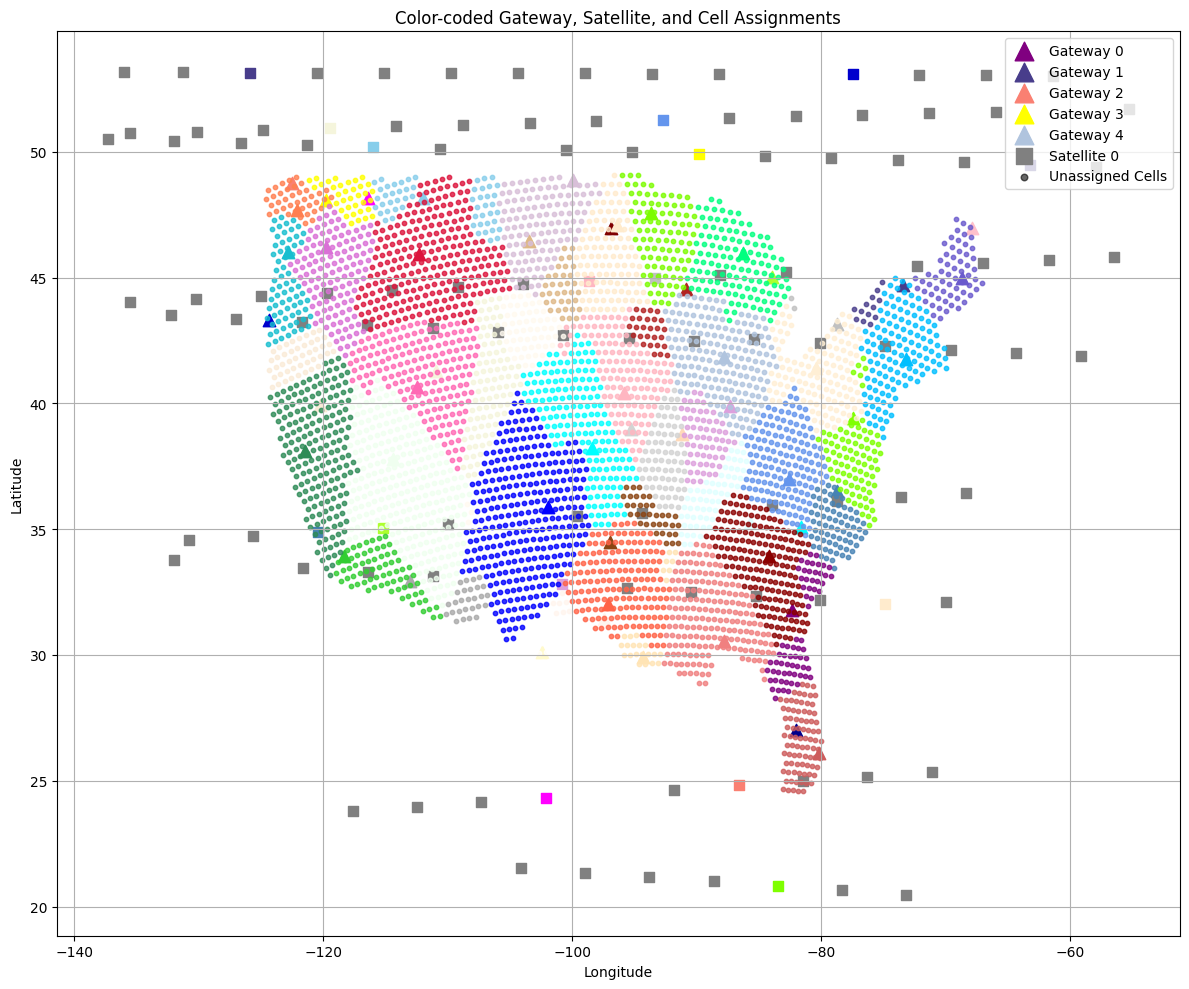

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# === Load Data ===
mapping_df = pd.read_csv("satellite_to_cells_mapping.csv")
cells_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv")
gw_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\df_gw.csv")
sat_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data\file_data_00_00_00.csv")
sat_df = sat_df.drop_duplicates(subset='feed_sat')

# === Build Gateway Color Map ===
NUM_GATEWAYS = 54
gateway_ids = list(range(NUM_GATEWAYS))
color_list = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
np.random.seed(42)  # for consistent color shuffling
np.random.shuffle(color_list)
gateway_color_map = {gw: color_list[i % len(color_list)] for i, gw in enumerate(gateway_ids)}

# === Track used cells
assigned_cell_indices = set()
satellite_colors = {}  # satellite_id -> color (based on gateway)
cell_color_data = []   # (lng, lat, color)

# === Assign colors to cells and satellites ===
for _, row in mapping_df.iterrows():
    gateway = row['predicted_gateway']
    sat_id = row['unique_satellite_id']
    color = gateway_color_map.get(gateway, 'gray')
    satellite_colors[sat_id] = color

    if isinstance(row['assigned_cells'], str):
        cell_indices = eval(row['assigned_cells'])
    else:
        cell_indices = []

    assigned_cell_indices.update(cell_indices)

    for idx in cell_indices:
        lat, lng = cells_df.loc[idx, ['lat', 'lng']]
        cell_color_data.append((lng, lat, color))

# === Unassigned cells ===
all_cell_indices = set(cells_df.index)
unassigned_cells = cells_df.loc[list(all_cell_indices - assigned_cell_indices)]

summary_stats = {
    "Unique Satellites": total_unique_sats,
    "Satellites With Assigned Cells": len(assigned_sat_ids),
    "Satellites Without Cells": len(unassigned_sat_ids),
    "Total Cells": total_cells,
    "Assigned Cells": len(assigned_cells),
    "Unassigned Cells": len(unassigned_cells),
    "Total Gateways": NUM_GATEWAYS,
    "Used Gateways": len(used_gateways),
    "Unused Gateways": len(unused_gateways),
}
summary_df = pd.DataFrame([summary_stats])
summary_df.to_csv("network_assignment_summary.csv", index=False)

# === Plot ===
plt.figure(figsize=(12, 10))

# 1. Gateways (colored triangles)
for _, row in gw_df.iterrows():
    gw_id = row['gw_id']
    plt.scatter(row['longitude'], row['latitude'], marker='^',
                color=gateway_color_map.get(gw_id, 'gray'), s=80, label=f"Gateway {gw_id}" if gw_id < 5 else "")

# 2. Satellites (colored squares)
for i, row in sat_df.iterrows():
    sat_id = i
    lat, lng = row['Latitude'], row['Longitude']
    color = satellite_colors.get(sat_id, 'gray')
    plt.scatter(lng, lat, marker='s', c=color, s=60, label=f"Satellite {sat_id}" if sat_id < 1 else "")

# 3. Cells (colored circles)
for lng, lat, color in cell_color_data:
    plt.scatter(lng, lat, color=color, s=10, alpha=0.8)

# 4. Unassigned Cells (black circles)
plt.scatter(unassigned_cells['lng'], unassigned_cells['lat'], color='black',
            s=10, alpha=0.6, label="Unassigned Cells")

# === Aesthetics ===
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Color-coded Gateway, Satellite, and Cell Assignments")
plt.grid(True)
plt.legend(loc='upper right', markerscale=1.5)
plt.tight_layout()

# === Save & Show ===
plt.savefig("color_coded_satellite_gateway_cell_map.png", dpi=300)
plt.show()


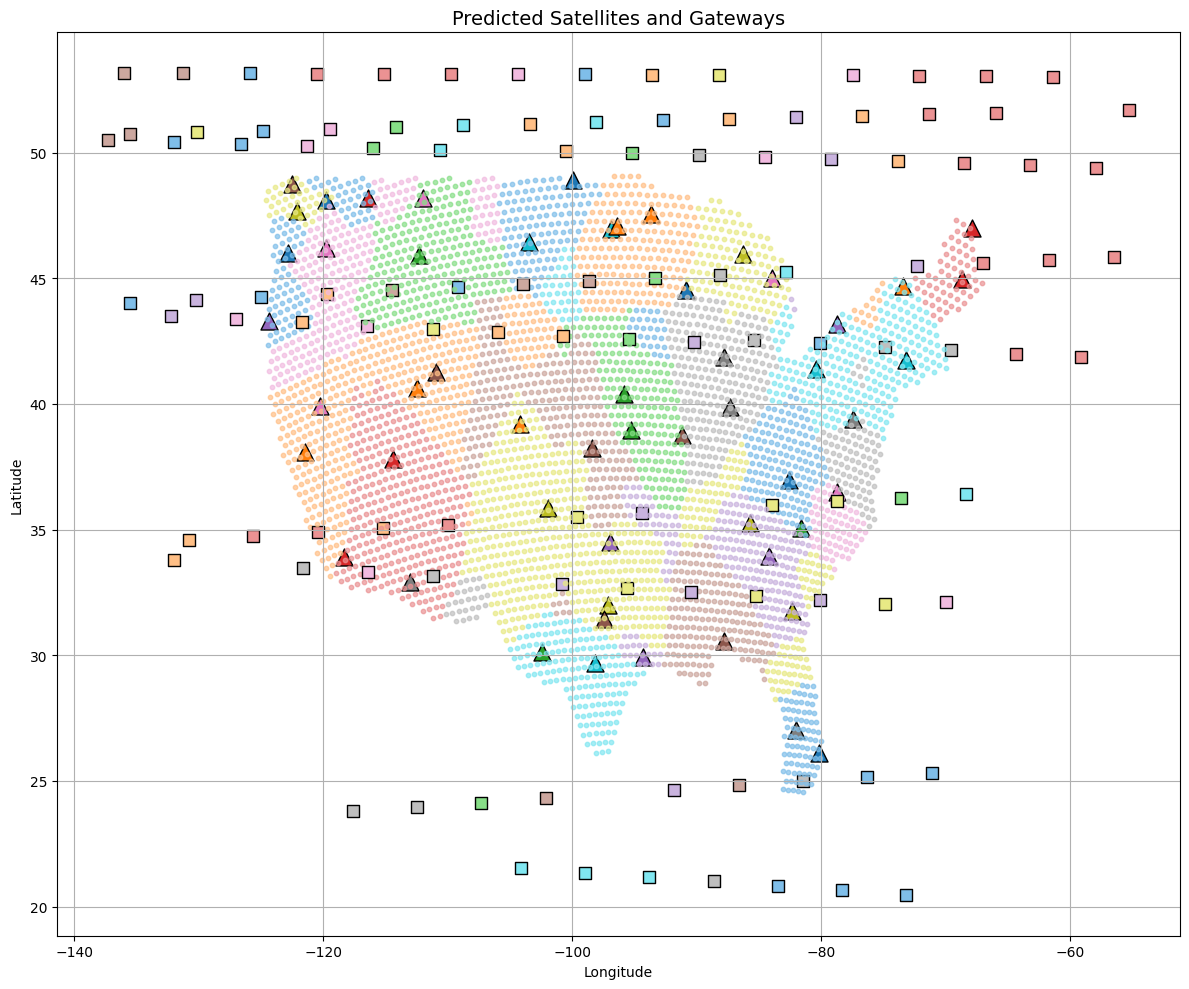

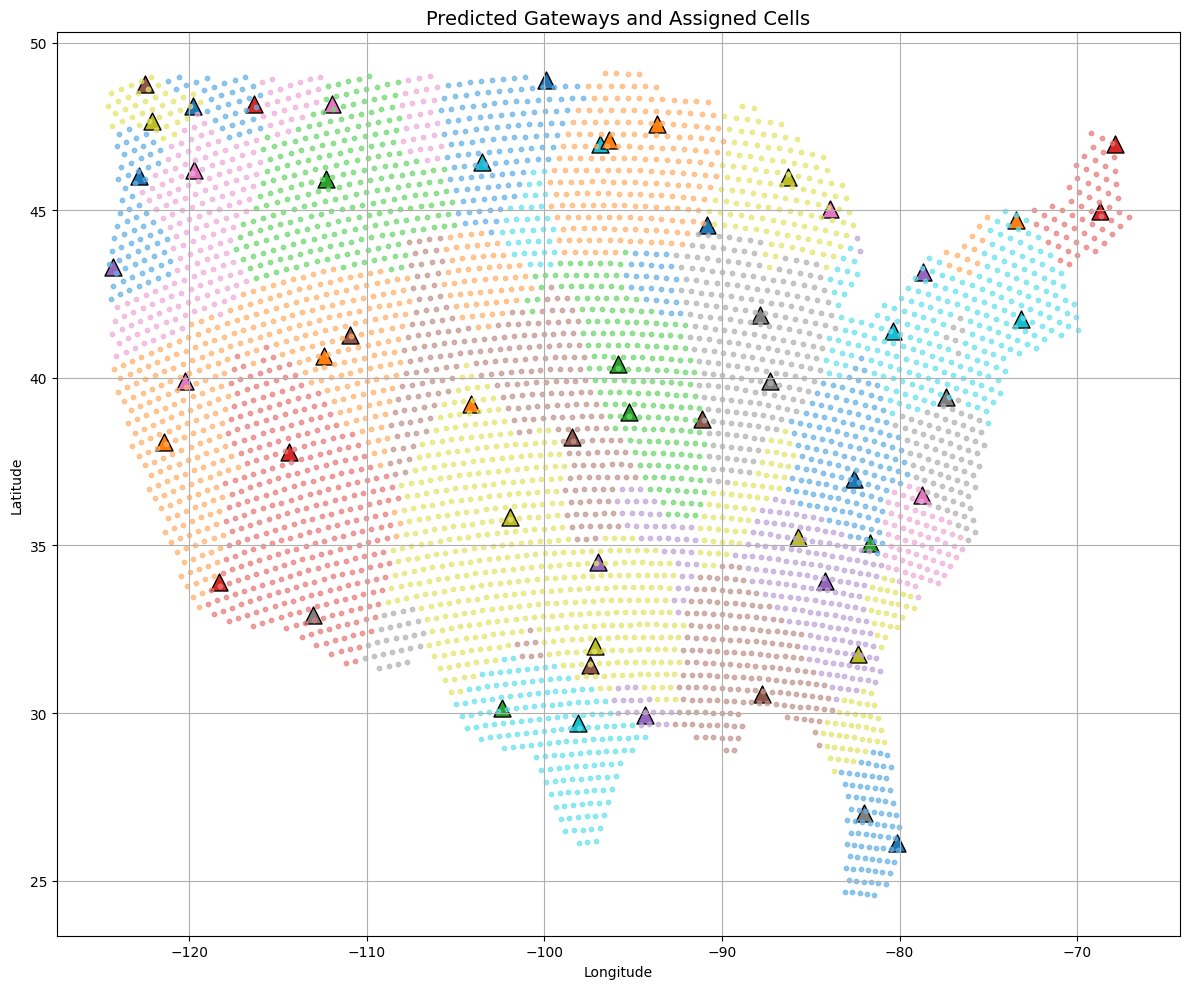

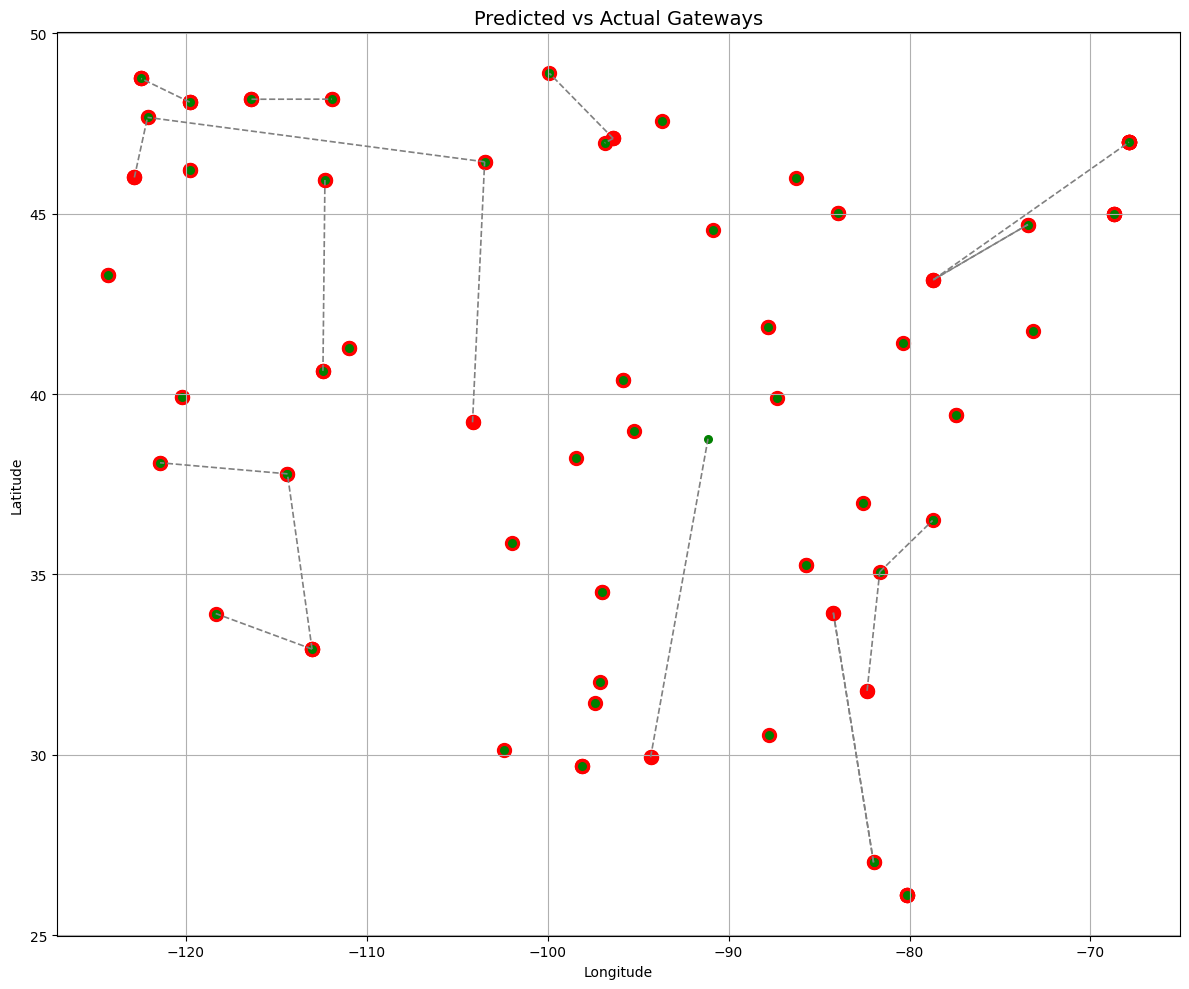

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# === Load Data ===
mapping_df = pd.read_csv("satellite_to_cells_mapping.csv")
cells_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv")
gw_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\df_gw.csv")
sat_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data\file_data_00_00_00.csv")
sat_df = sat_df.drop_duplicates(subset='feed_sat')

# === Setup Color Map ===
NUM_GATEWAYS = 54
base_colors = list(mcolors.TABLEAU_COLORS.values())
np.random.seed(42)
np.random.shuffle(base_colors)

gateway_color_map = {i: base_colors[i % len(base_colors)] for i in range(NUM_GATEWAYS)}

# === Helper: Lighter version of color ===
def lighten_color(color, amount=0.5):
    import colorsys
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    r, g, b = mcolors.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    r, g, b = colorsys.hls_to_rgb(h, min(1, l + amount * (1 - l)), s)
    return r, g, b

# === Parse list-like column ===
def parse_cells(cell_str):
    if isinstance(cell_str, str):
        return list(map(int, eval(cell_str)))
    return []

mapping_df['assigned_cells'] = mapping_df['assigned_cells'].apply(parse_cells)

# === Map 1: Predicted Satellites & Gateways ===
plt.figure(figsize=(12, 10))
for _, row in gw_df.iterrows():
    gw_id = row['gw_id']
    plt.scatter(row['longitude'], row['latitude'], marker='^',
                color=gateway_color_map.get(gw_id, 'gray'), edgecolor='black', s=150)

for _, row in mapping_df.iterrows():
    pred_gw = row['predicted_gateway']
    sat_id = row['unique_satellite_id']
    color = lighten_color(gateway_color_map.get(pred_gw, 'gray'), amount=0.5)
    sat_row = sat_df[sat_df['feed_sat'] == sat_id]
    if not sat_row.empty:
        lng, lat = sat_row.iloc[0][['Longitude', 'Latitude']]
        plt.scatter(lng, lat, marker='s', c=[color], edgecolor='black', s=80)

    for cell_idx in row['assigned_cells']:
        lng, lat = cells_df.loc[cell_idx, ['lng', 'lat']]
        plt.scatter(lng, lat, c=[color], s=10, alpha=0.7)

plt.title("Predicted Satellites and Gateways", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.savefig("map1_predicted_satellites_and_gateways.png", dpi=300)
plt.show()

# === Map 2: Predicted Gateways & Assigned Cells ===
plt.figure(figsize=(12, 10))
for _, row in gw_df.iterrows():
    gw_id = row['gw_id']
    plt.scatter(row['longitude'], row['latitude'], marker='^',
                color=gateway_color_map.get(gw_id, 'gray'), edgecolor='black', s=150)

for _, row in mapping_df.iterrows():
    pred_gw = row['predicted_gateway']
    color = lighten_color(gateway_color_map.get(pred_gw, 'gray'), amount=0.4)
    for cell_idx in row['assigned_cells']:
        lng, lat = cells_df.loc[cell_idx, ['lng', 'lat']]
        plt.scatter(lng, lat, c=[color], s=10, alpha=0.7)

plt.title("Predicted Gateways and Assigned Cells", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.savefig("map2_predicted_gateways_and_cells.png", dpi=300)
plt.show()

# === Map 3: Predicted vs Actual Gateways ===
plt.figure(figsize=(12, 10))
for _, row in mapping_df.iterrows():
    pred_gw = row['predicted_gateway']
    actual_gw = row['actual_gateway_id']

    pred_gw_row = gw_df[gw_df['gw_id'] == pred_gw]
    actual_gw_row = gw_df[gw_df['gw_id'] == actual_gw]

    if not pred_gw_row.empty and not actual_gw_row.empty:
        pred_lng, pred_lat = pred_gw_row.iloc[0][['longitude', 'latitude']]
        act_lng, act_lat = actual_gw_row.iloc[0][['longitude', 'latitude']]

        plt.scatter(pred_lng, pred_lat, color='red', s=100, label='Predicted Gateway')
        plt.scatter(act_lng, act_lat, color='green', s=30, label='Actual Gateway')
        plt.plot([pred_lng, act_lng], [pred_lat, act_lat], linestyle='--', color='gray', linewidth=1.2)

plt.title("Predicted vs Actual Gateways", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.savefig("map3_predicted_vs_actual_gateways.png", dpi=300)
plt.show()


5 files

In [33]:
import os
import glob
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import DataLoader
from tensorflow.keras.models import load_model
from collections import defaultdict, Counter

from dataloader import build_graph_from_file, prepare_input_for_gnn, NUM_GATEWAYS
from model import Stage2GNN

# === Paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cells_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv"
STAGE1_MODEL_PATH = 'stage_1_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model.pth'

# === Load Base Data ===
cells_df = pd.read_csv(cells_path)
total_cells = len(cells_df)
all_cell_indices = set(cells_df.index)

stage1_model = load_model(STAGE1_MODEL_PATH)

gnn_model = Stage2GNN(
    input_dim=3 + NUM_GATEWAYS * 3,
    sat_feature_dim=111,
    neighbor_feature_dim=NUM_GATEWAYS,
    hidden_dim=256,
    output_dim=NUM_GATEWAYS
)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# === File Selection ===
all_files = sorted(glob.glob(os.path.join(folder_path, '*.csv')))
selected_files = all_files[:8]  # pick first 5

# === Global Trackers ===
global_covered_cells = set()
coverage_results = []

# === Loop Over Files ===
for file_num, data_file in enumerate(selected_files, start=1):
    print(f"\n=== Processing File {file_num}: {os.path.basename(data_file)} ===")

    original_df = pd.read_csv(data_file)
    unique_sats = original_df['feed_sat'].drop_duplicates().reset_index(drop=True)
    feed_sat_to_id = {sat: idx for idx, sat in enumerate(unique_sats)}
    sat_to_indices = defaultdict(list)
    for row_idx, feed_sat in enumerate(original_df["feed_sat"]):
        sat_to_indices[feed_sat].append(row_idx)

    satellite_to_gateway = {}
    gateway_to_sats = defaultdict(list)
    cell_to_gateways = {}
    for idx, row in cells_df.iterrows():
        cell_to_gateways[idx] = [row["closest_gw_id"], row["second_closest_gw_id"]]

    graph = build_graph_from_file(data_file)
    data_loader = DataLoader([graph], batch_size=1)

    # === Model Inference ===
    top1_preds = []
    with torch.no_grad():
        for data in data_loader:
            input_features = data.x[:, :57].cpu().numpy()
            stage1_preds = stage1_model.predict(input_features, verbose=0)
            top3_indices = np.argsort(stage1_preds, axis=1)[:, -3:]

            binary_preds = np.zeros_like(stage1_preds)
            for i, idx in enumerate(top3_indices):
                binary_preds[i, idx] = 1

            gnn_input = prepare_input_for_gnn(data, torch.from_numpy(binary_preds).float())
            gnn_output = gnn_model(gnn_input.x, gnn_input.edge_index)
            top1_preds = torch.argmax(gnn_output, dim=1).cpu().numpy()

            for row_idx, gateway in enumerate(top1_preds):
                feed_sat = original_df.iloc[row_idx]["feed_sat"]
                satellite_to_gateway[feed_sat] = gateway
                gateway_to_sats[gateway].append(feed_sat)

    # === Fair Cell Assignment ===
    satellite_to_cells = defaultdict(list)
    assigned_cells = set()
    used_gateways = set()

    for gw, sats in gateway_to_sats.items():
        nearby_cells = cells_df[
            (cells_df["closest_gw_id"] == gw) | (cells_df["second_closest_gw_id"] == gw)
        ].index.tolist()

        if not sats or not nearby_cells:
            continue

        used_gateways.add(gw)
        sats = list(set(sats))
        n_sats = len(sats)
        cell_chunks = np.array_split(nearby_cells, n_sats)

        for sat, chunk in zip(sats, cell_chunks):
            for cell in chunk:
                if cell not in assigned_cells:
                    satellite_to_cells[sat].append(cell)
                    assigned_cells.add(cell)

    # === Track global coverage ===
    global_covered_cells.update(assigned_cells)
    file_coverage = len(assigned_cells) / total_cells * 100

    # === Summary ===
    total_unique_sats = len(unique_sats)
    assigned_sat_ids = set(satellite_to_cells.keys())
    unassigned_sat_ids = sorted(set(feed_sat_to_id.keys()) - assigned_sat_ids)
    all_gateways = set(range(NUM_GATEWAYS))
    unused_gateways = sorted(all_gateways - used_gateways)
    unassigned_cells = sorted(all_cell_indices - assigned_cells)

    print(f"Unique Satellites: {total_unique_sats}")
    print(f"Assigned Cells: {len(assigned_cells)} / {total_cells} ({file_coverage:.2f}% coverage)")
    print(f"Used Gateways: {len(used_gateways)} / {NUM_GATEWAYS}")
    print(f"Unassigned Cells: {len(unassigned_cells)}")
    
    coverage_results.append({
        "file": os.path.basename(data_file),
        "assigned_cells": len(assigned_cells),
        "coverage_percent": file_coverage
    })

    # === Optional: Export per-file results ===
    output_rows = []
    all_sat_ids = sorted(feed_sat_to_id.keys())
    for sat_feed_val in all_sat_ids:
        row_indices = sat_to_indices.get(sat_feed_val, [])
        predicted_gateways = [top1_preds[i] for i in row_indices if i < len(top1_preds)]
        most_common_gateway = Counter(predicted_gateways).most_common(1)[0][0] if predicted_gateways else None
        assigned = satellite_to_cells.get(sat_feed_val, [])
        assigned_clean = [int(cell) for cell in assigned]
        actual_gateway = original_df.loc[original_df["feed_sat"] == sat_feed_val, "gw"].iloc[0]
        actual_cell_ids = original_df.loc[original_df["feed_sat"] == sat_feed_val, "cell_id"].tolist()

        output_rows.append({
            "unique_satellite_id": sat_feed_val,
            "predicted_gateway": most_common_gateway,
            "actual_gateway_id": actual_gateway,
            "assigned_cells": assigned_clean,
            "actual_cell_ids": actual_cell_ids
        })

    output_df = pd.DataFrame(output_rows)
    output_csv_path = f"satellite_to_cells_mapping_file{file_num}.csv"
    output_df.to_csv(output_csv_path, index=False)

# === Global Coverage Summary ===
print("\n=== Global Summary Across 5 Files ===")
print(f"Total Unique Cells: {total_cells}")
print(f"Cells Covered In Any File: {len(global_covered_cells)}")
print(f"Overall Coverage: {len(global_covered_cells) / total_cells * 100:.2f}%")

global_unassigned_cells = sorted(all_cell_indices - global_covered_cells)


# === Print Per-File Coverage ===
print("\n=== Per-File Coverage Stats ===")
for result in coverage_results:
    print(f"{result['file']}: {result['assigned_cells']} cells covered ({result['coverage_percent']:.2f}%)")
# === Unassigned Cells Across All 5 Files ===
global_unassigned_cells = sorted(all_cell_indices - global_covered_cells)

print("\n=== Cells Never Assigned in Any of the 5 Files ===")
print(f"Total Unassigned Cells: {len(global_unassigned_cells)}")

print(f"Sample Unassigned Cell Indices: {global_unassigned_cells[:20]}")

# Optional: Save to CSV
unassigned_df = cells_df.loc[global_unassigned_cells].copy()
unassigned_df.to_csv("unassigned_cells_across_5_files.csv", index=False)
print("→ Unassigned cell info saved to: unassigned_cells_across_5_files.csv")



=== Processing File 1: file_data_00_00_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 112
Assigned Cells: 4296 / 4569 (94.02% coverage)
Used Gateways: 39 / 54
Unassigned Cells: 273

=== Processing File 2: file_data_00_00_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 108
Assigned Cells: 4504 / 4569 (98.58% coverage)
Used Gateways: 45 / 54
Unassigned Cells: 65

=== Processing File 3: file_data_00_00_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 107
Assigned Cells: 4306 / 4569 (94.24% coverage)
Used Gateways: 41 / 54
Unassigned Cells: 263

=== Processing File 4: file_data_00_01_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 106
Assigned Cells: 4334 / 4569 (94.86% coverage)
Used Gateways: 42 / 54
Unassigned Cells: 235

=== Processing File 5: file_data_00_01_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 106
Assigned Cells: 4176 / 4569 (91.40% coverage)
Used Gateways: 40 / 54
Unassigned Cells: 393

=== Processing File 6: file_data_00_01_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 107
Assigned Cells: 4210 / 4569 (92.14% coverage)
Used Gateways: 39 / 54
Unassigned Cells: 359

=== Processing File 7: file_data_00_02_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 109
Assigned Cells: 4528 / 4569 (99.10% coverage)
Used Gateways: 45 / 54
Unassigned Cells: 41

=== Processing File 8: file_data_00_02_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 107
Assigned Cells: 4487 / 4569 (98.21% coverage)
Used Gateways: 44 / 54
Unassigned Cells: 82

=== Global Summary Across 5 Files ===
Total Unique Cells: 4569
Cells Covered In Any File: 4552
Overall Coverage: 99.63%

=== Per-File Coverage Stats ===
file_data_00_00_00.csv: 4296 cells covered (94.02%)
file_data_00_00_20.csv: 4504 cells covered (98.58%)
file_data_00_00_40.csv: 4306 cells covered (94.24%)
file_data_00_01_00.csv: 4334 cells covered (94.86%)
file_data_00_01_20.csv: 4176 cells covered (91.40%)
file_data_00_01_40.csv: 4210 cells covered (92.14%)
file_data_00_02_00.csv: 4528 cells covered (99.10%)
file_data_00_02_20.csv: 4487 cells covered (98.21%)

=== Cells Never Assigned in Any of the 5 Files ===
Total Unassigned Cells: 17
Sample Unassigned Cell Indices: [294, 341, 972, 1185, 1821, 2225, 2382, 2458, 2666, 2827, 2861, 3039, 3054, 3255, 3381, 3474, 4073]
→ Unassigned cell info saved to: unassigned_cells_across_5_files.csv


In [34]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# === Base Paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cells_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv"
gw_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\df_gw.csv"

# === Load Static Data ===
cells_df = pd.read_csv(cells_path)
gw_df = pd.read_csv(gw_path)

NUM_GATEWAYS = 54
base_colors = list(mcolors.TABLEAU_COLORS.values())
np.random.seed(42)
np.random.shuffle(base_colors)
gateway_color_map = {i: base_colors[i % len(base_colors)] for i in range(NUM_GATEWAYS)}

# === Helpers ===
def lighten_color(color, amount=0.5):
    import colorsys
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    r, g, b = mcolors.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    r, g, b = colorsys.hls_to_rgb(h, min(1, l + amount * (1 - l)), s)
    return r, g, b

def parse_cells(cell_str):
    if isinstance(cell_str, str):
        return list(map(int, eval(cell_str)))
    return []

def get_time_filename(index):
    total_seconds = index * 20
    hh = total_seconds // 3600
    mm = (total_seconds % 3600) // 60
    ss = total_seconds % 60
    return f"file_data_{hh:02d}_{mm:02d}_{ss:02d}.csv"

# === Load Mapping Files ===
mapping_files = sorted(glob.glob("satellite_to_cells_mapping_file*.csv"))
selected_files = mapping_files[:5]

for idx, mapping_path in enumerate(selected_files):
    file_num = idx + 1
    print(f"\n=== Generating Maps for File {file_num} ===")

    # Load mapping + satellite file
    mapping_df = pd.read_csv(mapping_path)
    mapping_df['assigned_cells'] = mapping_df['assigned_cells'].apply(parse_cells)

    sat_file_name = get_time_filename(idx)
    sat_file_path = os.path.join(folder_path, sat_file_name)

    if not os.path.exists(sat_file_path):
        print(f"⚠️ Satellite file not found: {sat_file_path}")
        continue

    sat_df = pd.read_csv(sat_file_path).drop_duplicates(subset='feed_sat')

    # === Map 1: Predicted Satellites & Gateways ===
    plt.figure(figsize=(12, 10))
    for _, row in gw_df.iterrows():
        plt.scatter(row['longitude'], row['latitude'], marker='^',
                    color=gateway_color_map.get(row['gw_id'], 'gray'), s=150, edgecolors='k')

    for _, row in mapping_df.iterrows():
        pred_gw = row['predicted_gateway']
        sat_id = row['unique_satellite_id']
        color = lighten_color(gateway_color_map.get(pred_gw, 'gray'), amount=0.5)

        sat_row = sat_df[sat_df['feed_sat'] == sat_id]
        if not sat_row.empty:
            lng, lat = sat_row.iloc[0][['Longitude', 'Latitude']]
            plt.scatter(lng, lat, marker='s', c=[color], edgecolors='k', s=80)

        for cell_idx in row['assigned_cells']:
            lng, lat = cells_df.loc[cell_idx, ['lng', 'lat']]
            plt.scatter(lng, lat, c=[color], s=10, alpha=0.7)

    plt.title(f"Map 1 - Predicted Satellites and Gateways (File {file_num})", fontsize=14)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"map1_file{file_num}_predicted_satellites_and_gateways.png", dpi=300)
    plt.close()

    # === Map 2: Predicted Gateways & Assigned Cells ===
    plt.figure(figsize=(12, 10))
    for _, row in gw_df.iterrows():
        plt.scatter(row['longitude'], row['latitude'], marker='^',
                    color=gateway_color_map.get(row['gw_id'], 'gray'), s=150, edgecolors='k')

    for _, row in mapping_df.iterrows():
        pred_gw = row['predicted_gateway']
        color = lighten_color(gateway_color_map.get(pred_gw, 'gray'), amount=0.4)
        for cell_idx in row['assigned_cells']:
            lng, lat = cells_df.loc[cell_idx, ['lng', 'lat']]
            plt.scatter(lng, lat, c=[color], s=10, alpha=0.7)

    plt.title(f"Map 2 - Predicted Gateways and Cells (File {file_num})", fontsize=14)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"map2_file{file_num}_predicted_gateways_and_cells.png", dpi=300)
    plt.close()

    # === Map 3: Predicted vs Actual Gateways ===
    plt.figure(figsize=(12, 10))
    for _, row in mapping_df.iterrows():
        pred_gw = row['predicted_gateway']
        actual_gw = row['actual_gateway_id']

        pred_gw_row = gw_df[gw_df['gw_id'] == pred_gw]
        actual_gw_row = gw_df[gw_df['gw_id'] == actual_gw]

        if not pred_gw_row.empty and not actual_gw_row.empty:
            pred_lng, pred_lat = pred_gw_row.iloc[0][['longitude', 'latitude']]
            act_lng, act_lat = actual_gw_row.iloc[0][['longitude', 'latitude']]

            plt.scatter(pred_lng, pred_lat, color='red', s=100)
            plt.scatter(act_lng, act_lat, color='green', s=30)
            plt.plot([pred_lng, act_lng], [pred_lat, act_lat], linestyle='--', color='gray', linewidth=1.2)

    plt.title(f"Map 3 - Predicted vs Actual Gateways (File {file_num})", fontsize=14)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"map3_file{file_num}_predicted_vs_actual_gateways.png", dpi=300)
    plt.close()

print("\nAll maps generated for selected files.")



=== Generating Maps for File 1 ===

=== Generating Maps for File 2 ===

=== Generating Maps for File 3 ===

=== Generating Maps for File 4 ===

=== Generating Maps for File 5 ===

All maps generated for selected files.


In [3]:
import os
import glob
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import DataLoader
from tensorflow.keras.models import load_model
from collections import defaultdict, Counter

from dataloader import build_graph_from_file, prepare_input_for_gnn, NUM_GATEWAYS
from model import Stage2GNN

# === Paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cells_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv"
STAGE1_MODEL_PATH = 'stage_1_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model.pth'

# === Load Base Data ===
cells_df = pd.read_csv(cells_path)
total_cells = len(cells_df)
all_cell_indices = set(cells_df.index)

stage1_model = load_model(STAGE1_MODEL_PATH)

gnn_model = Stage2GNN(
    input_dim=3 + NUM_GATEWAYS * 3,
    sat_feature_dim=111,
    neighbor_feature_dim=NUM_GATEWAYS,
    hidden_dim=256,
    output_dim=NUM_GATEWAYS
)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# === File Selection ===
all_files = sorted(glob.glob(os.path.join(folder_path, '*.csv')))
total_files = len(all_files)

# === Trackers ===
covered_cells = set()
file_idx = 0
coverage_sets = []
set_counter = 1

while file_idx < total_files:
    batch_files = all_files[file_idx:file_idx + 10]
    batch_covered_cells = set()
    batch_coverage_results = []
    batch_output_data = []

    print(f"\n=== Starting Coverage Set {set_counter} ===")

    for batch_file_offset, data_file in enumerate(batch_files):
        file_num = file_idx + batch_file_offset + 1
        print(f"\n=== Processing File {file_num}: {os.path.basename(data_file)} ===")

        original_df = pd.read_csv(data_file)
        unique_sats = original_df['feed_sat'].drop_duplicates().reset_index(drop=True)
        feed_sat_to_id = {sat: idx for idx, sat in enumerate(unique_sats)}
        sat_to_indices = defaultdict(list)
        for row_idx, feed_sat in enumerate(original_df["feed_sat"]):
            sat_to_indices[feed_sat].append(row_idx)

        satellite_to_gateway = {}
        gateway_to_sats = defaultdict(list)
        cell_to_gateways = {}
        for idx, row in cells_df.iterrows():
            cell_to_gateways[idx] = [row["closest_gw_id"], row["second_closest_gw_id"]]

        graph = build_graph_from_file(data_file)
        data_loader = DataLoader([graph], batch_size=1)

        top1_preds = []
        with torch.no_grad():
            for data in data_loader:
                input_features = data.x[:, :57].cpu().numpy()
                stage1_preds = stage1_model.predict(input_features, verbose=0)
                top3_indices = np.argsort(stage1_preds, axis=1)[:, -3:]

                binary_preds = np.zeros_like(stage1_preds)
                for i, idx in enumerate(top3_indices):
                    binary_preds[i, idx] = 1

                gnn_input = prepare_input_for_gnn(data, torch.from_numpy(binary_preds).float())
                gnn_output = gnn_model(gnn_input.x, gnn_input.edge_index)
                top1_preds = torch.argmax(gnn_output, dim=1).cpu().numpy()

                for row_idx, gateway in enumerate(top1_preds):
                    feed_sat = original_df.iloc[row_idx]["feed_sat"]
                    satellite_to_gateway[feed_sat] = gateway
                    gateway_to_sats[gateway].append(feed_sat)

        satellite_to_cells = defaultdict(list)
        assigned_cells = set()
        used_gateways = set()

        for gw, sats in gateway_to_sats.items():
            nearby_cells = cells_df[
                (cells_df["closest_gw_id"] == gw) | (cells_df["second_closest_gw_id"] == gw)
            ].index.tolist()

            if not sats or not nearby_cells:
                continue

            used_gateways.add(gw)
            sats = list(set(sats))
            n_sats = len(sats)
            cell_chunks = np.array_split(nearby_cells, n_sats)

            for sat, chunk in zip(sats, cell_chunks):
                for cell in chunk:
                    if cell not in assigned_cells:
                        satellite_to_cells[sat].append(cell)
                        assigned_cells.add(cell)

        batch_covered_cells.update(assigned_cells)

        file_coverage = len(assigned_cells) / total_cells * 100
        print(f"Assigned Cells: {len(assigned_cells)} / {total_cells} ({file_coverage:.2f}%)")

        batch_coverage_results.append({
            "file": os.path.basename(data_file),
            "assigned_cells": len(assigned_cells),
            "coverage_percent": file_coverage
        })

        # Save per-file mapping info
        output_rows = []
        for sat_feed_val in feed_sat_to_id.keys():
            row_indices = sat_to_indices.get(sat_feed_val, [])
            predicted_gateways = [top1_preds[i] for i in row_indices if i < len(top1_preds)]
            most_common_gateway = Counter(predicted_gateways).most_common(1)[0][0] if predicted_gateways else None
            assigned = satellite_to_cells.get(sat_feed_val, [])
            assigned_clean = [int(cell) for cell in assigned]
            actual_gateway = original_df.loc[original_df["feed_sat"] == sat_feed_val, "gw"].iloc[0]
            actual_cell_ids = original_df.loc[original_df["feed_sat"] == sat_feed_val, "cell_id"].tolist()

            output_rows.append({
                "unique_satellite_id": sat_feed_val,
                "predicted_gateway": most_common_gateway,
                "actual_gateway_id": actual_gateway,
                "assigned_cells": assigned_clean,
                "actual_cell_ids": actual_cell_ids
            })

        batch_output_data.append((file_num, output_rows))

        if len(batch_covered_cells) == total_cells:
            break  # 100% coverage reached

    # Save mapping for this batch
    for file_num, output_rows in batch_output_data:
        output_df = pd.DataFrame(output_rows)
        output_csv_path = f"set{set_counter}_satellite_to_cells_mapping_file{file_num}.csv"
        output_df.to_csv(output_csv_path, index=False)

    # Save coverage summary for the batch
    print(f"\n=== Set {set_counter} Summary ===")
    print(f"Files in Set: {[r['file'] for r in batch_coverage_results]}")
    print(f"Set {set_counter} Covered Cells: {len(batch_covered_cells)} / {total_cells}")
    print(f"Set {set_counter} Coverage: {len(batch_covered_cells) / total_cells * 100:.2f}%\n")

    coverage_sets.append({
        "set_number": set_counter,
        "files": [r['file'] for r in batch_coverage_results],
        "coverage_percent": len(batch_covered_cells) / total_cells * 100
    })

    file_idx += len(batch_coverage_results)
    set_counter += 1

# === Global Coverage Summary ===
print("\n=== Overall Summary ===")
for s in coverage_sets:
    print(f"Set {s['set_number']}: {s['coverage_percent']:.2f}% coverage with files {s['files']}")



=== Starting Coverage Set 1 ===

=== Processing File 1: file_data_00_00_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4296 / 4569 (94.02%)

=== Processing File 2: file_data_00_00_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4504 / 4569 (98.58%)

=== Processing File 3: file_data_00_00_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4306 / 4569 (94.24%)

=== Processing File 4: file_data_00_01_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4334 / 4569 (94.86%)

=== Processing File 5: file_data_00_01_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4176 / 4569 (91.40%)

=== Processing File 6: file_data_00_01_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4210 / 4569 (92.14%)

=== Processing File 7: file_data_00_02_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4528 / 4569 (99.10%)

=== Processing File 8: file_data_00_02_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4487 / 4569 (98.21%)

=== Processing File 9: file_data_00_02_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4472 / 4569 (97.88%)

=== Set 1 Summary ===
Files in Set: ['file_data_00_00_00.csv', 'file_data_00_00_20.csv', 'file_data_00_00_40.csv', 'file_data_00_01_00.csv', 'file_data_00_01_20.csv', 'file_data_00_01_40.csv', 'file_data_00_02_00.csv', 'file_data_00_02_20.csv', 'file_data_00_02_40.csv']
Set 1 Covered Cells: 4569 / 4569
Set 1 Coverage: 100.00%


=== Starting Coverage Set 2 ===

=== Processing File 10: file_data_00_03_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4303 / 4569 (94.18%)

=== Processing File 11: file_data_00_03_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4431 / 4569 (96.98%)

=== Processing File 12: file_data_00_03_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4266 / 4569 (93.37%)

=== Processing File 13: file_data_00_04_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4325 / 4569 (94.66%)

=== Processing File 14: file_data_00_04_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4488 / 4569 (98.23%)

=== Processing File 15: file_data_00_04_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4450 / 4569 (97.40%)

=== Set 2 Summary ===
Files in Set: ['file_data_00_03_00.csv', 'file_data_00_03_20.csv', 'file_data_00_03_40.csv', 'file_data_00_04_00.csv', 'file_data_00_04_20.csv', 'file_data_00_04_40.csv']
Set 2 Covered Cells: 4569 / 4569
Set 2 Coverage: 100.00%


=== Starting Coverage Set 3 ===

=== Processing File 16: file_data_00_05_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4402 / 4569 (96.34%)

=== Processing File 17: file_data_00_05_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4427 / 4569 (96.89%)

=== Processing File 18: file_data_00_05_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4216 / 4569 (92.27%)

=== Processing File 19: file_data_00_06_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4297 / 4569 (94.05%)

=== Set 3 Summary ===
Files in Set: ['file_data_00_05_00.csv', 'file_data_00_05_20.csv', 'file_data_00_05_40.csv', 'file_data_00_06_00.csv']
Set 3 Covered Cells: 4569 / 4569
Set 3 Coverage: 100.00%


=== Starting Coverage Set 4 ===

=== Processing File 20: file_data_00_06_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4542 / 4569 (99.41%)

=== Processing File 21: file_data_00_06_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4487 / 4569 (98.21%)

=== Set 4 Summary ===
Files in Set: ['file_data_00_06_20.csv', 'file_data_00_06_40.csv']
Set 4 Covered Cells: 4569 / 4569
Set 4 Coverage: 100.00%


=== Starting Coverage Set 5 ===

=== Processing File 22: file_data_00_07_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4486 / 4569 (98.18%)

=== Processing File 23: file_data_00_07_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4217 / 4569 (92.30%)

=== Processing File 24: file_data_00_07_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4308 / 4569 (94.29%)

=== Processing File 25: file_data_00_08_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4231 / 4569 (92.60%)

=== Set 5 Summary ===
Files in Set: ['file_data_00_07_00.csv', 'file_data_00_07_20.csv', 'file_data_00_07_40.csv', 'file_data_00_08_00.csv']
Set 5 Covered Cells: 4569 / 4569
Set 5 Coverage: 100.00%


=== Starting Coverage Set 6 ===

=== Processing File 26: file_data_00_08_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4318 / 4569 (94.51%)

=== Processing File 27: file_data_00_08_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4439 / 4569 (97.15%)

=== Processing File 28: file_data_00_09_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4401 / 4569 (96.32%)

=== Set 6 Summary ===
Files in Set: ['file_data_00_08_20.csv', 'file_data_00_08_40.csv', 'file_data_00_09_00.csv']
Set 6 Covered Cells: 4569 / 4569
Set 6 Coverage: 100.00%


=== Starting Coverage Set 7 ===

=== Processing File 29: file_data_00_09_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4459 / 4569 (97.59%)

=== Processing File 30: file_data_00_09_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4491 / 4569 (98.29%)

=== Set 7 Summary ===
Files in Set: ['file_data_00_09_20.csv', 'file_data_00_09_40.csv']
Set 7 Covered Cells: 4569 / 4569
Set 7 Coverage: 100.00%


=== Starting Coverage Set 8 ===

=== Processing File 31: file_data_00_10_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4482 / 4569 (98.10%)

=== Processing File 32: file_data_00_10_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4481 / 4569 (98.07%)

=== Processing File 33: file_data_00_10_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4348 / 4569 (95.16%)

=== Processing File 34: file_data_00_11_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4379 / 4569 (95.84%)

=== Set 8 Summary ===
Files in Set: ['file_data_00_10_00.csv', 'file_data_00_10_20.csv', 'file_data_00_10_40.csv', 'file_data_00_11_00.csv']
Set 8 Covered Cells: 4569 / 4569
Set 8 Coverage: 100.00%


=== Starting Coverage Set 9 ===

=== Processing File 35: file_data_00_11_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4484 / 4569 (98.14%)

=== Processing File 36: file_data_00_11_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4304 / 4569 (94.20%)

=== Processing File 37: file_data_00_12_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4414 / 4569 (96.61%)

=== Processing File 38: file_data_00_12_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4416 / 4569 (96.65%)

=== Processing File 39: file_data_00_12_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4129 / 4569 (90.37%)

=== Processing File 40: file_data_00_13_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4349 / 4569 (95.18%)

=== Set 9 Summary ===
Files in Set: ['file_data_00_11_20.csv', 'file_data_00_11_40.csv', 'file_data_00_12_00.csv', 'file_data_00_12_20.csv', 'file_data_00_12_40.csv', 'file_data_00_13_00.csv']
Set 9 Covered Cells: 4569 / 4569
Set 9 Coverage: 100.00%


=== Starting Coverage Set 10 ===

=== Processing File 41: file_data_00_13_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4338 / 4569 (94.94%)

=== Processing File 42: file_data_00_13_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4449 / 4569 (97.37%)

=== Processing File 43: file_data_00_14_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4446 / 4569 (97.31%)

=== Processing File 44: file_data_00_14_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4462 / 4569 (97.66%)

=== Set 10 Summary ===
Files in Set: ['file_data_00_13_20.csv', 'file_data_00_13_40.csv', 'file_data_00_14_00.csv', 'file_data_00_14_20.csv']
Set 10 Covered Cells: 4569 / 4569
Set 10 Coverage: 100.00%


=== Starting Coverage Set 11 ===

=== Processing File 45: file_data_00_14_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4287 / 4569 (93.83%)

=== Processing File 46: file_data_00_15_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4168 / 4569 (91.22%)

=== Processing File 47: file_data_00_15_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4149 / 4569 (90.81%)

=== Processing File 48: file_data_00_15_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4426 / 4569 (96.87%)

=== Processing File 49: file_data_00_16_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4449 / 4569 (97.37%)

=== Set 11 Summary ===
Files in Set: ['file_data_00_14_40.csv', 'file_data_00_15_00.csv', 'file_data_00_15_20.csv', 'file_data_00_15_40.csv', 'file_data_00_16_00.csv']
Set 11 Covered Cells: 4569 / 4569
Set 11 Coverage: 100.00%


=== Starting Coverage Set 12 ===

=== Processing File 50: file_data_00_16_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4450 / 4569 (97.40%)

=== Processing File 51: file_data_00_16_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4248 / 4569 (92.97%)

=== Processing File 52: file_data_00_17_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4423 / 4569 (96.80%)

=== Processing File 53: file_data_00_17_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4174 / 4569 (91.35%)

=== Set 12 Summary ===
Files in Set: ['file_data_00_16_20.csv', 'file_data_00_16_40.csv', 'file_data_00_17_00.csv', 'file_data_00_17_20.csv']
Set 12 Covered Cells: 4569 / 4569
Set 12 Coverage: 100.00%


=== Starting Coverage Set 13 ===

=== Processing File 54: file_data_00_17_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3964 / 4569 (86.76%)

=== Processing File 55: file_data_00_18_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4415 / 4569 (96.63%)

=== Processing File 56: file_data_00_18_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4270 / 4569 (93.46%)

=== Processing File 57: file_data_00_18_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4438 / 4569 (97.13%)

=== Processing File 58: file_data_00_19_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4333 / 4569 (94.83%)

=== Processing File 59: file_data_00_19_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4105 / 4569 (89.84%)

=== Processing File 60: file_data_00_19_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4182 / 4569 (91.53%)

=== Processing File 61: file_data_00_20_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4305 / 4569 (94.22%)

=== Processing File 62: file_data_00_20_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4527 / 4569 (99.08%)

=== Processing File 63: file_data_00_20_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4392 / 4569 (96.13%)

=== Set 13 Summary ===
Files in Set: ['file_data_00_17_40.csv', 'file_data_00_18_00.csv', 'file_data_00_18_20.csv', 'file_data_00_18_40.csv', 'file_data_00_19_00.csv', 'file_data_00_19_20.csv', 'file_data_00_19_40.csv', 'file_data_00_20_00.csv', 'file_data_00_20_20.csv', 'file_data_00_20_40.csv']
Set 13 Covered Cells: 4552 / 4569
Set 13 Coverage: 99.63%


=== Starting Coverage Set 14 ===

=== Processing File 64: file_data_00_21_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4368 / 4569 (95.60%)

=== Processing File 65: file_data_00_21_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4173 / 4569 (91.33%)

=== Processing File 66: file_data_00_21_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4242 / 4569 (92.84%)

=== Processing File 67: file_data_00_22_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4003 / 4569 (87.61%)

=== Processing File 68: file_data_00_22_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4304 / 4569 (94.20%)

=== Processing File 69: file_data_00_22_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4414 / 4569 (96.61%)

=== Processing File 70: file_data_00_23_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4528 / 4569 (99.10%)

=== Set 14 Summary ===
Files in Set: ['file_data_00_21_00.csv', 'file_data_00_21_20.csv', 'file_data_00_21_40.csv', 'file_data_00_22_00.csv', 'file_data_00_22_20.csv', 'file_data_00_22_40.csv', 'file_data_00_23_00.csv']
Set 14 Covered Cells: 4569 / 4569
Set 14 Coverage: 100.00%


=== Starting Coverage Set 15 ===

=== Processing File 71: file_data_00_23_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4409 / 4569 (96.50%)

=== Processing File 72: file_data_00_23_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4213 / 4569 (92.21%)

=== Processing File 73: file_data_00_24_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4421 / 4569 (96.76%)

=== Processing File 74: file_data_00_24_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4402 / 4569 (96.34%)

=== Set 15 Summary ===
Files in Set: ['file_data_00_23_20.csv', 'file_data_00_23_40.csv', 'file_data_00_24_00.csv', 'file_data_00_24_20.csv']
Set 15 Covered Cells: 4569 / 4569
Set 15 Coverage: 100.00%


=== Starting Coverage Set 16 ===

=== Processing File 75: file_data_00_24_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4517 / 4569 (98.86%)

=== Processing File 76: file_data_00_25_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4523 / 4569 (98.99%)

=== Processing File 77: file_data_00_25_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4222 / 4569 (92.41%)

=== Set 16 Summary ===
Files in Set: ['file_data_00_24_40.csv', 'file_data_00_25_00.csv', 'file_data_00_25_20.csv']
Set 16 Covered Cells: 4569 / 4569
Set 16 Coverage: 100.00%


=== Starting Coverage Set 17 ===

=== Processing File 78: file_data_00_25_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4314 / 4569 (94.42%)

=== Processing File 79: file_data_00_26_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4133 / 4569 (90.46%)

=== Processing File 80: file_data_00_26_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4423 / 4569 (96.80%)

=== Processing File 81: file_data_00_26_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4309 / 4569 (94.31%)

=== Processing File 82: file_data_00_27_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4529 / 4569 (99.12%)

=== Set 17 Summary ===
Files in Set: ['file_data_00_25_40.csv', 'file_data_00_26_00.csv', 'file_data_00_26_20.csv', 'file_data_00_26_40.csv', 'file_data_00_27_00.csv']
Set 17 Covered Cells: 4569 / 4569
Set 17 Coverage: 100.00%


=== Starting Coverage Set 18 ===

=== Processing File 83: file_data_00_27_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4354 / 4569 (95.29%)

=== Processing File 84: file_data_00_27_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4322 / 4569 (94.59%)

=== Processing File 85: file_data_00_28_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4367 / 4569 (95.58%)

=== Processing File 86: file_data_00_28_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4499 / 4569 (98.47%)

=== Set 18 Summary ===
Files in Set: ['file_data_00_27_20.csv', 'file_data_00_27_40.csv', 'file_data_00_28_00.csv', 'file_data_00_28_20.csv']
Set 18 Covered Cells: 4569 / 4569
Set 18 Coverage: 100.00%


=== Starting Coverage Set 19 ===

=== Processing File 87: file_data_00_28_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4483 / 4569 (98.12%)

=== Processing File 88: file_data_00_29_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4431 / 4569 (96.98%)

=== Processing File 89: file_data_00_29_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4409 / 4569 (96.50%)

=== Processing File 90: file_data_00_29_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4388 / 4569 (96.04%)

=== Set 19 Summary ===
Files in Set: ['file_data_00_28_40.csv', 'file_data_00_29_00.csv', 'file_data_00_29_20.csv', 'file_data_00_29_40.csv']
Set 19 Covered Cells: 4569 / 4569
Set 19 Coverage: 100.00%


=== Starting Coverage Set 20 ===

=== Processing File 91: file_data_00_30_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4504 / 4569 (98.58%)

=== Processing File 92: file_data_00_30_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4203 / 4569 (91.99%)

=== Processing File 93: file_data_00_30_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4261 / 4569 (93.26%)

=== Processing File 94: file_data_00_31_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4308 / 4569 (94.29%)

=== Processing File 95: file_data_00_31_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4225 / 4569 (92.47%)

=== Processing File 96: file_data_00_31_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4134 / 4569 (90.48%)

=== Processing File 97: file_data_00_32_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4054 / 4569 (88.73%)

=== Processing File 98: file_data_00_32_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4371 / 4569 (95.67%)

=== Processing File 99: file_data_00_32_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4389 / 4569 (96.06%)

=== Processing File 100: file_data_00_33_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4278 / 4569 (93.63%)

=== Set 20 Summary ===
Files in Set: ['file_data_00_30_00.csv', 'file_data_00_30_20.csv', 'file_data_00_30_40.csv', 'file_data_00_31_00.csv', 'file_data_00_31_20.csv', 'file_data_00_31_40.csv', 'file_data_00_32_00.csv', 'file_data_00_32_20.csv', 'file_data_00_32_40.csv', 'file_data_00_33_00.csv']
Set 20 Covered Cells: 4569 / 4569
Set 20 Coverage: 100.00%


=== Starting Coverage Set 21 ===

=== Processing File 101: file_data_00_33_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4191 / 4569 (91.73%)

=== Processing File 102: file_data_00_33_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4270 / 4569 (93.46%)

=== Processing File 103: file_data_00_34_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4426 / 4569 (96.87%)

=== Set 21 Summary ===
Files in Set: ['file_data_00_33_20.csv', 'file_data_00_33_40.csv', 'file_data_00_34_00.csv']
Set 21 Covered Cells: 4569 / 4569
Set 21 Coverage: 100.00%


=== Starting Coverage Set 22 ===

=== Processing File 104: file_data_00_34_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4354 / 4569 (95.29%)

=== Processing File 105: file_data_00_34_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4527 / 4569 (99.08%)

=== Processing File 106: file_data_00_35_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4295 / 4569 (94.00%)

=== Processing File 107: file_data_00_35_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4297 / 4569 (94.05%)

=== Processing File 108: file_data_00_35_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4316 / 4569 (94.46%)

=== Processing File 109: file_data_00_36_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4424 / 4569 (96.83%)

=== Processing File 110: file_data_00_36_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4239 / 4569 (92.78%)

=== Processing File 111: file_data_00_36_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4521 / 4569 (98.95%)

=== Set 22 Summary ===
Files in Set: ['file_data_00_34_20.csv', 'file_data_00_34_40.csv', 'file_data_00_35_00.csv', 'file_data_00_35_20.csv', 'file_data_00_35_40.csv', 'file_data_00_36_00.csv', 'file_data_00_36_20.csv', 'file_data_00_36_40.csv']
Set 22 Covered Cells: 4569 / 4569
Set 22 Coverage: 100.00%


=== Starting Coverage Set 23 ===

=== Processing File 112: file_data_00_37_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4433 / 4569 (97.02%)

=== Processing File 113: file_data_00_37_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4041 / 4569 (88.44%)

=== Processing File 114: file_data_00_37_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4226 / 4569 (92.49%)

=== Processing File 115: file_data_00_38_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4371 / 4569 (95.67%)

=== Processing File 116: file_data_00_38_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4285 / 4569 (93.78%)

=== Processing File 117: file_data_00_38_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4494 / 4569 (98.36%)

=== Processing File 118: file_data_00_39_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4355 / 4569 (95.32%)

=== Processing File 119: file_data_00_39_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4180 / 4569 (91.49%)

=== Processing File 120: file_data_00_39_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4203 / 4569 (91.99%)

=== Processing File 121: file_data_00_40_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4365 / 4569 (95.54%)

=== Set 23 Summary ===
Files in Set: ['file_data_00_37_00.csv', 'file_data_00_37_20.csv', 'file_data_00_37_40.csv', 'file_data_00_38_00.csv', 'file_data_00_38_20.csv', 'file_data_00_38_40.csv', 'file_data_00_39_00.csv', 'file_data_00_39_20.csv', 'file_data_00_39_40.csv', 'file_data_00_40_00.csv']
Set 23 Covered Cells: 4552 / 4569
Set 23 Coverage: 99.63%


=== Starting Coverage Set 24 ===

=== Processing File 122: file_data_00_40_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4287 / 4569 (93.83%)

=== Processing File 123: file_data_00_40_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4414 / 4569 (96.61%)

=== Processing File 124: file_data_00_41_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4280 / 4569 (93.67%)

=== Processing File 125: file_data_00_41_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4213 / 4569 (92.21%)

=== Processing File 126: file_data_00_41_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4242 / 4569 (92.84%)

=== Processing File 127: file_data_00_42_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4426 / 4569 (96.87%)

=== Set 24 Summary ===
Files in Set: ['file_data_00_40_20.csv', 'file_data_00_40_40.csv', 'file_data_00_41_00.csv', 'file_data_00_41_20.csv', 'file_data_00_41_40.csv', 'file_data_00_42_00.csv']
Set 24 Covered Cells: 4569 / 4569
Set 24 Coverage: 100.00%


=== Starting Coverage Set 25 ===

=== Processing File 128: file_data_00_42_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4528 / 4569 (99.10%)

=== Processing File 129: file_data_00_42_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4388 / 4569 (96.04%)

=== Processing File 130: file_data_00_43_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4351 / 4569 (95.23%)

=== Processing File 131: file_data_00_43_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4431 / 4569 (96.98%)

=== Processing File 132: file_data_00_43_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4250 / 4569 (93.02%)

=== Processing File 133: file_data_00_44_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4154 / 4569 (90.92%)

=== Processing File 134: file_data_00_44_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4385 / 4569 (95.97%)

=== Set 25 Summary ===
Files in Set: ['file_data_00_42_20.csv', 'file_data_00_42_40.csv', 'file_data_00_43_00.csv', 'file_data_00_43_20.csv', 'file_data_00_43_40.csv', 'file_data_00_44_00.csv', 'file_data_00_44_20.csv']
Set 25 Covered Cells: 4569 / 4569
Set 25 Coverage: 100.00%


=== Starting Coverage Set 26 ===

=== Processing File 135: file_data_00_44_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4399 / 4569 (96.28%)

=== Processing File 136: file_data_00_45_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4482 / 4569 (98.10%)

=== Processing File 137: file_data_00_45_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4475 / 4569 (97.94%)

=== Set 26 Summary ===
Files in Set: ['file_data_00_44_40.csv', 'file_data_00_45_00.csv', 'file_data_00_45_20.csv']
Set 26 Covered Cells: 4569 / 4569
Set 26 Coverage: 100.00%


=== Starting Coverage Set 27 ===

=== Processing File 138: file_data_00_45_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4363 / 4569 (95.49%)

=== Processing File 139: file_data_00_46_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4308 / 4569 (94.29%)

=== Processing File 140: file_data_00_46_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4362 / 4569 (95.47%)

=== Processing File 141: file_data_00_46_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4338 / 4569 (94.94%)

=== Processing File 142: file_data_00_47_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4482 / 4569 (98.10%)

=== Processing File 143: file_data_00_47_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4376 / 4569 (95.78%)

=== Processing File 144: file_data_00_47_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4308 / 4569 (94.29%)

=== Processing File 145: file_data_00_48_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4308 / 4569 (94.29%)

=== Processing File 146: file_data_00_48_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4225 / 4569 (92.47%)

=== Processing File 147: file_data_00_48_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4309 / 4569 (94.31%)

=== Set 27 Summary ===
Files in Set: ['file_data_00_45_40.csv', 'file_data_00_46_00.csv', 'file_data_00_46_20.csv', 'file_data_00_46_40.csv', 'file_data_00_47_00.csv', 'file_data_00_47_20.csv', 'file_data_00_47_40.csv', 'file_data_00_48_00.csv', 'file_data_00_48_20.csv', 'file_data_00_48_40.csv']
Set 27 Covered Cells: 4569 / 4569
Set 27 Coverage: 100.00%


=== Starting Coverage Set 28 ===

=== Processing File 148: file_data_00_49_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4275 / 4569 (93.57%)

=== Processing File 149: file_data_00_49_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4555 / 4569 (99.69%)

=== Set 28 Summary ===
Files in Set: ['file_data_00_49_00.csv', 'file_data_00_49_20.csv']
Set 28 Covered Cells: 4569 / 4569
Set 28 Coverage: 100.00%


=== Starting Coverage Set 29 ===

=== Processing File 150: file_data_00_49_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4365 / 4569 (95.54%)

=== Processing File 151: file_data_00_50_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4259 / 4569 (93.22%)

=== Processing File 152: file_data_00_50_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4437 / 4569 (97.11%)

=== Processing File 153: file_data_00_50_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4387 / 4569 (96.02%)

=== Processing File 154: file_data_00_51_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4508 / 4569 (98.66%)

=== Set 29 Summary ===
Files in Set: ['file_data_00_49_40.csv', 'file_data_00_50_00.csv', 'file_data_00_50_20.csv', 'file_data_00_50_40.csv', 'file_data_00_51_00.csv']
Set 29 Covered Cells: 4569 / 4569
Set 29 Coverage: 100.00%


=== Starting Coverage Set 30 ===

=== Processing File 155: file_data_00_51_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4514 / 4569 (98.80%)

=== Processing File 156: file_data_00_51_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4438 / 4569 (97.13%)

=== Processing File 157: file_data_00_52_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4308 / 4569 (94.29%)

=== Processing File 158: file_data_00_52_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4256 / 4569 (93.15%)

=== Processing File 159: file_data_00_52_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4396 / 4569 (96.21%)

=== Processing File 160: file_data_00_53_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4354 / 4569 (95.29%)

=== Processing File 161: file_data_00_53_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4371 / 4569 (95.67%)

=== Processing File 162: file_data_00_53_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4504 / 4569 (98.58%)

=== Processing File 163: file_data_00_54_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4340 / 4569 (94.99%)

=== Processing File 164: file_data_00_54_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4218 / 4569 (92.32%)

=== Set 30 Summary ===
Files in Set: ['file_data_00_51_20.csv', 'file_data_00_51_40.csv', 'file_data_00_52_00.csv', 'file_data_00_52_20.csv', 'file_data_00_52_40.csv', 'file_data_00_53_00.csv', 'file_data_00_53_20.csv', 'file_data_00_53_40.csv', 'file_data_00_54_00.csv', 'file_data_00_54_20.csv']
Set 30 Covered Cells: 4552 / 4569
Set 30 Coverage: 99.63%


=== Starting Coverage Set 31 ===

=== Processing File 165: file_data_00_54_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4364 / 4569 (95.51%)

=== Processing File 166: file_data_00_55_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4344 / 4569 (95.08%)

=== Processing File 167: file_data_00_55_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4451 / 4569 (97.42%)

=== Processing File 168: file_data_00_55_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4364 / 4569 (95.51%)

=== Processing File 169: file_data_00_56_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4357 / 4569 (95.36%)

=== Set 31 Summary ===
Files in Set: ['file_data_00_54_40.csv', 'file_data_00_55_00.csv', 'file_data_00_55_20.csv', 'file_data_00_55_40.csv', 'file_data_00_56_00.csv']
Set 31 Covered Cells: 4569 / 4569
Set 31 Coverage: 100.00%


=== Starting Coverage Set 32 ===

=== Processing File 170: file_data_00_56_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4203 / 4569 (91.99%)

=== Processing File 171: file_data_00_56_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4412 / 4569 (96.56%)

=== Processing File 172: file_data_00_57_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4287 / 4569 (93.83%)

=== Processing File 173: file_data_00_57_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4364 / 4569 (95.51%)

=== Processing File 174: file_data_00_57_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4295 / 4569 (94.00%)

=== Processing File 175: file_data_00_58_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4434 / 4569 (97.05%)

=== Processing File 176: file_data_00_58_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4291 / 4569 (93.92%)

=== Processing File 177: file_data_00_58_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4318 / 4569 (94.51%)

=== Processing File 178: file_data_00_59_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4528 / 4569 (99.10%)

=== Processing File 179: file_data_00_59_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4417 / 4569 (96.67%)

=== Set 32 Summary ===
Files in Set: ['file_data_00_56_20.csv', 'file_data_00_56_40.csv', 'file_data_00_57_00.csv', 'file_data_00_57_20.csv', 'file_data_00_57_40.csv', 'file_data_00_58_00.csv', 'file_data_00_58_20.csv', 'file_data_00_58_40.csv', 'file_data_00_59_00.csv', 'file_data_00_59_20.csv']
Set 32 Covered Cells: 4552 / 4569
Set 32 Coverage: 99.63%


=== Starting Coverage Set 33 ===

=== Processing File 180: file_data_00_59_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4472 / 4569 (97.88%)

=== Processing File 181: file_data_01_00_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4436 / 4569 (97.09%)

=== Processing File 182: file_data_01_00_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4310 / 4569 (94.33%)

=== Set 33 Summary ===
Files in Set: ['file_data_00_59_40.csv', 'file_data_01_00_00.csv', 'file_data_01_00_20.csv']
Set 33 Covered Cells: 4569 / 4569
Set 33 Coverage: 100.00%


=== Starting Coverage Set 34 ===

=== Processing File 183: file_data_01_00_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4355 / 4569 (95.32%)

=== Processing File 184: file_data_01_01_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4425 / 4569 (96.85%)

=== Processing File 185: file_data_01_01_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4309 / 4569 (94.31%)

=== Processing File 186: file_data_01_01_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4464 / 4569 (97.70%)

=== Processing File 187: file_data_01_02_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4460 / 4569 (97.61%)

=== Processing File 188: file_data_01_02_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4393 / 4569 (96.15%)

=== Set 34 Summary ===
Files in Set: ['file_data_01_00_40.csv', 'file_data_01_01_00.csv', 'file_data_01_01_20.csv', 'file_data_01_01_40.csv', 'file_data_01_02_00.csv', 'file_data_01_02_20.csv']
Set 34 Covered Cells: 4569 / 4569
Set 34 Coverage: 100.00%


=== Starting Coverage Set 35 ===

=== Processing File 189: file_data_01_02_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4334 / 4569 (94.86%)

=== Processing File 190: file_data_01_03_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4265 / 4569 (93.35%)

=== Processing File 191: file_data_01_03_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4487 / 4569 (98.21%)

=== Set 35 Summary ===
Files in Set: ['file_data_01_02_40.csv', 'file_data_01_03_00.csv', 'file_data_01_03_20.csv']
Set 35 Covered Cells: 4569 / 4569
Set 35 Coverage: 100.00%


=== Starting Coverage Set 36 ===

=== Processing File 192: file_data_01_03_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4482 / 4569 (98.10%)

=== Processing File 193: file_data_01_04_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4227 / 4569 (92.51%)

=== Processing File 194: file_data_01_04_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4295 / 4569 (94.00%)

=== Processing File 195: file_data_01_04_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4319 / 4569 (94.53%)

=== Processing File 196: file_data_01_05_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4345 / 4569 (95.10%)

=== Set 36 Summary ===
Files in Set: ['file_data_01_03_40.csv', 'file_data_01_04_00.csv', 'file_data_01_04_20.csv', 'file_data_01_04_40.csv', 'file_data_01_05_00.csv']
Set 36 Covered Cells: 4569 / 4569
Set 36 Coverage: 100.00%


=== Starting Coverage Set 37 ===

=== Processing File 197: file_data_01_05_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4358 / 4569 (95.38%)

=== Processing File 198: file_data_01_05_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4107 / 4569 (89.89%)

=== Processing File 199: file_data_01_06_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4380 / 4569 (95.86%)

=== Set 37 Summary ===
Files in Set: ['file_data_01_05_20.csv', 'file_data_01_05_40.csv', 'file_data_01_06_00.csv']
Set 37 Covered Cells: 4569 / 4569
Set 37 Coverage: 100.00%


=== Starting Coverage Set 38 ===

=== Processing File 200: file_data_01_06_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4460 / 4569 (97.61%)

=== Processing File 201: file_data_01_06_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4453 / 4569 (97.46%)

=== Processing File 202: file_data_01_07_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4173 / 4569 (91.33%)

=== Processing File 203: file_data_01_07_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4460 / 4569 (97.61%)

=== Processing File 204: file_data_01_07_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4521 / 4569 (98.95%)

=== Set 38 Summary ===
Files in Set: ['file_data_01_06_20.csv', 'file_data_01_06_40.csv', 'file_data_01_07_00.csv', 'file_data_01_07_20.csv', 'file_data_01_07_40.csv']
Set 38 Covered Cells: 4569 / 4569
Set 38 Coverage: 100.00%


=== Starting Coverage Set 39 ===

=== Processing File 205: file_data_01_08_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4480 / 4569 (98.05%)

=== Processing File 206: file_data_01_08_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4480 / 4569 (98.05%)

=== Processing File 207: file_data_01_08_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4091 / 4569 (89.54%)

=== Processing File 208: file_data_01_09_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4233 / 4569 (92.65%)

=== Processing File 209: file_data_01_09_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4437 / 4569 (97.11%)

=== Processing File 210: file_data_01_09_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4212 / 4569 (92.19%)

=== Processing File 211: file_data_01_10_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4361 / 4569 (95.45%)

=== Set 39 Summary ===
Files in Set: ['file_data_01_08_00.csv', 'file_data_01_08_20.csv', 'file_data_01_08_40.csv', 'file_data_01_09_00.csv', 'file_data_01_09_20.csv', 'file_data_01_09_40.csv', 'file_data_01_10_00.csv']
Set 39 Covered Cells: 4569 / 4569
Set 39 Coverage: 100.00%


=== Starting Coverage Set 40 ===

=== Processing File 212: file_data_01_10_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4361 / 4569 (95.45%)

=== Processing File 213: file_data_01_10_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4460 / 4569 (97.61%)

=== Processing File 214: file_data_01_11_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4284 / 4569 (93.76%)

=== Processing File 215: file_data_01_11_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4293 / 4569 (93.96%)

=== Processing File 216: file_data_01_11_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4383 / 4569 (95.93%)

=== Processing File 217: file_data_01_12_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4449 / 4569 (97.37%)

=== Processing File 218: file_data_01_12_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4434 / 4569 (97.05%)

=== Set 40 Summary ===
Files in Set: ['file_data_01_10_20.csv', 'file_data_01_10_40.csv', 'file_data_01_11_00.csv', 'file_data_01_11_20.csv', 'file_data_01_11_40.csv', 'file_data_01_12_00.csv', 'file_data_01_12_20.csv']
Set 40 Covered Cells: 4569 / 4569
Set 40 Coverage: 100.00%


=== Starting Coverage Set 41 ===

=== Processing File 219: file_data_01_12_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4508 / 4569 (98.66%)

=== Processing File 220: file_data_01_13_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4238 / 4569 (92.76%)

=== Processing File 221: file_data_01_13_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4361 / 4569 (95.45%)

=== Processing File 222: file_data_01_13_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4365 / 4569 (95.54%)

=== Processing File 223: file_data_01_14_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4549 / 4569 (99.56%)

=== Processing File 224: file_data_01_14_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4319 / 4569 (94.53%)

=== Processing File 225: file_data_01_14_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4345 / 4569 (95.10%)

=== Processing File 226: file_data_01_15_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4389 / 4569 (96.06%)

=== Processing File 227: file_data_01_15_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4241 / 4569 (92.82%)

=== Processing File 228: file_data_01_15_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4398 / 4569 (96.26%)

=== Set 41 Summary ===
Files in Set: ['file_data_01_12_40.csv', 'file_data_01_13_00.csv', 'file_data_01_13_20.csv', 'file_data_01_13_40.csv', 'file_data_01_14_00.csv', 'file_data_01_14_20.csv', 'file_data_01_14_40.csv', 'file_data_01_15_00.csv', 'file_data_01_15_20.csv', 'file_data_01_15_40.csv']
Set 41 Covered Cells: 4569 / 4569
Set 41 Coverage: 100.00%


=== Starting Coverage Set 42 ===

=== Processing File 229: file_data_01_16_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4434 / 4569 (97.05%)

=== Processing File 230: file_data_01_16_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4382 / 4569 (95.91%)

=== Processing File 231: file_data_01_16_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4392 / 4569 (96.13%)

=== Processing File 232: file_data_01_17_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4370 / 4569 (95.64%)

=== Processing File 233: file_data_01_17_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4368 / 4569 (95.60%)

=== Processing File 234: file_data_01_17_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4203 / 4569 (91.99%)

=== Processing File 235: file_data_01_18_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4433 / 4569 (97.02%)

=== Processing File 236: file_data_01_18_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4373 / 4569 (95.71%)

=== Processing File 237: file_data_01_18_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4354 / 4569 (95.29%)

=== Processing File 238: file_data_01_19_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4341 / 4569 (95.01%)

=== Set 42 Summary ===
Files in Set: ['file_data_01_16_00.csv', 'file_data_01_16_20.csv', 'file_data_01_16_40.csv', 'file_data_01_17_00.csv', 'file_data_01_17_20.csv', 'file_data_01_17_40.csv', 'file_data_01_18_00.csv', 'file_data_01_18_20.csv', 'file_data_01_18_40.csv', 'file_data_01_19_00.csv']
Set 42 Covered Cells: 4569 / 4569
Set 42 Coverage: 100.00%


=== Starting Coverage Set 43 ===

=== Processing File 239: file_data_01_19_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4293 / 4569 (93.96%)

=== Processing File 240: file_data_01_19_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4242 / 4569 (92.84%)

=== Processing File 241: file_data_01_20_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4435 / 4569 (97.07%)

=== Set 43 Summary ===
Files in Set: ['file_data_01_19_20.csv', 'file_data_01_19_40.csv', 'file_data_01_20_00.csv']
Set 43 Covered Cells: 4569 / 4569
Set 43 Coverage: 100.00%


=== Starting Coverage Set 44 ===

=== Processing File 242: file_data_01_20_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4441 / 4569 (97.20%)

=== Processing File 243: file_data_01_20_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4347 / 4569 (95.14%)

=== Processing File 244: file_data_01_21_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4412 / 4569 (96.56%)

=== Set 44 Summary ===
Files in Set: ['file_data_01_20_20.csv', 'file_data_01_20_40.csv', 'file_data_01_21_00.csv']
Set 44 Covered Cells: 4569 / 4569
Set 44 Coverage: 100.00%


=== Starting Coverage Set 45 ===

=== Processing File 245: file_data_01_21_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4420 / 4569 (96.74%)

=== Processing File 246: file_data_01_21_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4120 / 4569 (90.17%)

=== Processing File 247: file_data_01_22_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4308 / 4569 (94.29%)

=== Processing File 248: file_data_01_22_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4358 / 4569 (95.38%)

=== Set 45 Summary ===
Files in Set: ['file_data_01_21_20.csv', 'file_data_01_21_40.csv', 'file_data_01_22_00.csv', 'file_data_01_22_20.csv']
Set 45 Covered Cells: 4569 / 4569
Set 45 Coverage: 100.00%


=== Starting Coverage Set 46 ===

=== Processing File 249: file_data_01_22_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4287 / 4569 (93.83%)

=== Processing File 250: file_data_01_23_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4442 / 4569 (97.22%)

=== Processing File 251: file_data_01_23_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4435 / 4569 (97.07%)

=== Set 46 Summary ===
Files in Set: ['file_data_01_22_40.csv', 'file_data_01_23_00.csv', 'file_data_01_23_20.csv']
Set 46 Covered Cells: 4569 / 4569
Set 46 Coverage: 100.00%


=== Starting Coverage Set 47 ===

=== Processing File 252: file_data_01_23_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4307 / 4569 (94.27%)

=== Processing File 253: file_data_01_24_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4287 / 4569 (93.83%)

=== Processing File 254: file_data_01_24_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4322 / 4569 (94.59%)

=== Processing File 255: file_data_01_24_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4425 / 4569 (96.85%)

=== Processing File 256: file_data_01_25_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4416 / 4569 (96.65%)

=== Processing File 257: file_data_01_25_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4406 / 4569 (96.43%)

=== Processing File 258: file_data_01_25_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4384 / 4569 (95.95%)

=== Processing File 259: file_data_01_26_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4237 / 4569 (92.73%)

=== Processing File 260: file_data_01_26_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4345 / 4569 (95.10%)

=== Processing File 261: file_data_01_26_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4389 / 4569 (96.06%)

=== Set 47 Summary ===
Files in Set: ['file_data_01_23_40.csv', 'file_data_01_24_00.csv', 'file_data_01_24_20.csv', 'file_data_01_24_40.csv', 'file_data_01_25_00.csv', 'file_data_01_25_20.csv', 'file_data_01_25_40.csv', 'file_data_01_26_00.csv', 'file_data_01_26_20.csv', 'file_data_01_26_40.csv']
Set 47 Covered Cells: 4569 / 4569
Set 47 Coverage: 100.00%


=== Starting Coverage Set 48 ===

=== Processing File 262: file_data_01_27_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4358 / 4569 (95.38%)

=== Processing File 263: file_data_01_27_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4521 / 4569 (98.95%)

=== Processing File 264: file_data_01_27_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4309 / 4569 (94.31%)

=== Set 48 Summary ===
Files in Set: ['file_data_01_27_00.csv', 'file_data_01_27_20.csv', 'file_data_01_27_40.csv']
Set 48 Covered Cells: 4569 / 4569
Set 48 Coverage: 100.00%


=== Starting Coverage Set 49 ===

=== Processing File 265: file_data_01_28_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4200 / 4569 (91.92%)

=== Processing File 266: file_data_01_28_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4398 / 4569 (96.26%)

=== Processing File 267: file_data_01_28_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4482 / 4569 (98.10%)

=== Processing File 268: file_data_01_29_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4504 / 4569 (98.58%)

=== Processing File 269: file_data_01_29_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4409 / 4569 (96.50%)

=== Processing File 270: file_data_01_29_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4510 / 4569 (98.71%)

=== Processing File 271: file_data_01_30_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4308 / 4569 (94.29%)

=== Processing File 272: file_data_01_30_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4426 / 4569 (96.87%)

=== Processing File 273: file_data_01_30_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4360 / 4569 (95.43%)

=== Processing File 274: file_data_01_31_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4354 / 4569 (95.29%)

=== Set 49 Summary ===
Files in Set: ['file_data_01_28_00.csv', 'file_data_01_28_20.csv', 'file_data_01_28_40.csv', 'file_data_01_29_00.csv', 'file_data_01_29_20.csv', 'file_data_01_29_40.csv', 'file_data_01_30_00.csv', 'file_data_01_30_20.csv', 'file_data_01_30_40.csv', 'file_data_01_31_00.csv']
Set 49 Covered Cells: 4552 / 4569
Set 49 Coverage: 99.63%


=== Starting Coverage Set 50 ===

=== Processing File 275: file_data_01_31_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4312 / 4569 (94.38%)

=== Processing File 276: file_data_01_31_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4379 / 4569 (95.84%)

=== Processing File 277: file_data_01_32_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4367 / 4569 (95.58%)

=== Set 50 Summary ===
Files in Set: ['file_data_01_31_20.csv', 'file_data_01_31_40.csv', 'file_data_01_32_00.csv']
Set 50 Covered Cells: 4569 / 4569
Set 50 Coverage: 100.00%


=== Starting Coverage Set 51 ===

=== Processing File 278: file_data_01_32_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4184 / 4569 (91.57%)

=== Processing File 279: file_data_01_32_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4348 / 4569 (95.16%)

=== Processing File 280: file_data_01_33_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4254 / 4569 (93.11%)

=== Processing File 281: file_data_01_33_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4446 / 4569 (97.31%)

=== Set 51 Summary ===
Files in Set: ['file_data_01_32_20.csv', 'file_data_01_32_40.csv', 'file_data_01_33_00.csv', 'file_data_01_33_20.csv']
Set 51 Covered Cells: 4569 / 4569
Set 51 Coverage: 100.00%


=== Starting Coverage Set 52 ===

=== Processing File 282: file_data_01_33_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4359 / 4569 (95.40%)

=== Processing File 283: file_data_01_34_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4431 / 4569 (96.98%)

=== Processing File 284: file_data_01_34_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4120 / 4569 (90.17%)

=== Processing File 285: file_data_01_34_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4225 / 4569 (92.47%)

=== Processing File 286: file_data_01_35_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4287 / 4569 (93.83%)

=== Processing File 287: file_data_01_35_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4427 / 4569 (96.89%)

=== Set 52 Summary ===
Files in Set: ['file_data_01_33_40.csv', 'file_data_01_34_00.csv', 'file_data_01_34_20.csv', 'file_data_01_34_40.csv', 'file_data_01_35_00.csv', 'file_data_01_35_20.csv']
Set 52 Covered Cells: 4569 / 4569
Set 52 Coverage: 100.00%


=== Starting Coverage Set 53 ===

=== Processing File 288: file_data_01_35_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4197 / 4569 (91.86%)

=== Processing File 289: file_data_01_36_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4255 / 4569 (93.13%)

=== Processing File 290: file_data_01_36_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4260 / 4569 (93.24%)

=== Processing File 291: file_data_01_36_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4305 / 4569 (94.22%)

=== Processing File 292: file_data_01_37_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4487 / 4569 (98.21%)

=== Processing File 293: file_data_01_37_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4383 / 4569 (95.93%)

=== Processing File 294: file_data_01_37_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4320 / 4569 (94.55%)

=== Set 53 Summary ===
Files in Set: ['file_data_01_35_40.csv', 'file_data_01_36_00.csv', 'file_data_01_36_20.csv', 'file_data_01_36_40.csv', 'file_data_01_37_00.csv', 'file_data_01_37_20.csv', 'file_data_01_37_40.csv']
Set 53 Covered Cells: 4569 / 4569
Set 53 Coverage: 100.00%


=== Starting Coverage Set 54 ===

=== Processing File 295: file_data_01_38_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4365 / 4569 (95.54%)

=== Processing File 296: file_data_01_38_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4440 / 4569 (97.18%)

=== Processing File 297: file_data_01_38_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4438 / 4569 (97.13%)

=== Processing File 298: file_data_01_39_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4376 / 4569 (95.78%)

=== Processing File 299: file_data_01_39_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4264 / 4569 (93.32%)

=== Processing File 300: file_data_01_39_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4290 / 4569 (93.89%)

=== Processing File 301: file_data_01_40_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4356 / 4569 (95.34%)

=== Processing File 302: file_data_01_40_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4322 / 4569 (94.59%)

=== Set 54 Summary ===
Files in Set: ['file_data_01_38_00.csv', 'file_data_01_38_20.csv', 'file_data_01_38_40.csv', 'file_data_01_39_00.csv', 'file_data_01_39_20.csv', 'file_data_01_39_40.csv', 'file_data_01_40_00.csv', 'file_data_01_40_20.csv']
Set 54 Covered Cells: 4569 / 4569
Set 54 Coverage: 100.00%


=== Starting Coverage Set 55 ===

=== Processing File 303: file_data_01_40_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4156 / 4569 (90.96%)

=== Processing File 304: file_data_01_41_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4200 / 4569 (91.92%)

=== Processing File 305: file_data_01_41_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4488 / 4569 (98.23%)

=== Processing File 306: file_data_01_41_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4482 / 4569 (98.10%)

=== Processing File 307: file_data_01_42_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4280 / 4569 (93.67%)

=== Processing File 308: file_data_01_42_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4351 / 4569 (95.23%)

=== Processing File 309: file_data_01_42_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4365 / 4569 (95.54%)

=== Processing File 310: file_data_01_43_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3927 / 4569 (85.95%)

=== Processing File 311: file_data_01_43_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4395 / 4569 (96.19%)

=== Processing File 312: file_data_01_43_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4286 / 4569 (93.81%)

=== Set 55 Summary ===
Files in Set: ['file_data_01_40_40.csv', 'file_data_01_41_00.csv', 'file_data_01_41_20.csv', 'file_data_01_41_40.csv', 'file_data_01_42_00.csv', 'file_data_01_42_20.csv', 'file_data_01_42_40.csv', 'file_data_01_43_00.csv', 'file_data_01_43_20.csv', 'file_data_01_43_40.csv']
Set 55 Covered Cells: 4569 / 4569
Set 55 Coverage: 100.00%


=== Starting Coverage Set 56 ===

=== Processing File 313: file_data_01_44_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4360 / 4569 (95.43%)

=== Processing File 314: file_data_01_44_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4498 / 4569 (98.45%)

=== Processing File 315: file_data_01_44_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4354 / 4569 (95.29%)

=== Set 56 Summary ===
Files in Set: ['file_data_01_44_00.csv', 'file_data_01_44_20.csv', 'file_data_01_44_40.csv']
Set 56 Covered Cells: 4569 / 4569
Set 56 Coverage: 100.00%


=== Starting Coverage Set 57 ===

=== Processing File 316: file_data_01_45_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4436 / 4569 (97.09%)

=== Processing File 317: file_data_01_45_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4367 / 4569 (95.58%)

=== Processing File 318: file_data_01_45_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4320 / 4569 (94.55%)

=== Processing File 319: file_data_01_46_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4386 / 4569 (95.99%)

=== Processing File 320: file_data_01_46_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4453 / 4569 (97.46%)

=== Processing File 321: file_data_01_46_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4337 / 4569 (94.92%)

=== Processing File 322: file_data_01_47_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4414 / 4569 (96.61%)

=== Processing File 323: file_data_01_47_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4452 / 4569 (97.44%)

=== Processing File 324: file_data_01_47_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4250 / 4569 (93.02%)

=== Processing File 325: file_data_01_48_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4350 / 4569 (95.21%)

=== Set 57 Summary ===
Files in Set: ['file_data_01_45_00.csv', 'file_data_01_45_20.csv', 'file_data_01_45_40.csv', 'file_data_01_46_00.csv', 'file_data_01_46_20.csv', 'file_data_01_46_40.csv', 'file_data_01_47_00.csv', 'file_data_01_47_20.csv', 'file_data_01_47_40.csv', 'file_data_01_48_00.csv']
Set 57 Covered Cells: 4569 / 4569
Set 57 Coverage: 100.00%


=== Starting Coverage Set 58 ===

=== Processing File 326: file_data_01_48_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4365 / 4569 (95.54%)

=== Processing File 327: file_data_01_48_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4399 / 4569 (96.28%)

=== Processing File 328: file_data_01_49_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4446 / 4569 (97.31%)

=== Processing File 329: file_data_01_49_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4415 / 4569 (96.63%)

=== Processing File 330: file_data_01_49_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4285 / 4569 (93.78%)

=== Processing File 331: file_data_01_50_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4093 / 4569 (89.58%)

=== Processing File 332: file_data_01_50_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4401 / 4569 (96.32%)

=== Processing File 333: file_data_01_50_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4552 / 4569 (99.63%)

=== Processing File 334: file_data_01_51_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4523 / 4569 (98.99%)

=== Processing File 335: file_data_01_51_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4488 / 4569 (98.23%)

=== Set 58 Summary ===
Files in Set: ['file_data_01_48_20.csv', 'file_data_01_48_40.csv', 'file_data_01_49_00.csv', 'file_data_01_49_20.csv', 'file_data_01_49_40.csv', 'file_data_01_50_00.csv', 'file_data_01_50_20.csv', 'file_data_01_50_40.csv', 'file_data_01_51_00.csv', 'file_data_01_51_20.csv']
Set 58 Covered Cells: 4552 / 4569
Set 58 Coverage: 99.63%


=== Starting Coverage Set 59 ===

=== Processing File 336: file_data_01_51_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4341 / 4569 (95.01%)

=== Processing File 337: file_data_01_52_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4465 / 4569 (97.72%)

=== Processing File 338: file_data_01_52_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4391 / 4569 (96.10%)

=== Processing File 339: file_data_01_52_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4315 / 4569 (94.44%)

=== Processing File 340: file_data_01_53_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4183 / 4569 (91.55%)

=== Set 59 Summary ===
Files in Set: ['file_data_01_51_40.csv', 'file_data_01_52_00.csv', 'file_data_01_52_20.csv', 'file_data_01_52_40.csv', 'file_data_01_53_00.csv']
Set 59 Covered Cells: 4569 / 4569
Set 59 Coverage: 100.00%


=== Starting Coverage Set 60 ===

=== Processing File 341: file_data_01_53_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4456 / 4569 (97.53%)

=== Processing File 342: file_data_01_53_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4472 / 4569 (97.88%)

=== Set 60 Summary ===
Files in Set: ['file_data_01_53_20.csv', 'file_data_01_53_40.csv']
Set 60 Covered Cells: 4569 / 4569
Set 60 Coverage: 100.00%


=== Starting Coverage Set 61 ===

=== Processing File 343: file_data_01_54_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4525 / 4569 (99.04%)

=== Processing File 344: file_data_01_54_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4198 / 4569 (91.88%)

=== Processing File 345: file_data_01_54_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4232 / 4569 (92.62%)

=== Processing File 346: file_data_01_55_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4549 / 4569 (99.56%)

=== Processing File 347: file_data_01_55_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4526 / 4569 (99.06%)

=== Processing File 348: file_data_01_55_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4446 / 4569 (97.31%)

=== Processing File 349: file_data_01_56_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4369 / 4569 (95.62%)

=== Processing File 350: file_data_01_56_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4238 / 4569 (92.76%)

=== Processing File 351: file_data_01_56_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4054 / 4569 (88.73%)

=== Set 61 Summary ===
Files in Set: ['file_data_01_54_00.csv', 'file_data_01_54_20.csv', 'file_data_01_54_40.csv', 'file_data_01_55_00.csv', 'file_data_01_55_20.csv', 'file_data_01_55_40.csv', 'file_data_01_56_00.csv', 'file_data_01_56_20.csv', 'file_data_01_56_40.csv']
Set 61 Covered Cells: 4569 / 4569
Set 61 Coverage: 100.00%


=== Starting Coverage Set 62 ===

=== Processing File 352: file_data_01_57_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4030 / 4569 (88.20%)

=== Processing File 353: file_data_01_57_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4280 / 4569 (93.67%)

=== Processing File 354: file_data_01_57_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4496 / 4569 (98.40%)

=== Processing File 355: file_data_01_58_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4552 / 4569 (99.63%)

=== Processing File 356: file_data_01_58_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4357 / 4569 (95.36%)

=== Processing File 357: file_data_01_58_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4211 / 4569 (92.16%)

=== Processing File 358: file_data_01_59_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4252 / 4569 (93.06%)

=== Processing File 359: file_data_01_59_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4353 / 4569 (95.27%)

=== Processing File 360: file_data_01_59_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4501 / 4569 (98.51%)

=== Processing File 361: file_data_02_00_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4322 / 4569 (94.59%)

=== Set 62 Summary ===
Files in Set: ['file_data_01_57_00.csv', 'file_data_01_57_20.csv', 'file_data_01_57_40.csv', 'file_data_01_58_00.csv', 'file_data_01_58_20.csv', 'file_data_01_58_40.csv', 'file_data_01_59_00.csv', 'file_data_01_59_20.csv', 'file_data_01_59_40.csv', 'file_data_02_00_00.csv']
Set 62 Covered Cells: 4552 / 4569
Set 62 Coverage: 99.63%


=== Starting Coverage Set 63 ===

=== Processing File 362: file_data_02_00_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4414 / 4569 (96.61%)

=== Processing File 363: file_data_02_00_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4348 / 4569 (95.16%)

=== Processing File 364: file_data_02_01_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3954 / 4569 (86.54%)

=== Processing File 365: file_data_02_01_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3981 / 4569 (87.13%)

=== Processing File 366: file_data_02_01_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4539 / 4569 (99.34%)

=== Processing File 367: file_data_02_02_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4545 / 4569 (99.47%)

=== Processing File 368: file_data_02_02_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4528 / 4569 (99.10%)

=== Processing File 369: file_data_02_02_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4398 / 4569 (96.26%)

=== Set 63 Summary ===
Files in Set: ['file_data_02_00_20.csv', 'file_data_02_00_40.csv', 'file_data_02_01_00.csv', 'file_data_02_01_20.csv', 'file_data_02_01_40.csv', 'file_data_02_02_00.csv', 'file_data_02_02_20.csv', 'file_data_02_02_40.csv']
Set 63 Covered Cells: 4569 / 4569
Set 63 Coverage: 100.00%


=== Starting Coverage Set 64 ===

=== Processing File 370: file_data_02_03_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4309 / 4569 (94.31%)

=== Processing File 371: file_data_02_03_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4439 / 4569 (97.15%)

=== Processing File 372: file_data_02_03_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4467 / 4569 (97.77%)

=== Set 64 Summary ===
Files in Set: ['file_data_02_03_00.csv', 'file_data_02_03_20.csv', 'file_data_02_03_40.csv']
Set 64 Covered Cells: 4569 / 4569
Set 64 Coverage: 100.00%


=== Starting Coverage Set 65 ===

=== Processing File 373: file_data_02_04_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4530 / 4569 (99.15%)

=== Processing File 374: file_data_02_04_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4482 / 4569 (98.10%)

=== Processing File 375: file_data_02_04_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4419 / 4569 (96.72%)

=== Set 65 Summary ===
Files in Set: ['file_data_02_04_00.csv', 'file_data_02_04_20.csv', 'file_data_02_04_40.csv']
Set 65 Covered Cells: 4569 / 4569
Set 65 Coverage: 100.00%


=== Starting Coverage Set 66 ===

=== Processing File 376: file_data_02_05_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4458 / 4569 (97.57%)

=== Processing File 377: file_data_02_05_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4337 / 4569 (94.92%)

=== Processing File 378: file_data_02_05_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4281 / 4569 (93.70%)

=== Processing File 379: file_data_02_06_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4426 / 4569 (96.87%)

=== Processing File 380: file_data_02_06_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4501 / 4569 (98.51%)

=== Processing File 381: file_data_02_06_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4337 / 4569 (94.92%)

=== Processing File 382: file_data_02_07_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4377 / 4569 (95.80%)

=== Set 66 Summary ===
Files in Set: ['file_data_02_05_00.csv', 'file_data_02_05_20.csv', 'file_data_02_05_40.csv', 'file_data_02_06_00.csv', 'file_data_02_06_20.csv', 'file_data_02_06_40.csv', 'file_data_02_07_00.csv']
Set 66 Covered Cells: 4569 / 4569
Set 66 Coverage: 100.00%


=== Starting Coverage Set 67 ===

=== Processing File 383: file_data_02_07_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4249 / 4569 (93.00%)

=== Processing File 384: file_data_02_07_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4389 / 4569 (96.06%)

=== Processing File 385: file_data_02_08_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4516 / 4569 (98.84%)

=== Set 67 Summary ===
Files in Set: ['file_data_02_07_20.csv', 'file_data_02_07_40.csv', 'file_data_02_08_00.csv']
Set 67 Covered Cells: 4569 / 4569
Set 67 Coverage: 100.00%


=== Starting Coverage Set 68 ===

=== Processing File 386: file_data_02_08_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4506 / 4569 (98.62%)

=== Processing File 387: file_data_02_08_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4388 / 4569 (96.04%)

=== Processing File 388: file_data_02_09_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4373 / 4569 (95.71%)

=== Processing File 389: file_data_02_09_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4425 / 4569 (96.85%)

=== Processing File 390: file_data_02_09_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4324 / 4569 (94.64%)

=== Set 68 Summary ===
Files in Set: ['file_data_02_08_20.csv', 'file_data_02_08_40.csv', 'file_data_02_09_00.csv', 'file_data_02_09_20.csv', 'file_data_02_09_40.csv']
Set 68 Covered Cells: 4569 / 4569
Set 68 Coverage: 100.00%


=== Starting Coverage Set 69 ===

=== Processing File 391: file_data_02_10_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4282 / 4569 (93.72%)

=== Processing File 392: file_data_02_10_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4140 / 4569 (90.61%)

=== Processing File 393: file_data_02_10_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4217 / 4569 (92.30%)

=== Processing File 394: file_data_02_11_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4322 / 4569 (94.59%)

=== Processing File 395: file_data_02_11_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4336 / 4569 (94.90%)

=== Processing File 396: file_data_02_11_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4252 / 4569 (93.06%)

=== Processing File 397: file_data_02_12_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4348 / 4569 (95.16%)

=== Processing File 398: file_data_02_12_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4389 / 4569 (96.06%)

=== Set 69 Summary ===
Files in Set: ['file_data_02_10_00.csv', 'file_data_02_10_20.csv', 'file_data_02_10_40.csv', 'file_data_02_11_00.csv', 'file_data_02_11_20.csv', 'file_data_02_11_40.csv', 'file_data_02_12_00.csv', 'file_data_02_12_20.csv']
Set 69 Covered Cells: 4569 / 4569
Set 69 Coverage: 100.00%


=== Starting Coverage Set 70 ===

=== Processing File 399: file_data_02_12_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4426 / 4569 (96.87%)

=== Processing File 400: file_data_02_13_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4278 / 4569 (93.63%)

=== Processing File 401: file_data_02_13_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4259 / 4569 (93.22%)

=== Processing File 402: file_data_02_13_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4399 / 4569 (96.28%)

=== Processing File 403: file_data_02_14_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4463 / 4569 (97.68%)

=== Processing File 404: file_data_02_14_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4295 / 4569 (94.00%)

=== Processing File 405: file_data_02_14_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4333 / 4569 (94.83%)

=== Set 70 Summary ===
Files in Set: ['file_data_02_12_40.csv', 'file_data_02_13_00.csv', 'file_data_02_13_20.csv', 'file_data_02_13_40.csv', 'file_data_02_14_00.csv', 'file_data_02_14_20.csv', 'file_data_02_14_40.csv']
Set 70 Covered Cells: 4569 / 4569
Set 70 Coverage: 100.00%


=== Starting Coverage Set 71 ===

=== Processing File 406: file_data_02_15_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4339 / 4569 (94.97%)

=== Processing File 407: file_data_02_15_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4360 / 4569 (95.43%)

=== Processing File 408: file_data_02_15_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4354 / 4569 (95.29%)

=== Processing File 409: file_data_02_16_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4349 / 4569 (95.18%)

=== Processing File 410: file_data_02_16_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4354 / 4569 (95.29%)

=== Set 71 Summary ===
Files in Set: ['file_data_02_15_00.csv', 'file_data_02_15_20.csv', 'file_data_02_15_40.csv', 'file_data_02_16_00.csv', 'file_data_02_16_20.csv']
Set 71 Covered Cells: 4569 / 4569
Set 71 Coverage: 100.00%


=== Starting Coverage Set 72 ===

=== Processing File 411: file_data_02_16_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4401 / 4569 (96.32%)

=== Processing File 412: file_data_02_17_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4389 / 4569 (96.06%)

=== Processing File 413: file_data_02_17_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4487 / 4569 (98.21%)

=== Processing File 414: file_data_02_17_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4482 / 4569 (98.10%)

=== Processing File 415: file_data_02_18_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4231 / 4569 (92.60%)

=== Set 72 Summary ===
Files in Set: ['file_data_02_16_40.csv', 'file_data_02_17_00.csv', 'file_data_02_17_20.csv', 'file_data_02_17_40.csv', 'file_data_02_18_00.csv']
Set 72 Covered Cells: 4569 / 4569
Set 72 Coverage: 100.00%


=== Starting Coverage Set 73 ===

=== Processing File 416: file_data_02_18_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4485 / 4569 (98.16%)

=== Processing File 417: file_data_02_18_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4391 / 4569 (96.10%)

=== Processing File 418: file_data_02_19_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4165 / 4569 (91.16%)

=== Processing File 419: file_data_02_19_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4414 / 4569 (96.61%)

=== Processing File 420: file_data_02_19_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4273 / 4569 (93.52%)

=== Processing File 421: file_data_02_20_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4410 / 4569 (96.52%)

=== Processing File 422: file_data_02_20_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4320 / 4569 (94.55%)

=== Processing File 423: file_data_02_20_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4324 / 4569 (94.64%)

=== Set 73 Summary ===
Files in Set: ['file_data_02_18_20.csv', 'file_data_02_18_40.csv', 'file_data_02_19_00.csv', 'file_data_02_19_20.csv', 'file_data_02_19_40.csv', 'file_data_02_20_00.csv', 'file_data_02_20_20.csv', 'file_data_02_20_40.csv']
Set 73 Covered Cells: 4569 / 4569
Set 73 Coverage: 100.00%


=== Starting Coverage Set 74 ===

=== Processing File 424: file_data_02_21_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4073 / 4569 (89.14%)

=== Processing File 425: file_data_02_21_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4190 / 4569 (91.70%)

=== Processing File 426: file_data_02_21_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4528 / 4569 (99.10%)

=== Processing File 427: file_data_02_22_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4333 / 4569 (94.83%)

=== Processing File 428: file_data_02_22_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4443 / 4569 (97.24%)

=== Set 74 Summary ===
Files in Set: ['file_data_02_21_00.csv', 'file_data_02_21_20.csv', 'file_data_02_21_40.csv', 'file_data_02_22_00.csv', 'file_data_02_22_20.csv']
Set 74 Covered Cells: 4569 / 4569
Set 74 Coverage: 100.00%


=== Starting Coverage Set 75 ===

=== Processing File 429: file_data_02_22_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4231 / 4569 (92.60%)

=== Processing File 430: file_data_02_23_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4462 / 4569 (97.66%)

=== Processing File 431: file_data_02_23_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4355 / 4569 (95.32%)

=== Processing File 432: file_data_02_23_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4389 / 4569 (96.06%)

=== Processing File 433: file_data_02_24_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4383 / 4569 (95.93%)

=== Set 75 Summary ===
Files in Set: ['file_data_02_22_40.csv', 'file_data_02_23_00.csv', 'file_data_02_23_20.csv', 'file_data_02_23_40.csv', 'file_data_02_24_00.csv']
Set 75 Covered Cells: 4569 / 4569
Set 75 Coverage: 100.00%


=== Starting Coverage Set 76 ===

=== Processing File 434: file_data_02_24_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4552 / 4569 (99.63%)

=== Processing File 435: file_data_02_24_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4453 / 4569 (97.46%)

=== Set 76 Summary ===
Files in Set: ['file_data_02_24_20.csv', 'file_data_02_24_40.csv']
Set 76 Covered Cells: 4569 / 4569
Set 76 Coverage: 100.00%


=== Starting Coverage Set 77 ===

=== Processing File 436: file_data_02_25_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4328 / 4569 (94.73%)

=== Processing File 437: file_data_02_25_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4398 / 4569 (96.26%)

=== Processing File 438: file_data_02_25_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4365 / 4569 (95.54%)

=== Set 77 Summary ===
Files in Set: ['file_data_02_25_00.csv', 'file_data_02_25_20.csv', 'file_data_02_25_40.csv']
Set 77 Covered Cells: 4569 / 4569
Set 77 Coverage: 100.00%


=== Starting Coverage Set 78 ===

=== Processing File 439: file_data_02_26_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4317 / 4569 (94.48%)

=== Processing File 440: file_data_02_26_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4482 / 4569 (98.10%)

=== Processing File 441: file_data_02_26_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4419 / 4569 (96.72%)

=== Processing File 442: file_data_02_27_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4284 / 4569 (93.76%)

=== Processing File 443: file_data_02_27_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4367 / 4569 (95.58%)

=== Processing File 444: file_data_02_27_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4284 / 4569 (93.76%)

=== Processing File 445: file_data_02_28_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4290 / 4569 (93.89%)

=== Processing File 446: file_data_02_28_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4193 / 4569 (91.77%)

=== Processing File 447: file_data_02_28_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4462 / 4569 (97.66%)

=== Processing File 448: file_data_02_29_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4367 / 4569 (95.58%)

=== Set 78 Summary ===
Files in Set: ['file_data_02_26_00.csv', 'file_data_02_26_20.csv', 'file_data_02_26_40.csv', 'file_data_02_27_00.csv', 'file_data_02_27_20.csv', 'file_data_02_27_40.csv', 'file_data_02_28_00.csv', 'file_data_02_28_20.csv', 'file_data_02_28_40.csv', 'file_data_02_29_00.csv']
Set 78 Covered Cells: 4552 / 4569
Set 78 Coverage: 99.63%


=== Starting Coverage Set 79 ===

=== Processing File 449: file_data_02_29_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4353 / 4569 (95.27%)

=== Processing File 450: file_data_02_29_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4427 / 4569 (96.89%)

=== Set 79 Summary ===
Files in Set: ['file_data_02_29_20.csv', 'file_data_02_29_40.csv']
Set 79 Covered Cells: 4569 / 4569
Set 79 Coverage: 100.00%


=== Starting Coverage Set 80 ===

=== Processing File 451: file_data_02_30_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4352 / 4569 (95.25%)

=== Processing File 452: file_data_02_30_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4412 / 4569 (96.56%)

=== Set 80 Summary ===
Files in Set: ['file_data_02_30_00.csv', 'file_data_02_30_20.csv']
Set 80 Covered Cells: 4569 / 4569
Set 80 Coverage: 100.00%


=== Starting Coverage Set 81 ===

=== Processing File 453: file_data_02_30_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4451 / 4569 (97.42%)

=== Processing File 454: file_data_02_31_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4357 / 4569 (95.36%)

=== Processing File 455: file_data_02_31_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4135 / 4569 (90.50%)

=== Processing File 456: file_data_02_31_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4217 / 4569 (92.30%)

=== Processing File 457: file_data_02_32_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4225 / 4569 (92.47%)

=== Processing File 458: file_data_02_32_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4295 / 4569 (94.00%)

=== Processing File 459: file_data_02_32_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4257 / 4569 (93.17%)

=== Set 81 Summary ===
Files in Set: ['file_data_02_30_40.csv', 'file_data_02_31_00.csv', 'file_data_02_31_20.csv', 'file_data_02_31_40.csv', 'file_data_02_32_00.csv', 'file_data_02_32_20.csv', 'file_data_02_32_40.csv']
Set 81 Covered Cells: 4569 / 4569
Set 81 Coverage: 100.00%


=== Starting Coverage Set 82 ===

=== Processing File 460: file_data_02_33_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4405 / 4569 (96.41%)

=== Processing File 461: file_data_02_33_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4319 / 4569 (94.53%)

=== Processing File 462: file_data_02_33_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4177 / 4569 (91.42%)

=== Processing File 463: file_data_02_34_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4283 / 4569 (93.74%)

=== Processing File 464: file_data_02_34_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4340 / 4569 (94.99%)

=== Processing File 465: file_data_02_34_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4542 / 4569 (99.41%)

=== Set 82 Summary ===
Files in Set: ['file_data_02_33_00.csv', 'file_data_02_33_20.csv', 'file_data_02_33_40.csv', 'file_data_02_34_00.csv', 'file_data_02_34_20.csv', 'file_data_02_34_40.csv']
Set 82 Covered Cells: 4569 / 4569
Set 82 Coverage: 100.00%


=== Starting Coverage Set 83 ===

=== Processing File 466: file_data_02_35_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4393 / 4569 (96.15%)

=== Processing File 467: file_data_02_35_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4514 / 4569 (98.80%)

=== Processing File 468: file_data_02_35_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4308 / 4569 (94.29%)

=== Processing File 469: file_data_02_36_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4402 / 4569 (96.34%)

=== Processing File 470: file_data_02_36_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4365 / 4569 (95.54%)

=== Processing File 471: file_data_02_36_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4424 / 4569 (96.83%)

=== Processing File 472: file_data_02_37_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4319 / 4569 (94.53%)

=== Processing File 473: file_data_02_37_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4434 / 4569 (97.05%)

=== Processing File 474: file_data_02_37_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4353 / 4569 (95.27%)

=== Processing File 475: file_data_02_38_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4177 / 4569 (91.42%)

=== Set 83 Summary ===
Files in Set: ['file_data_02_35_00.csv', 'file_data_02_35_20.csv', 'file_data_02_35_40.csv', 'file_data_02_36_00.csv', 'file_data_02_36_20.csv', 'file_data_02_36_40.csv', 'file_data_02_37_00.csv', 'file_data_02_37_20.csv', 'file_data_02_37_40.csv', 'file_data_02_38_00.csv']
Set 83 Covered Cells: 4552 / 4569
Set 83 Coverage: 99.63%


=== Starting Coverage Set 84 ===

=== Processing File 476: file_data_02_38_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4480 / 4569 (98.05%)

=== Processing File 477: file_data_02_38_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4453 / 4569 (97.46%)

=== Processing File 478: file_data_02_39_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4387 / 4569 (96.02%)

=== Processing File 479: file_data_02_39_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4436 / 4569 (97.09%)

=== Set 84 Summary ===
Files in Set: ['file_data_02_38_20.csv', 'file_data_02_38_40.csv', 'file_data_02_39_00.csv', 'file_data_02_39_20.csv']
Set 84 Covered Cells: 4569 / 4569
Set 84 Coverage: 100.00%


=== Starting Coverage Set 85 ===

=== Processing File 480: file_data_02_39_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4429 / 4569 (96.94%)

=== Processing File 481: file_data_02_40_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4199 / 4569 (91.90%)

=== Processing File 482: file_data_02_40_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4378 / 4569 (95.82%)

=== Processing File 483: file_data_02_40_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4419 / 4569 (96.72%)

=== Processing File 484: file_data_02_41_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4470 / 4569 (97.83%)

=== Processing File 485: file_data_02_41_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4446 / 4569 (97.31%)

=== Set 85 Summary ===
Files in Set: ['file_data_02_39_40.csv', 'file_data_02_40_00.csv', 'file_data_02_40_20.csv', 'file_data_02_40_40.csv', 'file_data_02_41_00.csv', 'file_data_02_41_20.csv']
Set 85 Covered Cells: 4569 / 4569
Set 85 Coverage: 100.00%


=== Starting Coverage Set 86 ===

=== Processing File 486: file_data_02_41_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4424 / 4569 (96.83%)

=== Processing File 487: file_data_02_42_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4367 / 4569 (95.58%)

=== Processing File 488: file_data_02_42_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4422 / 4569 (96.78%)

=== Set 86 Summary ===
Files in Set: ['file_data_02_41_40.csv', 'file_data_02_42_00.csv', 'file_data_02_42_20.csv']
Set 86 Covered Cells: 4569 / 4569
Set 86 Coverage: 100.00%


=== Starting Coverage Set 87 ===

=== Processing File 489: file_data_02_42_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4424 / 4569 (96.83%)

=== Processing File 490: file_data_02_43_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4530 / 4569 (99.15%)

=== Processing File 491: file_data_02_43_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4448 / 4569 (97.35%)

=== Processing File 492: file_data_02_43_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4501 / 4569 (98.51%)

=== Processing File 493: file_data_02_44_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4279 / 4569 (93.65%)

=== Processing File 494: file_data_02_44_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4224 / 4569 (92.45%)

=== Processing File 495: file_data_02_44_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4308 / 4569 (94.29%)

=== Processing File 496: file_data_02_45_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4361 / 4569 (95.45%)

=== Set 87 Summary ===
Files in Set: ['file_data_02_42_40.csv', 'file_data_02_43_00.csv', 'file_data_02_43_20.csv', 'file_data_02_43_40.csv', 'file_data_02_44_00.csv', 'file_data_02_44_20.csv', 'file_data_02_44_40.csv', 'file_data_02_45_00.csv']
Set 87 Covered Cells: 4569 / 4569
Set 87 Coverage: 100.00%


=== Starting Coverage Set 88 ===

=== Processing File 497: file_data_02_45_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4399 / 4569 (96.28%)

=== Processing File 498: file_data_02_45_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4482 / 4569 (98.10%)

=== Processing File 499: file_data_02_46_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4424 / 4569 (96.83%)

=== Set 88 Summary ===
Files in Set: ['file_data_02_45_20.csv', 'file_data_02_45_40.csv', 'file_data_02_46_00.csv']
Set 88 Covered Cells: 4569 / 4569
Set 88 Coverage: 100.00%


=== Starting Coverage Set 89 ===

=== Processing File 500: file_data_02_46_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4135 / 4569 (90.50%)

=== Processing File 501: file_data_02_46_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4412 / 4569 (96.56%)

=== Processing File 502: file_data_02_47_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4439 / 4569 (97.15%)

=== Processing File 503: file_data_02_47_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4525 / 4569 (99.04%)

=== Processing File 504: file_data_02_47_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4479 / 4569 (98.03%)

=== Processing File 505: file_data_02_48_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4307 / 4569 (94.27%)

=== Processing File 506: file_data_02_48_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4308 / 4569 (94.29%)

=== Processing File 507: file_data_02_48_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4170 / 4569 (91.27%)

=== Processing File 508: file_data_02_49_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4532 / 4569 (99.19%)

=== Processing File 509: file_data_02_49_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4354 / 4569 (95.29%)

=== Set 89 Summary ===
Files in Set: ['file_data_02_46_20.csv', 'file_data_02_46_40.csv', 'file_data_02_47_00.csv', 'file_data_02_47_20.csv', 'file_data_02_47_40.csv', 'file_data_02_48_00.csv', 'file_data_02_48_20.csv', 'file_data_02_48_40.csv', 'file_data_02_49_00.csv', 'file_data_02_49_20.csv']
Set 89 Covered Cells: 4569 / 4569
Set 89 Coverage: 100.00%


=== Starting Coverage Set 90 ===

=== Processing File 510: file_data_02_49_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4305 / 4569 (94.22%)

=== Processing File 511: file_data_02_50_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4530 / 4569 (99.15%)

=== Processing File 512: file_data_02_50_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4224 / 4569 (92.45%)

=== Processing File 513: file_data_02_50_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4192 / 4569 (91.75%)

=== Processing File 514: file_data_02_51_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4424 / 4569 (96.83%)

=== Processing File 515: file_data_02_51_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4216 / 4569 (92.27%)

=== Processing File 516: file_data_02_51_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4482 / 4569 (98.10%)

=== Processing File 517: file_data_02_52_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4486 / 4569 (98.18%)

=== Processing File 518: file_data_02_52_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4368 / 4569 (95.60%)

=== Processing File 519: file_data_02_52_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4333 / 4569 (94.83%)

=== Set 90 Summary ===
Files in Set: ['file_data_02_49_40.csv', 'file_data_02_50_00.csv', 'file_data_02_50_20.csv', 'file_data_02_50_40.csv', 'file_data_02_51_00.csv', 'file_data_02_51_20.csv', 'file_data_02_51_40.csv', 'file_data_02_52_00.csv', 'file_data_02_52_20.csv', 'file_data_02_52_40.csv']
Set 90 Covered Cells: 4552 / 4569
Set 90 Coverage: 99.63%


=== Starting Coverage Set 91 ===

=== Processing File 520: file_data_02_53_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4282 / 4569 (93.72%)

=== Processing File 521: file_data_02_53_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4396 / 4569 (96.21%)

=== Processing File 522: file_data_02_53_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4354 / 4569 (95.29%)

=== Processing File 523: file_data_02_54_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4399 / 4569 (96.28%)

=== Processing File 524: file_data_02_54_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4410 / 4569 (96.52%)

=== Processing File 525: file_data_02_54_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4128 / 4569 (90.35%)

=== Processing File 526: file_data_02_55_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4325 / 4569 (94.66%)

=== Processing File 527: file_data_02_55_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4402 / 4569 (96.34%)

=== Processing File 528: file_data_02_55_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4361 / 4569 (95.45%)

=== Processing File 529: file_data_02_56_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4407 / 4569 (96.45%)

=== Set 91 Summary ===
Files in Set: ['file_data_02_53_00.csv', 'file_data_02_53_20.csv', 'file_data_02_53_40.csv', 'file_data_02_54_00.csv', 'file_data_02_54_20.csv', 'file_data_02_54_40.csv', 'file_data_02_55_00.csv', 'file_data_02_55_20.csv', 'file_data_02_55_40.csv', 'file_data_02_56_00.csv']
Set 91 Covered Cells: 4569 / 4569
Set 91 Coverage: 100.00%


=== Starting Coverage Set 92 ===

=== Processing File 530: file_data_02_56_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4482 / 4569 (98.10%)

=== Processing File 531: file_data_02_56_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4357 / 4569 (95.36%)

=== Processing File 532: file_data_02_57_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4199 / 4569 (91.90%)

=== Processing File 533: file_data_02_57_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4414 / 4569 (96.61%)

=== Processing File 534: file_data_02_57_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4258 / 4569 (93.19%)

=== Processing File 535: file_data_02_58_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4314 / 4569 (94.42%)

=== Processing File 536: file_data_02_58_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4290 / 4569 (93.89%)

=== Processing File 537: file_data_02_58_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4232 / 4569 (92.62%)

=== Processing File 538: file_data_02_59_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4292 / 4569 (93.94%)

=== Processing File 539: file_data_02_59_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4187 / 4569 (91.64%)

=== Set 92 Summary ===
Files in Set: ['file_data_02_56_20.csv', 'file_data_02_56_40.csv', 'file_data_02_57_00.csv', 'file_data_02_57_20.csv', 'file_data_02_57_40.csv', 'file_data_02_58_00.csv', 'file_data_02_58_20.csv', 'file_data_02_58_40.csv', 'file_data_02_59_00.csv', 'file_data_02_59_20.csv']
Set 92 Covered Cells: 4552 / 4569
Set 92 Coverage: 99.63%


=== Starting Coverage Set 93 ===

=== Processing File 540: file_data_02_59_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4481 / 4569 (98.07%)

=== Processing File 541: file_data_03_00_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4458 / 4569 (97.57%)

=== Processing File 542: file_data_03_00_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4382 / 4569 (95.91%)

=== Set 93 Summary ===
Files in Set: ['file_data_02_59_40.csv', 'file_data_03_00_00.csv', 'file_data_03_00_20.csv']
Set 93 Covered Cells: 4569 / 4569
Set 93 Coverage: 100.00%


=== Starting Coverage Set 94 ===

=== Processing File 543: file_data_03_00_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4436 / 4569 (97.09%)

=== Processing File 544: file_data_03_01_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4389 / 4569 (96.06%)

=== Processing File 545: file_data_03_01_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4355 / 4569 (95.32%)

=== Processing File 546: file_data_03_01_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4389 / 4569 (96.06%)

=== Set 94 Summary ===
Files in Set: ['file_data_03_00_40.csv', 'file_data_03_01_00.csv', 'file_data_03_01_20.csv', 'file_data_03_01_40.csv']
Set 94 Covered Cells: 4569 / 4569
Set 94 Coverage: 100.00%


=== Starting Coverage Set 95 ===

=== Processing File 547: file_data_03_02_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4417 / 4569 (96.67%)

=== Processing File 548: file_data_03_02_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4545 / 4569 (99.47%)

=== Processing File 549: file_data_03_02_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4477 / 4569 (97.99%)

=== Set 95 Summary ===
Files in Set: ['file_data_03_02_00.csv', 'file_data_03_02_20.csv', 'file_data_03_02_40.csv']
Set 95 Covered Cells: 4569 / 4569
Set 95 Coverage: 100.00%


=== Starting Coverage Set 96 ===

=== Processing File 550: file_data_03_03_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4336 / 4569 (94.90%)

=== Processing File 551: file_data_03_03_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4523 / 4569 (98.99%)

=== Processing File 552: file_data_03_03_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4310 / 4569 (94.33%)

=== Processing File 553: file_data_03_04_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4525 / 4569 (99.04%)

=== Processing File 554: file_data_03_04_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4482 / 4569 (98.10%)

=== Processing File 555: file_data_03_04_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4390 / 4569 (96.08%)

=== Processing File 556: file_data_03_05_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4344 / 4569 (95.08%)

=== Processing File 557: file_data_03_05_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4402 / 4569 (96.34%)

=== Processing File 558: file_data_03_05_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4308 / 4569 (94.29%)

=== Processing File 559: file_data_03_06_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4290 / 4569 (93.89%)

=== Set 96 Summary ===
Files in Set: ['file_data_03_03_00.csv', 'file_data_03_03_20.csv', 'file_data_03_03_40.csv', 'file_data_03_04_00.csv', 'file_data_03_04_20.csv', 'file_data_03_04_40.csv', 'file_data_03_05_00.csv', 'file_data_03_05_20.csv', 'file_data_03_05_40.csv', 'file_data_03_06_00.csv']
Set 96 Covered Cells: 4552 / 4569
Set 96 Coverage: 99.63%


=== Starting Coverage Set 97 ===

=== Processing File 560: file_data_03_06_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4280 / 4569 (93.67%)

=== Processing File 561: file_data_03_06_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4402 / 4569 (96.34%)

=== Processing File 562: file_data_03_07_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4367 / 4569 (95.58%)

=== Set 97 Summary ===
Files in Set: ['file_data_03_06_20.csv', 'file_data_03_06_40.csv', 'file_data_03_07_00.csv']
Set 97 Covered Cells: 4569 / 4569
Set 97 Coverage: 100.00%


=== Starting Coverage Set 98 ===

=== Processing File 563: file_data_03_07_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4307 / 4569 (94.27%)

=== Processing File 564: file_data_03_07_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4465 / 4569 (97.72%)

=== Processing File 565: file_data_03_08_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4383 / 4569 (95.93%)

=== Set 98 Summary ===
Files in Set: ['file_data_03_07_20.csv', 'file_data_03_07_40.csv', 'file_data_03_08_00.csv']
Set 98 Covered Cells: 4569 / 4569
Set 98 Coverage: 100.00%


=== Starting Coverage Set 99 ===

=== Processing File 566: file_data_03_08_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4463 / 4569 (97.68%)

=== Processing File 567: file_data_03_08_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4525 / 4569 (99.04%)

=== Processing File 568: file_data_03_09_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4411 / 4569 (96.54%)

=== Processing File 569: file_data_03_09_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4185 / 4569 (91.60%)

=== Set 99 Summary ===
Files in Set: ['file_data_03_08_20.csv', 'file_data_03_08_40.csv', 'file_data_03_09_00.csv', 'file_data_03_09_20.csv']
Set 99 Covered Cells: 4569 / 4569
Set 99 Coverage: 100.00%


=== Starting Coverage Set 100 ===

=== Processing File 570: file_data_03_09_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4243 / 4569 (92.86%)

=== Processing File 571: file_data_03_10_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4234 / 4569 (92.67%)

=== Processing File 572: file_data_03_10_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4297 / 4569 (94.05%)

=== Processing File 573: file_data_03_10_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4318 / 4569 (94.51%)

=== Processing File 574: file_data_03_11_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4480 / 4569 (98.05%)

=== Set 100 Summary ===
Files in Set: ['file_data_03_09_40.csv', 'file_data_03_10_00.csv', 'file_data_03_10_20.csv', 'file_data_03_10_40.csv', 'file_data_03_11_00.csv']
Set 100 Covered Cells: 4569 / 4569
Set 100 Coverage: 100.00%


=== Starting Coverage Set 101 ===

=== Processing File 575: file_data_03_11_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4367 / 4569 (95.58%)

=== Processing File 576: file_data_03_11_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4284 / 4569 (93.76%)

=== Processing File 577: file_data_03_12_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4494 / 4569 (98.36%)

=== Set 101 Summary ===
Files in Set: ['file_data_03_11_20.csv', 'file_data_03_11_40.csv', 'file_data_03_12_00.csv']
Set 101 Covered Cells: 4569 / 4569
Set 101 Coverage: 100.00%


=== Starting Coverage Set 102 ===

=== Processing File 578: file_data_03_12_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4308 / 4569 (94.29%)

=== Processing File 579: file_data_03_12_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4422 / 4569 (96.78%)

=== Processing File 580: file_data_03_13_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4393 / 4569 (96.15%)

=== Set 102 Summary ===
Files in Set: ['file_data_03_12_20.csv', 'file_data_03_12_40.csv', 'file_data_03_13_00.csv']
Set 102 Covered Cells: 4569 / 4569
Set 102 Coverage: 100.00%


=== Starting Coverage Set 103 ===

=== Processing File 581: file_data_03_13_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4449 / 4569 (97.37%)

=== Processing File 582: file_data_03_13_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4203 / 4569 (91.99%)

=== Processing File 583: file_data_03_14_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4449 / 4569 (97.37%)

=== Processing File 584: file_data_03_14_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4365 / 4569 (95.54%)

=== Processing File 585: file_data_03_14_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4424 / 4569 (96.83%)

=== Processing File 586: file_data_03_15_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4224 / 4569 (92.45%)

=== Processing File 587: file_data_03_15_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4363 / 4569 (95.49%)

=== Processing File 588: file_data_03_15_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4262 / 4569 (93.28%)

=== Set 103 Summary ===
Files in Set: ['file_data_03_13_20.csv', 'file_data_03_13_40.csv', 'file_data_03_14_00.csv', 'file_data_03_14_20.csv', 'file_data_03_14_40.csv', 'file_data_03_15_00.csv', 'file_data_03_15_20.csv', 'file_data_03_15_40.csv']
Set 103 Covered Cells: 4569 / 4569
Set 103 Coverage: 100.00%


=== Starting Coverage Set 104 ===

=== Processing File 589: file_data_03_16_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4117 / 4569 (90.11%)

=== Processing File 590: file_data_03_16_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4528 / 4569 (99.10%)

=== Processing File 591: file_data_03_16_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4385 / 4569 (95.97%)

=== Processing File 592: file_data_03_17_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4256 / 4569 (93.15%)

=== Processing File 593: file_data_03_17_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4417 / 4569 (96.67%)

=== Processing File 594: file_data_03_17_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4424 / 4569 (96.83%)

=== Processing File 595: file_data_03_18_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4304 / 4569 (94.20%)

=== Processing File 596: file_data_03_18_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4335 / 4569 (94.88%)

=== Processing File 597: file_data_03_18_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4287 / 4569 (93.83%)

=== Processing File 598: file_data_03_19_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4474 / 4569 (97.92%)

=== Set 104 Summary ===
Files in Set: ['file_data_03_16_00.csv', 'file_data_03_16_20.csv', 'file_data_03_16_40.csv', 'file_data_03_17_00.csv', 'file_data_03_17_20.csv', 'file_data_03_17_40.csv', 'file_data_03_18_00.csv', 'file_data_03_18_20.csv', 'file_data_03_18_40.csv', 'file_data_03_19_00.csv']
Set 104 Covered Cells: 4552 / 4569
Set 104 Coverage: 99.63%


=== Starting Coverage Set 105 ===

=== Processing File 599: file_data_03_19_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4423 / 4569 (96.80%)

=== Processing File 600: file_data_03_19_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4420 / 4569 (96.74%)

=== Processing File 601: file_data_03_20_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4433 / 4569 (97.02%)

=== Processing File 602: file_data_03_20_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4434 / 4569 (97.05%)

=== Set 105 Summary ===
Files in Set: ['file_data_03_19_20.csv', 'file_data_03_19_40.csv', 'file_data_03_20_00.csv', 'file_data_03_20_20.csv']
Set 105 Covered Cells: 4569 / 4569
Set 105 Coverage: 100.00%


=== Starting Coverage Set 106 ===

=== Processing File 603: file_data_03_20_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4448 / 4569 (97.35%)

=== Processing File 604: file_data_03_21_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4087 / 4569 (89.45%)

=== Processing File 605: file_data_03_21_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4424 / 4569 (96.83%)

=== Processing File 606: file_data_03_21_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4285 / 4569 (93.78%)

=== Processing File 607: file_data_03_22_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4504 / 4569 (98.58%)

=== Processing File 608: file_data_03_22_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4293 / 4569 (93.96%)

=== Processing File 609: file_data_03_22_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4506 / 4569 (98.62%)

=== Processing File 610: file_data_03_23_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4243 / 4569 (92.86%)

=== Set 106 Summary ===
Files in Set: ['file_data_03_20_40.csv', 'file_data_03_21_00.csv', 'file_data_03_21_20.csv', 'file_data_03_21_40.csv', 'file_data_03_22_00.csv', 'file_data_03_22_20.csv', 'file_data_03_22_40.csv', 'file_data_03_23_00.csv']
Set 106 Covered Cells: 4569 / 4569
Set 106 Coverage: 100.00%


=== Starting Coverage Set 107 ===

=== Processing File 611: file_data_03_23_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4287 / 4569 (93.83%)

=== Processing File 612: file_data_03_23_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4252 / 4569 (93.06%)

=== Processing File 613: file_data_03_24_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4196 / 4569 (91.84%)

=== Set 107 Summary ===
Files in Set: ['file_data_03_23_20.csv', 'file_data_03_23_40.csv', 'file_data_03_24_00.csv']
Set 107 Covered Cells: 4569 / 4569
Set 107 Coverage: 100.00%


=== Starting Coverage Set 108 ===

=== Processing File 614: file_data_03_24_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4501 / 4569 (98.51%)

=== Processing File 615: file_data_03_24_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4501 / 4569 (98.51%)

=== Processing File 616: file_data_03_25_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4364 / 4569 (95.51%)

=== Set 108 Summary ===
Files in Set: ['file_data_03_24_20.csv', 'file_data_03_24_40.csv', 'file_data_03_25_00.csv']
Set 108 Covered Cells: 4569 / 4569
Set 108 Coverage: 100.00%


=== Starting Coverage Set 109 ===

=== Processing File 617: file_data_03_25_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4380 / 4569 (95.86%)

=== Processing File 618: file_data_03_25_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4506 / 4569 (98.62%)

=== Processing File 619: file_data_03_26_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4552 / 4569 (99.63%)

=== Processing File 620: file_data_03_26_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4523 / 4569 (98.99%)

=== Processing File 621: file_data_03_26_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4514 / 4569 (98.80%)

=== Processing File 622: file_data_03_27_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4384 / 4569 (95.95%)

=== Processing File 623: file_data_03_27_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4280 / 4569 (93.67%)

=== Set 109 Summary ===
Files in Set: ['file_data_03_25_20.csv', 'file_data_03_25_40.csv', 'file_data_03_26_00.csv', 'file_data_03_26_20.csv', 'file_data_03_26_40.csv', 'file_data_03_27_00.csv', 'file_data_03_27_20.csv']
Set 109 Covered Cells: 4569 / 4569
Set 109 Coverage: 100.00%


=== Starting Coverage Set 110 ===

=== Processing File 624: file_data_03_27_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4266 / 4569 (93.37%)

=== Processing File 625: file_data_03_28_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4368 / 4569 (95.60%)

=== Processing File 626: file_data_03_28_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4414 / 4569 (96.61%)

=== Processing File 627: file_data_03_28_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4523 / 4569 (98.99%)

=== Processing File 628: file_data_03_29_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4523 / 4569 (98.99%)

=== Processing File 629: file_data_03_29_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4256 / 4569 (93.15%)

=== Processing File 630: file_data_03_29_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4410 / 4569 (96.52%)

=== Processing File 631: file_data_03_30_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4479 / 4569 (98.03%)

=== Processing File 632: file_data_03_30_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4251 / 4569 (93.04%)

=== Processing File 633: file_data_03_30_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4464 / 4569 (97.70%)

=== Set 110 Summary ===
Files in Set: ['file_data_03_27_40.csv', 'file_data_03_28_00.csv', 'file_data_03_28_20.csv', 'file_data_03_28_40.csv', 'file_data_03_29_00.csv', 'file_data_03_29_20.csv', 'file_data_03_29_40.csv', 'file_data_03_30_00.csv', 'file_data_03_30_20.csv', 'file_data_03_30_40.csv']
Set 110 Covered Cells: 4552 / 4569
Set 110 Coverage: 99.63%


=== Starting Coverage Set 111 ===

=== Processing File 634: file_data_03_31_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4486 / 4569 (98.18%)

=== Processing File 635: file_data_03_31_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4236 / 4569 (92.71%)

=== Processing File 636: file_data_03_31_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3923 / 4569 (85.86%)

=== Processing File 637: file_data_03_32_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4358 / 4569 (95.38%)

=== Processing File 638: file_data_03_32_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4242 / 4569 (92.84%)

=== Processing File 639: file_data_03_32_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4413 / 4569 (96.59%)

=== Processing File 640: file_data_03_33_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4402 / 4569 (96.34%)

=== Processing File 641: file_data_03_33_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4364 / 4569 (95.51%)

=== Set 111 Summary ===
Files in Set: ['file_data_03_31_00.csv', 'file_data_03_31_20.csv', 'file_data_03_31_40.csv', 'file_data_03_32_00.csv', 'file_data_03_32_20.csv', 'file_data_03_32_40.csv', 'file_data_03_33_00.csv', 'file_data_03_33_20.csv']
Set 111 Covered Cells: 4569 / 4569
Set 111 Coverage: 100.00%


=== Starting Coverage Set 112 ===

=== Processing File 642: file_data_03_33_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4181 / 4569 (91.51%)

=== Processing File 643: file_data_03_34_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4135 / 4569 (90.50%)

=== Processing File 644: file_data_03_34_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4392 / 4569 (96.13%)

=== Processing File 645: file_data_03_34_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4510 / 4569 (98.71%)

=== Processing File 646: file_data_03_35_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4242 / 4569 (92.84%)

=== Processing File 647: file_data_03_35_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4366 / 4569 (95.56%)

=== Processing File 648: file_data_03_35_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4053 / 4569 (88.71%)

=== Processing File 649: file_data_03_36_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4287 / 4569 (93.83%)

=== Processing File 650: file_data_03_36_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3994 / 4569 (87.42%)

=== Processing File 651: file_data_03_36_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4112 / 4569 (90.00%)

=== Set 112 Summary ===
Files in Set: ['file_data_03_33_40.csv', 'file_data_03_34_00.csv', 'file_data_03_34_20.csv', 'file_data_03_34_40.csv', 'file_data_03_35_00.csv', 'file_data_03_35_20.csv', 'file_data_03_35_40.csv', 'file_data_03_36_00.csv', 'file_data_03_36_20.csv', 'file_data_03_36_40.csv']
Set 112 Covered Cells: 4552 / 4569
Set 112 Coverage: 99.63%


=== Starting Coverage Set 113 ===

=== Processing File 652: file_data_03_37_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4414 / 4569 (96.61%)

=== Processing File 653: file_data_03_37_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4448 / 4569 (97.35%)

=== Processing File 654: file_data_03_37_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4437 / 4569 (97.11%)

=== Processing File 655: file_data_03_38_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4121 / 4569 (90.19%)

=== Processing File 656: file_data_03_38_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4329 / 4569 (94.75%)

=== Processing File 657: file_data_03_38_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4494 / 4569 (98.36%)

=== Set 113 Summary ===
Files in Set: ['file_data_03_37_00.csv', 'file_data_03_37_20.csv', 'file_data_03_37_40.csv', 'file_data_03_38_00.csv', 'file_data_03_38_20.csv', 'file_data_03_38_40.csv']
Set 113 Covered Cells: 4569 / 4569
Set 113 Coverage: 100.00%


=== Starting Coverage Set 114 ===

=== Processing File 658: file_data_03_39_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4365 / 4569 (95.54%)

=== Processing File 659: file_data_03_39_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4453 / 4569 (97.46%)

=== Processing File 660: file_data_03_39_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4416 / 4569 (96.65%)

=== Processing File 661: file_data_03_40_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4178 / 4569 (91.44%)

=== Processing File 662: file_data_03_40_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4077 / 4569 (89.23%)

=== Processing File 663: file_data_03_40_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3935 / 4569 (86.12%)

=== Processing File 664: file_data_03_41_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4449 / 4569 (97.37%)

=== Processing File 665: file_data_03_41_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4254 / 4569 (93.11%)

=== Processing File 666: file_data_03_41_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4393 / 4569 (96.15%)

=== Processing File 667: file_data_03_42_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4415 / 4569 (96.63%)

=== Set 114 Summary ===
Files in Set: ['file_data_03_39_00.csv', 'file_data_03_39_20.csv', 'file_data_03_39_40.csv', 'file_data_03_40_00.csv', 'file_data_03_40_20.csv', 'file_data_03_40_40.csv', 'file_data_03_41_00.csv', 'file_data_03_41_20.csv', 'file_data_03_41_40.csv', 'file_data_03_42_00.csv']
Set 114 Covered Cells: 4569 / 4569
Set 114 Coverage: 100.00%


=== Starting Coverage Set 115 ===

=== Processing File 668: file_data_03_42_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4364 / 4569 (95.51%)

=== Processing File 669: file_data_03_42_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4458 / 4569 (97.57%)

=== Processing File 670: file_data_03_43_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4545 / 4569 (99.47%)

=== Set 115 Summary ===
Files in Set: ['file_data_03_42_20.csv', 'file_data_03_42_40.csv', 'file_data_03_43_00.csv']
Set 115 Covered Cells: 4569 / 4569
Set 115 Coverage: 100.00%


=== Starting Coverage Set 116 ===

=== Processing File 671: file_data_03_43_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4413 / 4569 (96.59%)

=== Processing File 672: file_data_03_43_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4357 / 4569 (95.36%)

=== Processing File 673: file_data_03_44_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4504 / 4569 (98.58%)

=== Processing File 674: file_data_03_44_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4482 / 4569 (98.10%)

=== Processing File 675: file_data_03_44_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4433 / 4569 (97.02%)

=== Processing File 676: file_data_03_45_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4294 / 4569 (93.98%)

=== Processing File 677: file_data_03_45_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4449 / 4569 (97.37%)

=== Processing File 678: file_data_03_45_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4367 / 4569 (95.58%)

=== Processing File 679: file_data_03_46_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4449 / 4569 (97.37%)

=== Processing File 680: file_data_03_46_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4354 / 4569 (95.29%)

=== Set 116 Summary ===
Files in Set: ['file_data_03_43_20.csv', 'file_data_03_43_40.csv', 'file_data_03_44_00.csv', 'file_data_03_44_20.csv', 'file_data_03_44_40.csv', 'file_data_03_45_00.csv', 'file_data_03_45_20.csv', 'file_data_03_45_40.csv', 'file_data_03_46_00.csv', 'file_data_03_46_20.csv']
Set 116 Covered Cells: 4569 / 4569
Set 116 Coverage: 100.00%


=== Starting Coverage Set 117 ===

=== Processing File 681: file_data_03_46_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4358 / 4569 (95.38%)

=== Processing File 682: file_data_03_47_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4490 / 4569 (98.27%)

=== Processing File 683: file_data_03_47_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4367 / 4569 (95.58%)

=== Processing File 684: file_data_03_47_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4380 / 4569 (95.86%)

=== Set 117 Summary ===
Files in Set: ['file_data_03_46_40.csv', 'file_data_03_47_00.csv', 'file_data_03_47_20.csv', 'file_data_03_47_40.csv']
Set 117 Covered Cells: 4569 / 4569
Set 117 Coverage: 100.00%


=== Starting Coverage Set 118 ===

=== Processing File 685: file_data_03_48_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4460 / 4569 (97.61%)

=== Processing File 686: file_data_03_48_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4458 / 4569 (97.57%)

=== Processing File 687: file_data_03_48_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4482 / 4569 (98.10%)

=== Processing File 688: file_data_03_49_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4530 / 4569 (99.15%)

=== Processing File 689: file_data_03_49_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4436 / 4569 (97.09%)

=== Processing File 690: file_data_03_49_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4267 / 4569 (93.39%)

=== Processing File 691: file_data_03_50_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4295 / 4569 (94.00%)

=== Processing File 692: file_data_03_50_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4549 / 4569 (99.56%)

=== Processing File 693: file_data_03_50_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4342 / 4569 (95.03%)

=== Set 118 Summary ===
Files in Set: ['file_data_03_48_00.csv', 'file_data_03_48_20.csv', 'file_data_03_48_40.csv', 'file_data_03_49_00.csv', 'file_data_03_49_20.csv', 'file_data_03_49_40.csv', 'file_data_03_50_00.csv', 'file_data_03_50_20.csv', 'file_data_03_50_40.csv']
Set 118 Covered Cells: 4569 / 4569
Set 118 Coverage: 100.00%


=== Starting Coverage Set 119 ===

=== Processing File 694: file_data_03_51_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4293 / 4569 (93.96%)

=== Processing File 695: file_data_03_51_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4261 / 4569 (93.26%)

=== Processing File 696: file_data_03_51_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4341 / 4569 (95.01%)

=== Set 119 Summary ===
Files in Set: ['file_data_03_51_00.csv', 'file_data_03_51_20.csv', 'file_data_03_51_40.csv']
Set 119 Covered Cells: 4569 / 4569
Set 119 Coverage: 100.00%


=== Starting Coverage Set 120 ===

=== Processing File 697: file_data_03_52_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4242 / 4569 (92.84%)

=== Processing File 698: file_data_03_52_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4437 / 4569 (97.11%)

=== Processing File 699: file_data_03_52_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4339 / 4569 (94.97%)

=== Processing File 700: file_data_03_53_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4451 / 4569 (97.42%)

=== Set 120 Summary ===
Files in Set: ['file_data_03_52_00.csv', 'file_data_03_52_20.csv', 'file_data_03_52_40.csv', 'file_data_03_53_00.csv']
Set 120 Covered Cells: 4569 / 4569
Set 120 Coverage: 100.00%


=== Starting Coverage Set 121 ===

=== Processing File 701: file_data_03_53_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4232 / 4569 (92.62%)

=== Processing File 702: file_data_03_53_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4431 / 4569 (96.98%)

=== Processing File 703: file_data_03_54_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4222 / 4569 (92.41%)

=== Processing File 704: file_data_03_54_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4365 / 4569 (95.54%)

=== Processing File 705: file_data_03_54_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4287 / 4569 (93.83%)

=== Processing File 706: file_data_03_55_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4341 / 4569 (95.01%)

=== Set 121 Summary ===
Files in Set: ['file_data_03_53_20.csv', 'file_data_03_53_40.csv', 'file_data_03_54_00.csv', 'file_data_03_54_20.csv', 'file_data_03_54_40.csv', 'file_data_03_55_00.csv']
Set 121 Covered Cells: 4569 / 4569
Set 121 Coverage: 100.00%


=== Starting Coverage Set 122 ===

=== Processing File 707: file_data_03_55_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4291 / 4569 (93.92%)

=== Processing File 708: file_data_03_55_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4200 / 4569 (91.92%)

=== Processing File 709: file_data_03_56_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4437 / 4569 (97.11%)

=== Set 122 Summary ===
Files in Set: ['file_data_03_55_20.csv', 'file_data_03_55_40.csv', 'file_data_03_56_00.csv']
Set 122 Covered Cells: 4569 / 4569
Set 122 Coverage: 100.00%


=== Starting Coverage Set 123 ===

=== Processing File 710: file_data_03_56_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4413 / 4569 (96.59%)

=== Processing File 711: file_data_03_56_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4487 / 4569 (98.21%)

=== Processing File 712: file_data_03_57_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4389 / 4569 (96.06%)

=== Processing File 713: file_data_03_57_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4370 / 4569 (95.64%)

=== Processing File 714: file_data_03_57_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4439 / 4569 (97.15%)

=== Processing File 715: file_data_03_58_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4405 / 4569 (96.41%)

=== Processing File 716: file_data_03_58_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4225 / 4569 (92.47%)

=== Processing File 717: file_data_03_58_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4378 / 4569 (95.82%)

=== Processing File 718: file_data_03_59_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4448 / 4569 (97.35%)

=== Processing File 719: file_data_03_59_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4484 / 4569 (98.14%)

=== Set 123 Summary ===
Files in Set: ['file_data_03_56_20.csv', 'file_data_03_56_40.csv', 'file_data_03_57_00.csv', 'file_data_03_57_20.csv', 'file_data_03_57_40.csv', 'file_data_03_58_00.csv', 'file_data_03_58_20.csv', 'file_data_03_58_40.csv', 'file_data_03_59_00.csv', 'file_data_03_59_20.csv']
Set 123 Covered Cells: 4552 / 4569
Set 123 Coverage: 99.63%


=== Starting Coverage Set 124 ===

=== Processing File 720: file_data_03_59_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4362 / 4569 (95.47%)

=== Processing File 721: file_data_04_00_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4266 / 4569 (93.37%)

=== Processing File 722: file_data_04_00_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2907 / 4569 (63.62%)

=== Set 124 Summary ===
Files in Set: ['file_data_03_59_40.csv', 'file_data_04_00_00.csv', 'file_data_04_00_20.csv']
Set 124 Covered Cells: 4569 / 4569
Set 124 Coverage: 100.00%


=== Starting Coverage Set 125 ===

=== Processing File 723: file_data_04_00_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4131 / 4569 (90.41%)

=== Processing File 724: file_data_04_01_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4504 / 4569 (98.58%)

=== Processing File 725: file_data_04_01_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3107 / 4569 (68.00%)

=== Processing File 726: file_data_04_01_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4197 / 4569 (91.86%)

=== Processing File 727: file_data_04_02_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4466 / 4569 (97.75%)

=== Processing File 728: file_data_04_02_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3260 / 4569 (71.35%)

=== Processing File 729: file_data_04_02_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4532 / 4569 (99.19%)

=== Processing File 730: file_data_04_03_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4353 / 4569 (95.27%)

=== Processing File 731: file_data_04_03_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3141 / 4569 (68.75%)

=== Processing File 732: file_data_04_03_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4547 / 4569 (99.52%)

=== Set 125 Summary ===
Files in Set: ['file_data_04_00_40.csv', 'file_data_04_01_00.csv', 'file_data_04_01_20.csv', 'file_data_04_01_40.csv', 'file_data_04_02_00.csv', 'file_data_04_02_20.csv', 'file_data_04_02_40.csv', 'file_data_04_03_00.csv', 'file_data_04_03_20.csv', 'file_data_04_03_40.csv']
Set 125 Covered Cells: 4569 / 4569
Set 125 Coverage: 100.00%


=== Starting Coverage Set 126 ===

=== Processing File 733: file_data_04_04_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4311 / 4569 (94.35%)

=== Processing File 734: file_data_04_04_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2990 / 4569 (65.44%)

=== Processing File 735: file_data_04_04_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4316 / 4569 (94.46%)

=== Set 126 Summary ===
Files in Set: ['file_data_04_04_00.csv', 'file_data_04_04_20.csv', 'file_data_04_04_40.csv']
Set 126 Covered Cells: 4569 / 4569
Set 126 Coverage: 100.00%


=== Starting Coverage Set 127 ===

=== Processing File 736: file_data_04_05_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4287 / 4569 (93.83%)

=== Processing File 737: file_data_04_05_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3008 / 4569 (65.83%)

=== Processing File 738: file_data_04_05_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4501 / 4569 (98.51%)

=== Processing File 739: file_data_04_06_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4530 / 4569 (99.15%)

=== Processing File 740: file_data_04_06_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3076 / 4569 (67.32%)

=== Processing File 741: file_data_04_06_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4187 / 4569 (91.64%)

=== Processing File 742: file_data_04_07_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4225 / 4569 (92.47%)

=== Processing File 743: file_data_04_07_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3138 / 4569 (68.68%)

=== Processing File 744: file_data_04_07_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4371 / 4569 (95.67%)

=== Set 127 Summary ===
Files in Set: ['file_data_04_05_00.csv', 'file_data_04_05_20.csv', 'file_data_04_05_40.csv', 'file_data_04_06_00.csv', 'file_data_04_06_20.csv', 'file_data_04_06_40.csv', 'file_data_04_07_00.csv', 'file_data_04_07_20.csv', 'file_data_04_07_40.csv']
Set 127 Covered Cells: 4569 / 4569
Set 127 Coverage: 100.00%


=== Starting Coverage Set 128 ===

=== Processing File 745: file_data_04_08_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4390 / 4569 (96.08%)

=== Processing File 746: file_data_04_08_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2884 / 4569 (63.12%)

=== Processing File 747: file_data_04_08_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4475 / 4569 (97.94%)

=== Set 128 Summary ===
Files in Set: ['file_data_04_08_00.csv', 'file_data_04_08_20.csv', 'file_data_04_08_40.csv']
Set 128 Covered Cells: 4569 / 4569
Set 128 Coverage: 100.00%


=== Starting Coverage Set 129 ===

=== Processing File 748: file_data_04_09_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4434 / 4569 (97.05%)

=== Processing File 749: file_data_04_09_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2863 / 4569 (62.66%)

=== Processing File 750: file_data_04_09_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4429 / 4569 (96.94%)

=== Processing File 751: file_data_04_10_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4332 / 4569 (94.81%)

=== Processing File 752: file_data_04_10_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2945 / 4569 (64.46%)

=== Processing File 753: file_data_04_10_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4314 / 4569 (94.42%)

=== Set 129 Summary ===
Files in Set: ['file_data_04_09_00.csv', 'file_data_04_09_20.csv', 'file_data_04_09_40.csv', 'file_data_04_10_00.csv', 'file_data_04_10_20.csv', 'file_data_04_10_40.csv']
Set 129 Covered Cells: 4569 / 4569
Set 129 Coverage: 100.00%


=== Starting Coverage Set 130 ===

=== Processing File 754: file_data_04_11_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4177 / 4569 (91.42%)

=== Processing File 755: file_data_04_11_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3138 / 4569 (68.68%)

=== Processing File 756: file_data_04_11_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4349 / 4569 (95.18%)

=== Processing File 757: file_data_04_12_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4280 / 4569 (93.67%)

=== Processing File 758: file_data_04_12_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2808 / 4569 (61.46%)

=== Processing File 759: file_data_04_12_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4353 / 4569 (95.27%)

=== Processing File 760: file_data_04_13_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4201 / 4569 (91.95%)

=== Set 130 Summary ===
Files in Set: ['file_data_04_11_00.csv', 'file_data_04_11_20.csv', 'file_data_04_11_40.csv', 'file_data_04_12_00.csv', 'file_data_04_12_20.csv', 'file_data_04_12_40.csv', 'file_data_04_13_00.csv']
Set 130 Covered Cells: 4569 / 4569
Set 130 Coverage: 100.00%


=== Starting Coverage Set 131 ===

=== Processing File 761: file_data_04_13_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2875 / 4569 (62.92%)

=== Processing File 762: file_data_04_13_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4192 / 4569 (91.75%)

=== Processing File 763: file_data_04_14_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4225 / 4569 (92.47%)

=== Processing File 764: file_data_04_14_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2992 / 4569 (65.48%)

=== Processing File 765: file_data_04_14_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4322 / 4569 (94.59%)

=== Processing File 766: file_data_04_15_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4438 / 4569 (97.13%)

=== Processing File 767: file_data_04_15_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3141 / 4569 (68.75%)

=== Processing File 768: file_data_04_15_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4417 / 4569 (96.67%)

=== Processing File 769: file_data_04_16_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4253 / 4569 (93.08%)

=== Processing File 770: file_data_04_16_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3346 / 4569 (73.23%)

=== Set 131 Summary ===
Files in Set: ['file_data_04_13_20.csv', 'file_data_04_13_40.csv', 'file_data_04_14_00.csv', 'file_data_04_14_20.csv', 'file_data_04_14_40.csv', 'file_data_04_15_00.csv', 'file_data_04_15_20.csv', 'file_data_04_15_40.csv', 'file_data_04_16_00.csv', 'file_data_04_16_20.csv']
Set 131 Covered Cells: 4552 / 4569
Set 131 Coverage: 99.63%


=== Starting Coverage Set 132 ===

=== Processing File 771: file_data_04_16_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4472 / 4569 (97.88%)

=== Processing File 772: file_data_04_17_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4314 / 4569 (94.42%)

=== Processing File 773: file_data_04_17_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2905 / 4569 (63.58%)

=== Set 132 Summary ===
Files in Set: ['file_data_04_16_40.csv', 'file_data_04_17_00.csv', 'file_data_04_17_20.csv']
Set 132 Covered Cells: 4569 / 4569
Set 132 Coverage: 100.00%


=== Starting Coverage Set 133 ===

=== Processing File 774: file_data_04_17_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4435 / 4569 (97.07%)

=== Processing File 775: file_data_04_18_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4447 / 4569 (97.33%)

=== Processing File 776: file_data_04_18_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3053 / 4569 (66.82%)

=== Processing File 777: file_data_04_18_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4495 / 4569 (98.38%)

=== Set 133 Summary ===
Files in Set: ['file_data_04_17_40.csv', 'file_data_04_18_00.csv', 'file_data_04_18_20.csv', 'file_data_04_18_40.csv']
Set 133 Covered Cells: 4569 / 4569
Set 133 Coverage: 100.00%


=== Starting Coverage Set 134 ===

=== Processing File 778: file_data_04_19_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4429 / 4569 (96.94%)

=== Processing File 779: file_data_04_19_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3249 / 4569 (71.11%)

=== Processing File 780: file_data_04_19_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4514 / 4569 (98.80%)

=== Processing File 781: file_data_04_20_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4382 / 4569 (95.91%)

=== Processing File 782: file_data_04_20_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3030 / 4569 (66.32%)

=== Processing File 783: file_data_04_20_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4528 / 4569 (99.10%)

=== Set 134 Summary ===
Files in Set: ['file_data_04_19_00.csv', 'file_data_04_19_20.csv', 'file_data_04_19_40.csv', 'file_data_04_20_00.csv', 'file_data_04_20_20.csv', 'file_data_04_20_40.csv']
Set 134 Covered Cells: 4569 / 4569
Set 134 Coverage: 100.00%


=== Starting Coverage Set 135 ===

=== Processing File 784: file_data_04_21_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4453 / 4569 (97.46%)

=== Processing File 785: file_data_04_21_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3186 / 4569 (69.73%)

=== Set 135 Summary ===
Files in Set: ['file_data_04_21_00.csv', 'file_data_04_21_20.csv']
Set 135 Covered Cells: 4569 / 4569
Set 135 Coverage: 100.00%


=== Starting Coverage Set 136 ===

=== Processing File 786: file_data_04_21_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4361 / 4569 (95.45%)

=== Processing File 787: file_data_04_22_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4446 / 4569 (97.31%)

=== Processing File 788: file_data_04_22_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3084 / 4569 (67.50%)

=== Set 136 Summary ===
Files in Set: ['file_data_04_21_40.csv', 'file_data_04_22_00.csv', 'file_data_04_22_20.csv']
Set 136 Covered Cells: 4569 / 4569
Set 136 Coverage: 100.00%


=== Starting Coverage Set 137 ===

=== Processing File 789: file_data_04_22_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4463 / 4569 (97.68%)

=== Processing File 790: file_data_04_23_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4284 / 4569 (93.76%)

=== Processing File 791: file_data_04_23_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3188 / 4569 (69.77%)

=== Processing File 792: file_data_04_23_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4306 / 4569 (94.24%)

=== Processing File 793: file_data_04_24_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4308 / 4569 (94.29%)

=== Processing File 794: file_data_04_24_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3083 / 4569 (67.48%)

=== Processing File 795: file_data_04_24_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4456 / 4569 (97.53%)

=== Set 137 Summary ===
Files in Set: ['file_data_04_22_40.csv', 'file_data_04_23_00.csv', 'file_data_04_23_20.csv', 'file_data_04_23_40.csv', 'file_data_04_24_00.csv', 'file_data_04_24_20.csv', 'file_data_04_24_40.csv']
Set 137 Covered Cells: 4569 / 4569
Set 137 Coverage: 100.00%


=== Starting Coverage Set 138 ===

=== Processing File 796: file_data_04_25_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4482 / 4569 (98.10%)

=== Processing File 797: file_data_04_25_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3186 / 4569 (69.73%)

=== Set 138 Summary ===
Files in Set: ['file_data_04_25_00.csv', 'file_data_04_25_20.csv']
Set 138 Covered Cells: 4569 / 4569
Set 138 Coverage: 100.00%


=== Starting Coverage Set 139 ===

=== Processing File 798: file_data_04_25_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4499 / 4569 (98.47%)

=== Processing File 799: file_data_04_26_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4400 / 4569 (96.30%)

=== Processing File 800: file_data_04_26_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3008 / 4569 (65.83%)

=== Set 139 Summary ===
Files in Set: ['file_data_04_25_40.csv', 'file_data_04_26_00.csv', 'file_data_04_26_20.csv']
Set 139 Covered Cells: 4569 / 4569
Set 139 Coverage: 100.00%


=== Starting Coverage Set 140 ===

=== Processing File 801: file_data_04_26_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4521 / 4569 (98.95%)

=== Processing File 802: file_data_04_27_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4487 / 4569 (98.21%)

=== Processing File 803: file_data_04_27_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3377 / 4569 (73.91%)

=== Set 140 Summary ===
Files in Set: ['file_data_04_26_40.csv', 'file_data_04_27_00.csv', 'file_data_04_27_20.csv']
Set 140 Covered Cells: 4569 / 4569
Set 140 Coverage: 100.00%


=== Starting Coverage Set 141 ===

=== Processing File 804: file_data_04_27_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4284 / 4569 (93.76%)

=== Processing File 805: file_data_04_28_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4438 / 4569 (97.13%)

=== Processing File 806: file_data_04_28_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3138 / 4569 (68.68%)

=== Processing File 807: file_data_04_28_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4339 / 4569 (94.97%)

=== Processing File 808: file_data_04_29_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4190 / 4569 (91.70%)

=== Processing File 809: file_data_04_29_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2867 / 4569 (62.75%)

=== Processing File 810: file_data_04_29_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4364 / 4569 (95.51%)

=== Set 141 Summary ===
Files in Set: ['file_data_04_27_40.csv', 'file_data_04_28_00.csv', 'file_data_04_28_20.csv', 'file_data_04_28_40.csv', 'file_data_04_29_00.csv', 'file_data_04_29_20.csv', 'file_data_04_29_40.csv']
Set 141 Covered Cells: 4569 / 4569
Set 141 Coverage: 100.00%


=== Starting Coverage Set 142 ===

=== Processing File 811: file_data_04_30_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4220 / 4569 (92.36%)

=== Processing File 812: file_data_04_30_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2840 / 4569 (62.16%)

=== Processing File 813: file_data_04_30_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4462 / 4569 (97.66%)

=== Processing File 814: file_data_04_31_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4451 / 4569 (97.42%)

=== Set 142 Summary ===
Files in Set: ['file_data_04_30_00.csv', 'file_data_04_30_20.csv', 'file_data_04_30_40.csv', 'file_data_04_31_00.csv']
Set 142 Covered Cells: 4569 / 4569
Set 142 Coverage: 100.00%


=== Starting Coverage Set 143 ===

=== Processing File 815: file_data_04_31_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3192 / 4569 (69.86%)

=== Processing File 816: file_data_04_31_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4453 / 4569 (97.46%)

=== Processing File 817: file_data_04_32_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4112 / 4569 (90.00%)

=== Processing File 818: file_data_04_32_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3199 / 4569 (70.02%)

=== Processing File 819: file_data_04_32_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4247 / 4569 (92.95%)

=== Processing File 820: file_data_04_33_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4410 / 4569 (96.52%)

=== Processing File 821: file_data_04_33_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3164 / 4569 (69.25%)

=== Processing File 822: file_data_04_33_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4410 / 4569 (96.52%)

=== Processing File 823: file_data_04_34_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4437 / 4569 (97.11%)

=== Set 143 Summary ===
Files in Set: ['file_data_04_31_20.csv', 'file_data_04_31_40.csv', 'file_data_04_32_00.csv', 'file_data_04_32_20.csv', 'file_data_04_32_40.csv', 'file_data_04_33_00.csv', 'file_data_04_33_20.csv', 'file_data_04_33_40.csv', 'file_data_04_34_00.csv']
Set 143 Covered Cells: 4569 / 4569
Set 143 Coverage: 100.00%


=== Starting Coverage Set 144 ===

=== Processing File 824: file_data_04_34_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2859 / 4569 (62.57%)

=== Processing File 825: file_data_04_34_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4434 / 4569 (97.05%)

=== Processing File 826: file_data_04_35_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4482 / 4569 (98.10%)

=== Processing File 827: file_data_04_35_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3272 / 4569 (71.61%)

=== Set 144 Summary ===
Files in Set: ['file_data_04_34_20.csv', 'file_data_04_34_40.csv', 'file_data_04_35_00.csv', 'file_data_04_35_20.csv']
Set 144 Covered Cells: 4569 / 4569
Set 144 Coverage: 100.00%


=== Starting Coverage Set 145 ===

=== Processing File 828: file_data_04_35_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4475 / 4569 (97.94%)

=== Processing File 829: file_data_04_36_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4405 / 4569 (96.41%)

=== Processing File 830: file_data_04_36_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2890 / 4569 (63.25%)

=== Set 145 Summary ===
Files in Set: ['file_data_04_35_40.csv', 'file_data_04_36_00.csv', 'file_data_04_36_20.csv']
Set 145 Covered Cells: 4569 / 4569
Set 145 Coverage: 100.00%


=== Starting Coverage Set 146 ===

=== Processing File 831: file_data_04_36_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4438 / 4569 (97.13%)

=== Processing File 832: file_data_04_37_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4324 / 4569 (94.64%)

=== Processing File 833: file_data_04_37_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3106 / 4569 (67.98%)

=== Processing File 834: file_data_04_37_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4492 / 4569 (98.31%)

=== Set 146 Summary ===
Files in Set: ['file_data_04_36_40.csv', 'file_data_04_37_00.csv', 'file_data_04_37_20.csv', 'file_data_04_37_40.csv']
Set 146 Covered Cells: 4569 / 4569
Set 146 Coverage: 100.00%


=== Starting Coverage Set 147 ===

=== Processing File 835: file_data_04_38_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4305 / 4569 (94.22%)

=== Processing File 836: file_data_04_38_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2875 / 4569 (62.92%)

=== Processing File 837: file_data_04_38_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4103 / 4569 (89.80%)

=== Processing File 838: file_data_04_39_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4480 / 4569 (98.05%)

=== Processing File 839: file_data_04_39_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3215 / 4569 (70.37%)

=== Processing File 840: file_data_04_39_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4431 / 4569 (96.98%)

=== Processing File 841: file_data_04_40_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4303 / 4569 (94.18%)

=== Processing File 842: file_data_04_40_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3260 / 4569 (71.35%)

=== Processing File 843: file_data_04_40_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4297 / 4569 (94.05%)

=== Processing File 844: file_data_04_41_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4341 / 4569 (95.01%)

=== Set 147 Summary ===
Files in Set: ['file_data_04_38_00.csv', 'file_data_04_38_20.csv', 'file_data_04_38_40.csv', 'file_data_04_39_00.csv', 'file_data_04_39_20.csv', 'file_data_04_39_40.csv', 'file_data_04_40_00.csv', 'file_data_04_40_20.csv', 'file_data_04_40_40.csv', 'file_data_04_41_00.csv']
Set 147 Covered Cells: 4569 / 4569
Set 147 Coverage: 100.00%


=== Starting Coverage Set 148 ===

=== Processing File 845: file_data_04_41_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3141 / 4569 (68.75%)

=== Processing File 846: file_data_04_41_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4514 / 4569 (98.80%)

=== Processing File 847: file_data_04_42_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4279 / 4569 (93.65%)

=== Set 148 Summary ===
Files in Set: ['file_data_04_41_20.csv', 'file_data_04_41_40.csv', 'file_data_04_42_00.csv']
Set 148 Covered Cells: 4569 / 4569
Set 148 Coverage: 100.00%


=== Starting Coverage Set 149 ===

=== Processing File 848: file_data_04_42_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3116 / 4569 (68.20%)

=== Processing File 849: file_data_04_42_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4335 / 4569 (94.88%)

=== Processing File 850: file_data_04_43_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4313 / 4569 (94.40%)

=== Set 149 Summary ===
Files in Set: ['file_data_04_42_20.csv', 'file_data_04_42_40.csv', 'file_data_04_43_00.csv']
Set 149 Covered Cells: 4569 / 4569
Set 149 Coverage: 100.00%


=== Starting Coverage Set 150 ===

=== Processing File 851: file_data_04_43_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2687 / 4569 (58.81%)

=== Processing File 852: file_data_04_43_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4501 / 4569 (98.51%)

=== Processing File 853: file_data_04_44_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4366 / 4569 (95.56%)

=== Set 150 Summary ===
Files in Set: ['file_data_04_43_20.csv', 'file_data_04_43_40.csv', 'file_data_04_44_00.csv']
Set 150 Covered Cells: 4569 / 4569
Set 150 Coverage: 100.00%


=== Starting Coverage Set 151 ===

=== Processing File 854: file_data_04_44_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3297 / 4569 (72.16%)

=== Processing File 855: file_data_04_44_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4308 / 4569 (94.29%)

=== Processing File 856: file_data_04_45_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4225 / 4569 (92.47%)

=== Processing File 857: file_data_04_45_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3138 / 4569 (68.68%)

=== Processing File 858: file_data_04_45_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4354 / 4569 (95.29%)

=== Processing File 859: file_data_04_46_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4313 / 4569 (94.40%)

=== Processing File 860: file_data_04_46_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3133 / 4569 (68.57%)

=== Processing File 861: file_data_04_46_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4475 / 4569 (97.94%)

=== Set 151 Summary ===
Files in Set: ['file_data_04_44_20.csv', 'file_data_04_44_40.csv', 'file_data_04_45_00.csv', 'file_data_04_45_20.csv', 'file_data_04_45_40.csv', 'file_data_04_46_00.csv', 'file_data_04_46_20.csv', 'file_data_04_46_40.csv']
Set 151 Covered Cells: 4569 / 4569
Set 151 Coverage: 100.00%


=== Starting Coverage Set 152 ===

=== Processing File 862: file_data_04_47_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4504 / 4569 (98.58%)

=== Processing File 863: file_data_04_47_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2840 / 4569 (62.16%)

=== Processing File 864: file_data_04_47_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4452 / 4569 (97.44%)

=== Processing File 865: file_data_04_48_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4434 / 4569 (97.05%)

=== Set 152 Summary ===
Files in Set: ['file_data_04_47_00.csv', 'file_data_04_47_20.csv', 'file_data_04_47_40.csv', 'file_data_04_48_00.csv']
Set 152 Covered Cells: 4569 / 4569
Set 152 Coverage: 100.00%


=== Starting Coverage Set 153 ===

=== Processing File 866: file_data_04_48_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3238 / 4569 (70.87%)

=== Processing File 867: file_data_04_48_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4314 / 4569 (94.42%)

=== Processing File 868: file_data_04_49_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4314 / 4569 (94.42%)

=== Processing File 869: file_data_04_49_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3110 / 4569 (68.07%)

=== Processing File 870: file_data_04_49_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4389 / 4569 (96.06%)

=== Processing File 871: file_data_04_50_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4359 / 4569 (95.40%)

=== Processing File 872: file_data_04_50_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2915 / 4569 (63.80%)

=== Processing File 873: file_data_04_50_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4409 / 4569 (96.50%)

=== Set 153 Summary ===
Files in Set: ['file_data_04_48_20.csv', 'file_data_04_48_40.csv', 'file_data_04_49_00.csv', 'file_data_04_49_20.csv', 'file_data_04_49_40.csv', 'file_data_04_50_00.csv', 'file_data_04_50_20.csv', 'file_data_04_50_40.csv']
Set 153 Covered Cells: 4569 / 4569
Set 153 Coverage: 100.00%


=== Starting Coverage Set 154 ===

=== Processing File 874: file_data_04_51_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4257 / 4569 (93.17%)

=== Processing File 875: file_data_04_51_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2863 / 4569 (62.66%)

=== Processing File 876: file_data_04_51_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4401 / 4569 (96.32%)

=== Processing File 877: file_data_04_52_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4147 / 4569 (90.76%)

=== Set 154 Summary ===
Files in Set: ['file_data_04_51_00.csv', 'file_data_04_51_20.csv', 'file_data_04_51_40.csv', 'file_data_04_52_00.csv']
Set 154 Covered Cells: 4569 / 4569
Set 154 Coverage: 100.00%


=== Starting Coverage Set 155 ===

=== Processing File 878: file_data_04_52_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2992 / 4569 (65.48%)

=== Processing File 879: file_data_04_52_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4415 / 4569 (96.63%)

=== Processing File 880: file_data_04_53_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4368 / 4569 (95.60%)

=== Processing File 881: file_data_04_53_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3141 / 4569 (68.75%)

=== Processing File 882: file_data_04_53_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4334 / 4569 (94.86%)

=== Processing File 883: file_data_04_54_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4424 / 4569 (96.83%)

=== Processing File 884: file_data_04_54_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3106 / 4569 (67.98%)

=== Processing File 885: file_data_04_54_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4312 / 4569 (94.38%)

=== Processing File 886: file_data_04_55_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4370 / 4569 (95.64%)

=== Processing File 887: file_data_04_55_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3205 / 4569 (70.15%)

=== Set 155 Summary ===
Files in Set: ['file_data_04_52_20.csv', 'file_data_04_52_40.csv', 'file_data_04_53_00.csv', 'file_data_04_53_20.csv', 'file_data_04_53_40.csv', 'file_data_04_54_00.csv', 'file_data_04_54_20.csv', 'file_data_04_54_40.csv', 'file_data_04_55_00.csv', 'file_data_04_55_20.csv']
Set 155 Covered Cells: 4552 / 4569
Set 155 Coverage: 99.63%


=== Starting Coverage Set 156 ===

=== Processing File 888: file_data_04_55_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4435 / 4569 (97.07%)

=== Processing File 889: file_data_04_56_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4356 / 4569 (95.34%)

=== Processing File 890: file_data_04_56_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2903 / 4569 (63.54%)

=== Processing File 891: file_data_04_56_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4342 / 4569 (95.03%)

=== Set 156 Summary ===
Files in Set: ['file_data_04_55_40.csv', 'file_data_04_56_00.csv', 'file_data_04_56_20.csv', 'file_data_04_56_40.csv']
Set 156 Covered Cells: 4569 / 4569
Set 156 Coverage: 100.00%


=== Starting Coverage Set 157 ===

=== Processing File 892: file_data_04_57_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4370 / 4569 (95.64%)

=== Processing File 893: file_data_04_57_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2998 / 4569 (65.62%)

=== Processing File 894: file_data_04_57_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4285 / 4569 (93.78%)

=== Processing File 895: file_data_04_58_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4471 / 4569 (97.86%)

=== Processing File 896: file_data_04_58_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3188 / 4569 (69.77%)

=== Processing File 897: file_data_04_58_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4208 / 4569 (92.10%)

=== Processing File 898: file_data_04_59_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4057 / 4569 (88.79%)

=== Set 157 Summary ===
Files in Set: ['file_data_04_57_00.csv', 'file_data_04_57_20.csv', 'file_data_04_57_40.csv', 'file_data_04_58_00.csv', 'file_data_04_58_20.csv', 'file_data_04_58_40.csv', 'file_data_04_59_00.csv']
Set 157 Covered Cells: 4569 / 4569
Set 157 Coverage: 100.00%


=== Starting Coverage Set 158 ===

=== Processing File 899: file_data_04_59_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3235 / 4569 (70.80%)

=== Processing File 900: file_data_04_59_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4530 / 4569 (99.15%)

=== Processing File 901: file_data_05_00_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4458 / 4569 (97.57%)

=== Set 158 Summary ===
Files in Set: ['file_data_04_59_20.csv', 'file_data_04_59_40.csv', 'file_data_05_00_00.csv']
Set 158 Covered Cells: 4569 / 4569
Set 158 Coverage: 100.00%


=== Starting Coverage Set 159 ===

=== Processing File 902: file_data_05_00_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2981 / 4569 (65.24%)

=== Processing File 903: file_data_05_00_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4325 / 4569 (94.66%)

=== Processing File 904: file_data_05_01_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4569 / 4569 (100.00%)

=== Set 159 Summary ===
Files in Set: ['file_data_05_00_20.csv', 'file_data_05_00_40.csv', 'file_data_05_01_00.csv']
Set 159 Covered Cells: 4569 / 4569
Set 159 Coverage: 100.00%


=== Starting Coverage Set 160 ===

=== Processing File 905: file_data_05_01_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3137 / 4569 (68.66%)

=== Processing File 906: file_data_05_01_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4278 / 4569 (93.63%)

=== Processing File 907: file_data_05_02_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4476 / 4569 (97.96%)

=== Set 160 Summary ===
Files in Set: ['file_data_05_01_20.csv', 'file_data_05_01_40.csv', 'file_data_05_02_00.csv']
Set 160 Covered Cells: 4569 / 4569
Set 160 Coverage: 100.00%


=== Starting Coverage Set 161 ===

=== Processing File 908: file_data_05_02_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3297 / 4569 (72.16%)

=== Processing File 909: file_data_05_02_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4466 / 4569 (97.75%)

=== Processing File 910: file_data_05_03_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4327 / 4569 (94.70%)

=== Processing File 911: file_data_05_03_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3205 / 4569 (70.15%)

=== Processing File 912: file_data_05_03_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4513 / 4569 (98.77%)

=== Set 161 Summary ===
Files in Set: ['file_data_05_02_20.csv', 'file_data_05_02_40.csv', 'file_data_05_03_00.csv', 'file_data_05_03_20.csv', 'file_data_05_03_40.csv']
Set 161 Covered Cells: 4569 / 4569
Set 161 Coverage: 100.00%


=== Starting Coverage Set 162 ===

=== Processing File 913: file_data_05_04_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4474 / 4569 (97.92%)

=== Processing File 914: file_data_05_04_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3129 / 4569 (68.48%)

=== Processing File 915: file_data_05_04_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4316 / 4569 (94.46%)

=== Processing File 916: file_data_05_05_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4325 / 4569 (94.66%)

=== Processing File 917: file_data_05_05_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2952 / 4569 (64.61%)

=== Set 162 Summary ===
Files in Set: ['file_data_05_04_00.csv', 'file_data_05_04_20.csv', 'file_data_05_04_40.csv', 'file_data_05_05_00.csv', 'file_data_05_05_20.csv']
Set 162 Covered Cells: 4569 / 4569
Set 162 Coverage: 100.00%


=== Starting Coverage Set 163 ===

=== Processing File 918: file_data_05_05_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4383 / 4569 (95.93%)

=== Processing File 919: file_data_05_06_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4386 / 4569 (95.99%)

=== Set 163 Summary ===
Files in Set: ['file_data_05_05_40.csv', 'file_data_05_06_00.csv']
Set 163 Covered Cells: 4569 / 4569
Set 163 Coverage: 100.00%


=== Starting Coverage Set 164 ===

=== Processing File 920: file_data_05_06_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3173 / 4569 (69.45%)

=== Processing File 921: file_data_05_06_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4378 / 4569 (95.82%)

=== Processing File 922: file_data_05_07_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4330 / 4569 (94.77%)

=== Processing File 923: file_data_05_07_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3205 / 4569 (70.15%)

=== Processing File 924: file_data_05_07_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4456 / 4569 (97.53%)

=== Set 164 Summary ===
Files in Set: ['file_data_05_06_20.csv', 'file_data_05_06_40.csv', 'file_data_05_07_00.csv', 'file_data_05_07_20.csv', 'file_data_05_07_40.csv']
Set 164 Covered Cells: 4569 / 4569
Set 164 Coverage: 100.00%


=== Starting Coverage Set 165 ===

=== Processing File 925: file_data_05_08_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4322 / 4569 (94.59%)

=== Processing File 926: file_data_05_08_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3113 / 4569 (68.13%)

=== Processing File 927: file_data_05_08_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4348 / 4569 (95.16%)

=== Processing File 928: file_data_05_09_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4272 / 4569 (93.50%)

=== Processing File 929: file_data_05_09_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 2917 / 4569 (63.84%)

=== Set 165 Summary ===
Files in Set: ['file_data_05_08_00.csv', 'file_data_05_08_20.csv', 'file_data_05_08_40.csv', 'file_data_05_09_00.csv', 'file_data_05_09_20.csv']
Set 165 Covered Cells: 4569 / 4569
Set 165 Coverage: 100.00%


=== Starting Coverage Set 166 ===

=== Processing File 930: file_data_05_09_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4308 / 4569 (94.29%)

=== Processing File 931: file_data_05_10_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4363 / 4569 (95.49%)

=== Processing File 932: file_data_05_10_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3088 / 4569 (67.59%)

=== Processing File 933: file_data_05_10_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4401 / 4569 (96.32%)

=== Processing File 934: file_data_05_11_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4239 / 4569 (92.78%)

=== Set 166 Summary ===
Files in Set: ['file_data_05_09_40.csv', 'file_data_05_10_00.csv', 'file_data_05_10_20.csv', 'file_data_05_10_40.csv', 'file_data_05_11_00.csv']
Set 166 Covered Cells: 4569 / 4569
Set 166 Coverage: 100.00%


=== Starting Coverage Set 167 ===

=== Processing File 935: file_data_05_11_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3205 / 4569 (70.15%)

=== Processing File 936: file_data_05_11_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4384 / 4569 (95.95%)

=== Processing File 937: file_data_05_12_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 3221 / 4569 (70.50%)

=== Processing File 938: file_data_05_12_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4532 / 4569 (99.19%)

=== Set 167 Summary ===
Files in Set: ['file_data_05_11_20.csv', 'file_data_05_11_40.csv', 'file_data_05_12_00.csv', 'file_data_05_12_20.csv']
Set 167 Covered Cells: 4569 / 4569
Set 167 Coverage: 100.00%


=== Starting Coverage Set 168 ===

=== Processing File 939: file_data_05_12_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4517 / 4569 (98.86%)

=== Processing File 940: file_data_05_13_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4552 / 4569 (99.63%)

=== Processing File 941: file_data_05_13_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4240 / 4569 (92.80%)

=== Processing File 942: file_data_05_13_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4328 / 4569 (94.73%)

=== Set 168 Summary ===
Files in Set: ['file_data_05_12_40.csv', 'file_data_05_13_00.csv', 'file_data_05_13_20.csv', 'file_data_05_13_40.csv']
Set 168 Covered Cells: 4569 / 4569
Set 168 Coverage: 100.00%


=== Starting Coverage Set 169 ===

=== Processing File 943: file_data_05_14_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4414 / 4569 (96.61%)

=== Processing File 944: file_data_05_14_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4471 / 4569 (97.86%)

=== Processing File 945: file_data_05_14_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4428 / 4569 (96.91%)

=== Set 169 Summary ===
Files in Set: ['file_data_05_14_00.csv', 'file_data_05_14_20.csv', 'file_data_05_14_40.csv']
Set 169 Covered Cells: 4569 / 4569
Set 169 Coverage: 100.00%


=== Starting Coverage Set 170 ===

=== Processing File 946: file_data_05_15_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4497 / 4569 (98.42%)

=== Processing File 947: file_data_05_15_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4181 / 4569 (91.51%)

=== Processing File 948: file_data_05_15_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4510 / 4569 (98.71%)

=== Set 170 Summary ===
Files in Set: ['file_data_05_15_00.csv', 'file_data_05_15_20.csv', 'file_data_05_15_40.csv']
Set 170 Covered Cells: 4569 / 4569
Set 170 Coverage: 100.00%


=== Starting Coverage Set 171 ===

=== Processing File 949: file_data_05_16_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4086 / 4569 (89.43%)

=== Processing File 950: file_data_05_16_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4274 / 4569 (93.54%)

=== Processing File 951: file_data_05_16_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4368 / 4569 (95.60%)

=== Processing File 952: file_data_05_17_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4264 / 4569 (93.32%)

=== Processing File 953: file_data_05_17_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4425 / 4569 (96.85%)

=== Processing File 954: file_data_05_17_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4386 / 4569 (95.99%)

=== Processing File 955: file_data_05_18_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4475 / 4569 (97.94%)

=== Set 171 Summary ===
Files in Set: ['file_data_05_16_00.csv', 'file_data_05_16_20.csv', 'file_data_05_16_40.csv', 'file_data_05_17_00.csv', 'file_data_05_17_20.csv', 'file_data_05_17_40.csv', 'file_data_05_18_00.csv']
Set 171 Covered Cells: 4569 / 4569
Set 171 Coverage: 100.00%


=== Starting Coverage Set 172 ===

=== Processing File 956: file_data_05_18_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4332 / 4569 (94.81%)

=== Processing File 957: file_data_05_18_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4530 / 4569 (99.15%)

=== Processing File 958: file_data_05_19_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4271 / 4569 (93.48%)

=== Processing File 959: file_data_05_19_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4473 / 4569 (97.90%)

=== Set 172 Summary ===
Files in Set: ['file_data_05_18_20.csv', 'file_data_05_18_40.csv', 'file_data_05_19_00.csv', 'file_data_05_19_20.csv']
Set 172 Covered Cells: 4569 / 4569
Set 172 Coverage: 100.00%


=== Starting Coverage Set 173 ===

=== Processing File 960: file_data_05_19_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4420 / 4569 (96.74%)

=== Processing File 961: file_data_05_20_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4374 / 4569 (95.73%)

=== Processing File 962: file_data_05_20_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4501 / 4569 (98.51%)

=== Processing File 963: file_data_05_20_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4346 / 4569 (95.12%)

=== Processing File 964: file_data_05_21_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4367 / 4569 (95.58%)

=== Processing File 965: file_data_05_21_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4336 / 4569 (94.90%)

=== Processing File 966: file_data_05_21_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4431 / 4569 (96.98%)

=== Set 173 Summary ===
Files in Set: ['file_data_05_19_40.csv', 'file_data_05_20_00.csv', 'file_data_05_20_20.csv', 'file_data_05_20_40.csv', 'file_data_05_21_00.csv', 'file_data_05_21_20.csv', 'file_data_05_21_40.csv']
Set 173 Covered Cells: 4569 / 4569
Set 173 Coverage: 100.00%


=== Starting Coverage Set 174 ===

=== Processing File 967: file_data_05_22_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4399 / 4569 (96.28%)

=== Processing File 968: file_data_05_22_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4392 / 4569 (96.13%)

=== Processing File 969: file_data_05_22_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4399 / 4569 (96.28%)

=== Set 174 Summary ===
Files in Set: ['file_data_05_22_00.csv', 'file_data_05_22_20.csv', 'file_data_05_22_40.csv']
Set 174 Covered Cells: 4569 / 4569
Set 174 Coverage: 100.00%


=== Starting Coverage Set 175 ===

=== Processing File 970: file_data_05_23_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4467 / 4569 (97.77%)

=== Processing File 971: file_data_05_23_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4143 / 4569 (90.68%)

=== Processing File 972: file_data_05_23_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4475 / 4569 (97.94%)

=== Set 175 Summary ===
Files in Set: ['file_data_05_23_00.csv', 'file_data_05_23_20.csv', 'file_data_05_23_40.csv']
Set 175 Covered Cells: 4569 / 4569
Set 175 Coverage: 100.00%


=== Starting Coverage Set 176 ===

=== Processing File 973: file_data_05_24_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4481 / 4569 (98.07%)

=== Processing File 974: file_data_05_24_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4479 / 4569 (98.03%)

=== Processing File 975: file_data_05_24_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4449 / 4569 (97.37%)

=== Processing File 976: file_data_05_25_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4149 / 4569 (90.81%)

=== Processing File 977: file_data_05_25_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4081 / 4569 (89.32%)

=== Processing File 978: file_data_05_25_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4360 / 4569 (95.43%)

=== Processing File 979: file_data_05_26_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4245 / 4569 (92.91%)

=== Set 176 Summary ===
Files in Set: ['file_data_05_24_00.csv', 'file_data_05_24_20.csv', 'file_data_05_24_40.csv', 'file_data_05_25_00.csv', 'file_data_05_25_20.csv', 'file_data_05_25_40.csv', 'file_data_05_26_00.csv']
Set 176 Covered Cells: 4569 / 4569
Set 176 Coverage: 100.00%


=== Starting Coverage Set 177 ===

=== Processing File 980: file_data_05_26_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4379 / 4569 (95.84%)

=== Processing File 981: file_data_05_26_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4430 / 4569 (96.96%)

=== Processing File 982: file_data_05_27_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4338 / 4569 (94.94%)

=== Set 177 Summary ===
Files in Set: ['file_data_05_26_20.csv', 'file_data_05_26_40.csv', 'file_data_05_27_00.csv']
Set 177 Covered Cells: 4569 / 4569
Set 177 Coverage: 100.00%


=== Starting Coverage Set 178 ===

=== Processing File 983: file_data_05_27_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4329 / 4569 (94.75%)

=== Processing File 984: file_data_05_27_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4444 / 4569 (97.26%)

=== Processing File 985: file_data_05_28_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4325 / 4569 (94.66%)

=== Set 178 Summary ===
Files in Set: ['file_data_05_27_20.csv', 'file_data_05_27_40.csv', 'file_data_05_28_00.csv']
Set 178 Covered Cells: 4569 / 4569
Set 178 Coverage: 100.00%


=== Starting Coverage Set 179 ===

=== Processing File 986: file_data_05_28_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4521 / 4569 (98.95%)

=== Processing File 987: file_data_05_28_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4504 / 4569 (98.58%)

=== Processing File 988: file_data_05_29_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4510 / 4569 (98.71%)

=== Set 179 Summary ===
Files in Set: ['file_data_05_28_20.csv', 'file_data_05_28_40.csv', 'file_data_05_29_00.csv']
Set 179 Covered Cells: 4569 / 4569
Set 179 Coverage: 100.00%


=== Starting Coverage Set 180 ===

=== Processing File 989: file_data_05_29_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4203 / 4569 (91.99%)

=== Processing File 990: file_data_05_29_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4438 / 4569 (97.13%)

=== Processing File 991: file_data_05_30_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4419 / 4569 (96.72%)

=== Processing File 992: file_data_05_30_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4354 / 4569 (95.29%)

=== Processing File 993: file_data_05_30_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4299 / 4569 (94.09%)

=== Processing File 994: file_data_05_31_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4338 / 4569 (94.94%)

=== Set 180 Summary ===
Files in Set: ['file_data_05_29_20.csv', 'file_data_05_29_40.csv', 'file_data_05_30_00.csv', 'file_data_05_30_20.csv', 'file_data_05_30_40.csv', 'file_data_05_31_00.csv']
Set 180 Covered Cells: 4569 / 4569
Set 180 Coverage: 100.00%


=== Starting Coverage Set 181 ===

=== Processing File 995: file_data_05_31_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4294 / 4569 (93.98%)

=== Processing File 996: file_data_05_31_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4242 / 4569 (92.84%)

=== Processing File 997: file_data_05_32_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4484 / 4569 (98.14%)

=== Set 181 Summary ===
Files in Set: ['file_data_05_31_20.csv', 'file_data_05_31_40.csv', 'file_data_05_32_00.csv']
Set 181 Covered Cells: 4569 / 4569
Set 181 Coverage: 100.00%


=== Starting Coverage Set 182 ===

=== Processing File 998: file_data_05_32_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4378 / 4569 (95.82%)

=== Processing File 999: file_data_05_32_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4454 / 4569 (97.48%)

=== Set 182 Summary ===
Files in Set: ['file_data_05_32_20.csv', 'file_data_05_32_40.csv']
Set 182 Covered Cells: 4569 / 4569
Set 182 Coverage: 100.00%


=== Starting Coverage Set 183 ===

=== Processing File 1000: file_data_05_33_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4363 / 4569 (95.49%)

=== Processing File 1001: file_data_05_33_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4363 / 4569 (95.49%)

=== Processing File 1002: file_data_05_33_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4169 / 4569 (91.25%)

=== Processing File 1003: file_data_05_34_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4365 / 4569 (95.54%)

=== Processing File 1004: file_data_05_34_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4289 / 4569 (93.87%)

=== Processing File 1005: file_data_05_34_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4354 / 4569 (95.29%)

=== Processing File 1006: file_data_05_35_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4349 / 4569 (95.18%)

=== Processing File 1007: file_data_05_35_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4373 / 4569 (95.71%)

=== Processing File 1008: file_data_05_35_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4157 / 4569 (90.98%)

=== Processing File 1009: file_data_05_36_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4231 / 4569 (92.60%)

=== Set 183 Summary ===
Files in Set: ['file_data_05_33_00.csv', 'file_data_05_33_20.csv', 'file_data_05_33_40.csv', 'file_data_05_34_00.csv', 'file_data_05_34_20.csv', 'file_data_05_34_40.csv', 'file_data_05_35_00.csv', 'file_data_05_35_20.csv', 'file_data_05_35_40.csv', 'file_data_05_36_00.csv']
Set 183 Covered Cells: 4552 / 4569
Set 183 Coverage: 99.63%


=== Starting Coverage Set 184 ===

=== Processing File 1010: file_data_05_36_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4386 / 4569 (95.99%)

=== Processing File 1011: file_data_05_36_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4504 / 4569 (98.58%)

=== Processing File 1012: file_data_05_37_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4387 / 4569 (96.02%)

=== Processing File 1013: file_data_05_37_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4232 / 4569 (92.62%)

=== Processing File 1014: file_data_05_37_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4506 / 4569 (98.62%)

=== Processing File 1015: file_data_05_38_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4354 / 4569 (95.29%)

=== Processing File 1016: file_data_05_38_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4189 / 4569 (91.68%)

=== Processing File 1017: file_data_05_38_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4389 / 4569 (96.06%)

=== Processing File 1018: file_data_05_39_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4504 / 4569 (98.58%)

=== Processing File 1019: file_data_05_39_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4360 / 4569 (95.43%)

=== Set 184 Summary ===
Files in Set: ['file_data_05_36_20.csv', 'file_data_05_36_40.csv', 'file_data_05_37_00.csv', 'file_data_05_37_20.csv', 'file_data_05_37_40.csv', 'file_data_05_38_00.csv', 'file_data_05_38_20.csv', 'file_data_05_38_40.csv', 'file_data_05_39_00.csv', 'file_data_05_39_20.csv']
Set 184 Covered Cells: 4569 / 4569
Set 184 Coverage: 100.00%


=== Starting Coverage Set 185 ===

=== Processing File 1020: file_data_05_39_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4353 / 4569 (95.27%)

=== Processing File 1021: file_data_05_40_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4329 / 4569 (94.75%)

=== Processing File 1022: file_data_05_40_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4271 / 4569 (93.48%)

=== Processing File 1023: file_data_05_40_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4569 / 4569 (100.00%)

=== Set 185 Summary ===
Files in Set: ['file_data_05_39_40.csv', 'file_data_05_40_00.csv', 'file_data_05_40_20.csv', 'file_data_05_40_40.csv']
Set 185 Covered Cells: 4569 / 4569
Set 185 Coverage: 100.00%


=== Starting Coverage Set 186 ===

=== Processing File 1024: file_data_05_41_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4504 / 4569 (98.58%)

=== Processing File 1025: file_data_05_41_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4530 / 4569 (99.15%)

=== Processing File 1026: file_data_05_41_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4333 / 4569 (94.83%)

=== Processing File 1027: file_data_05_42_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4248 / 4569 (92.97%)

=== Processing File 1028: file_data_05_42_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4224 / 4569 (92.45%)

=== Processing File 1029: file_data_05_42_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4378 / 4569 (95.82%)

=== Processing File 1030: file_data_05_43_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4434 / 4569 (97.05%)

=== Set 186 Summary ===
Files in Set: ['file_data_05_41_00.csv', 'file_data_05_41_20.csv', 'file_data_05_41_40.csv', 'file_data_05_42_00.csv', 'file_data_05_42_20.csv', 'file_data_05_42_40.csv', 'file_data_05_43_00.csv']
Set 186 Covered Cells: 4569 / 4569
Set 186 Coverage: 100.00%


=== Starting Coverage Set 187 ===

=== Processing File 1031: file_data_05_43_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4391 / 4569 (96.10%)

=== Processing File 1032: file_data_05_43_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4389 / 4569 (96.06%)

=== Processing File 1033: file_data_05_44_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4398 / 4569 (96.26%)

=== Set 187 Summary ===
Files in Set: ['file_data_05_43_20.csv', 'file_data_05_43_40.csv', 'file_data_05_44_00.csv']
Set 187 Covered Cells: 4569 / 4569
Set 187 Coverage: 100.00%


=== Starting Coverage Set 188 ===

=== Processing File 1034: file_data_05_44_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4287 / 4569 (93.83%)

=== Processing File 1035: file_data_05_44_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4310 / 4569 (94.33%)

=== Processing File 1036: file_data_05_45_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4504 / 4569 (98.58%)

=== Processing File 1037: file_data_05_45_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4504 / 4569 (98.58%)

=== Processing File 1038: file_data_05_45_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4527 / 4569 (99.08%)

=== Processing File 1039: file_data_05_46_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4197 / 4569 (91.86%)

=== Processing File 1040: file_data_05_46_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4160 / 4569 (91.05%)

=== Processing File 1041: file_data_05_46_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4225 / 4569 (92.47%)

=== Processing File 1042: file_data_05_47_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4308 / 4569 (94.29%)

=== Processing File 1043: file_data_05_47_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4375 / 4569 (95.75%)

=== Set 188 Summary ===
Files in Set: ['file_data_05_44_20.csv', 'file_data_05_44_40.csv', 'file_data_05_45_00.csv', 'file_data_05_45_20.csv', 'file_data_05_45_40.csv', 'file_data_05_46_00.csv', 'file_data_05_46_20.csv', 'file_data_05_46_40.csv', 'file_data_05_47_00.csv', 'file_data_05_47_20.csv']
Set 188 Covered Cells: 4552 / 4569
Set 188 Coverage: 99.63%


=== Starting Coverage Set 189 ===

=== Processing File 1044: file_data_05_47_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4424 / 4569 (96.83%)

=== Processing File 1045: file_data_05_48_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4348 / 4569 (95.16%)

=== Processing File 1046: file_data_05_48_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4125 / 4569 (90.28%)

=== Processing File 1047: file_data_05_48_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4443 / 4569 (97.24%)

=== Set 189 Summary ===
Files in Set: ['file_data_05_47_40.csv', 'file_data_05_48_00.csv', 'file_data_05_48_20.csv', 'file_data_05_48_40.csv']
Set 189 Covered Cells: 4569 / 4569
Set 189 Coverage: 100.00%


=== Starting Coverage Set 190 ===

=== Processing File 1048: file_data_05_49_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4225 / 4569 (92.47%)

=== Processing File 1049: file_data_05_49_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4277 / 4569 (93.61%)

=== Processing File 1050: file_data_05_49_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4338 / 4569 (94.94%)

=== Processing File 1051: file_data_05_50_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4545 / 4569 (99.47%)

=== Processing File 1052: file_data_05_50_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4438 / 4569 (97.13%)

=== Processing File 1053: file_data_05_50_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4307 / 4569 (94.27%)

=== Processing File 1054: file_data_05_51_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4438 / 4569 (97.13%)

=== Processing File 1055: file_data_05_51_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4402 / 4569 (96.34%)

=== Processing File 1056: file_data_05_51_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4377 / 4569 (95.80%)

=== Set 190 Summary ===
Files in Set: ['file_data_05_49_00.csv', 'file_data_05_49_20.csv', 'file_data_05_49_40.csv', 'file_data_05_50_00.csv', 'file_data_05_50_20.csv', 'file_data_05_50_40.csv', 'file_data_05_51_00.csv', 'file_data_05_51_20.csv', 'file_data_05_51_40.csv']
Set 190 Covered Cells: 4569 / 4569
Set 190 Coverage: 100.00%


=== Starting Coverage Set 191 ===

=== Processing File 1057: file_data_05_52_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4363 / 4569 (95.49%)

=== Processing File 1058: file_data_05_52_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4286 / 4569 (93.81%)

=== Processing File 1059: file_data_05_52_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4097 / 4569 (89.67%)

=== Processing File 1060: file_data_05_53_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4365 / 4569 (95.54%)

=== Set 191 Summary ===
Files in Set: ['file_data_05_52_00.csv', 'file_data_05_52_20.csv', 'file_data_05_52_40.csv', 'file_data_05_53_00.csv']
Set 191 Covered Cells: 4569 / 4569
Set 191 Coverage: 100.00%


=== Starting Coverage Set 192 ===

=== Processing File 1061: file_data_05_53_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4462 / 4569 (97.66%)

=== Processing File 1062: file_data_05_53_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4375 / 4569 (95.75%)

=== Processing File 1063: file_data_05_54_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4506 / 4569 (98.62%)

=== Processing File 1064: file_data_05_54_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4265 / 4569 (93.35%)

=== Processing File 1065: file_data_05_54_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4285 / 4569 (93.78%)

=== Processing File 1066: file_data_05_55_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Assigned Cells: 4235 / 4569 (92.69%)

=== Processing File 1067: file_data_05_55_20.csv ===


KeyboardInterrupt: 

Check stage 1 model

In [4]:
import os
import numpy as np
import pandas as pd
import ast
import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

# Load model and scaler
STAGE1_MODEL_PATH = 'stage_1_model.h5'
SCALER_PATH = 'stage_1_scaler.pkl'
stage1_model = load_model(STAGE1_MODEL_PATH)

with open(SCALER_PATH, 'rb') as f:
    scaler = pickle.load(f)

NUM_GATEWAYS = 54
DATA_FOLDER = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"

def parse_matrix(matrix_str):
    try:
        return np.array(ast.literal_eval(str(matrix_str)), dtype=np.float32)
    except Exception:
        return np.zeros(NUM_GATEWAYS, dtype=np.float32)

# Load 10 test files
file_list = sorted([os.path.join(DATA_FOLDER, f) for f in os.listdir(DATA_FOLDER) if f.endswith('.csv')])
test_files = file_list[100:110]

top1_correct = 0
top3_correct = 0
top5_correct = 0
total = 0

for file in test_files:
    df = pd.read_csv(file, usecols=['Latitude', 'Longitude', 'Altitude', 'visible_gateway_matrix', 'optimal_gateway_matrix'])
    df['visible_gateway_matrix'] = df['visible_gateway_matrix'].apply(parse_matrix)
    df['optimal_gateway_matrix'] = df['optimal_gateway_matrix'].apply(parse_matrix)

    positions = df[['Latitude', 'Longitude', 'Altitude']].values
    visible = np.vstack(df['visible_gateway_matrix'].values)
    X = np.hstack([positions, visible])
    X = scaler.transform(X)  # ✅ Just transform, don't fit again

    y_true = np.argmax(np.vstack(df['optimal_gateway_matrix'].values), axis=1)

    preds = stage1_model.predict(X, verbose=0)
    top1 = np.argmax(preds, axis=1)
    top3 = np.argsort(preds, axis=1)[:, -3:]
    top5 = np.argsort(preds, axis=1)[:, -5:]

    for i in range(len(y_true)):
        true = y_true[i]
        total += 1
        if top1[i] == true:
            top1_correct += 1
        if true in top3[i]:
            top3_correct += 1
        if true in top5[i]:
            top5_correct += 1

# Results
print("\n===== STAGE 1 MODEL ACCURACY =====")
print(f"Top-1 Accuracy: {top1_correct / total:.4f}")
print(f"Top-3 Accuracy: {top3_correct / total:.4f}")
print(f"Top-5 Accuracy: {top5_correct / total:.4f}")




===== STAGE 1 MODEL ACCURACY =====
Top-1 Accuracy: 0.4505
Top-3 Accuracy: 0.7569
Top-5 Accuracy: 0.9003


check for various epochs and rounds

In [ ]:
import os
import torch
import torch.optim as optim
from tensorflow.keras.models import load_model
from torch_geometric.loader import DataLoader as PyGDataLoader
import pandas as pd
import numpy as np

from dataloader import SatelliteDataset, NUM_GATEWAYS
from model import Stage2GNN
from train import train_model_with_mse
from utils import top_k_accuracy, prepare_input_for_gnn
from dataloader import build_graph_from_file

# === Paths ===
DATA_FOLDER = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
RESULTS_DIR = "gnn_sweep_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

STAGE1_MODEL_PATH = 'stage_1_model.h5'
stage1_model = load_model(STAGE1_MODEL_PATH)

# === Load Data ===
file_list = sorted([
    os.path.join(DATA_FOLDER, f)
    for f in os.listdir(DATA_FOLDER)
    if f.endswith('.csv')
])[:20]

train_size = int(0.8 * len(file_list))
train_files, val_files = file_list[:train_size], file_list[train_size:]

train_dataset = SatelliteDataset(train_files)
val_dataset = SatelliteDataset(val_files)

train_loader = PyGDataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = PyGDataLoader(val_dataset, batch_size=16, shuffle=False)

# === Test Files for Evaluation ===
test_files = file_list[train_size:]
test_graphs = [build_graph_from_file(f) for f in test_files if build_graph_from_file(f) is not None]
test_loader = PyGDataLoader(test_graphs, batch_size=1, shuffle=False)

# === Sweep Config ===
epoch_options = [5, 10, 15]
round_options = [2, 4, 8, 16]

for epochs in epoch_options:
    print(f"\n🚀 Training GNN: Epochs={epochs}")

    gnn_model = Stage2GNN(
        input_dim=3 + NUM_GATEWAYS * 3,
        sat_feature_dim=111,
        neighbor_feature_dim=NUM_GATEWAYS,
        hidden_dim=256,
        output_dim=NUM_GATEWAYS,
        dropout=0.3,
        use_residual=True
    )
    optimizer = optim.Adam(gnn_model.parameters(), lr=0.001)

    # Train once
    train_model_with_mse(
        gnn_model=gnn_model,
        stage1_model=stage1_model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer_gnn=optimizer,
        num_epochs=epochs,
        rounds=round_options[-1]  # Just use max rounds in training
    )

    for rounds in round_options:
        gnn_model.eval()
        total_top1, total_top3, total_top5, total_samples = 0, 0, 0, 0

        with torch.no_grad():
            for data in test_loader:
                input_features = data.x[:, :57].cpu().numpy()
                stage1_preds = stage1_model.predict(input_features, verbose=0)
                top3_model1 = np.argsort(stage1_preds, axis=1)[:, -3:]

                binary_preds_model1 = np.zeros_like(stage1_preds)
                for i, idx in enumerate(top3_model1):
                    binary_preds_model1[i, idx] = 1

                gnn_input = prepare_input_for_gnn(data, torch.tensor(binary_preds_model1, dtype=torch.float))

                for _ in range(rounds):
                    preds = gnn_model(gnn_input.x, gnn_input.edge_index)
                    top3_gnn = torch.topk(preds, k=3, dim=1).indices
                    gnn_input = prepare_input_for_gnn(data, top3_gnn)

                total_top1 += top_k_accuracy(preds, data.y, k=1)
                total_top3 += top_k_accuracy(preds, data.y, k=3)
                total_top5 += top_k_accuracy(preds, data.y, k=5)
                total_samples += 1

        # Save model & accuracy for this round
        model_path = os.path.join(RESULTS_DIR, f"GNN_epoch_{epochs}_rounds_{rounds}.pth")
        torch.save(gnn_model.state_dict(), model_path)

        acc_top1 = total_top1 / total_samples
        acc_top3 = total_top3 / total_samples
        acc_top5 = total_top5 / total_samples

        metrics_file = os.path.join(RESULTS_DIR, f"GNN_epoch_{epochs}_rounds_{rounds}.txt")
        with open(metrics_file, "w") as f:
            f.write(f"Top-1 Accuracy: {acc_top1:.4f}\n")
            f.write(f"Top-3 Accuracy: {acc_top3:.4f}\n")
            f.write(f"Top-5 Accuracy: {acc_top5:.4f}\n")

        print(f"✅ Saved: {model_path} & Accuracies to {metrics_file}")



🚀 Training GNN: Epochs=5
Epoch 2, Train Loss: 3.8821, Val Loss: 3.8198
